## INTRODUCTION 

One of the most common challenges in AI domain ML workloads is the need of expensive GPU computes which are typically used for Deep Neural networks. The reason why this is challenging is because of availability of GPU based computes in all regions and this kind of dependencies can lead to delays in productionizing such workloads. Additionally, most edge type devices do not carry GPUs generally. 
This notebook features sophisticated `Computer Vision` techniques that enable getting good enough ML model performance from niche healthcare datasets like in this case we are using a Kaggle competition data to detect `PENUMONIA`. We do a binary classification of Chest X-ray images with a high `Accuracy` & `Recall`/`Sensitivity`.

### Goals
The goal of this effort is to showcase the fact that near-ideal ML training and inferencing can be done using CPU based ACC Confidential computes like Confidential VMs and Confidential ACI.

### Data source

The data source is `https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia`.

This notebook helps us do chest X-Ray classification to identify an image as `PNEUMONIA` vs `NORMAL`.

Other datasets that also can be showcased as well:

`https://www.kaggle.com/datasets/purna135/chest-xray-dataset`

`https://www.kaggle.com/datasets/nih-chest-xrays/data`

## Research References

Here is a research paper that was referenced and enhanced in the following work.

`https://ieeexplore.ieee.org/document/9297608`

Content-Based Image Retrieval is implemented using color histogram, Localized Binary Pattern, and Histogram calculated from oriented Gradients. The implementation consists of three steps preprocessing, feature extraction, classification. When recovering images based on content, extraction highlighting is an amazing test task. In this article, the highlights of a histogram, a local binary pattern to highlight surface components, and an ordered slope histogram to highlight inclusions in a shape. The machine classifier of the reinforcement vector is used for grouping. Research results show that a combination of each of the three key points is superior to a single element or a combination of two-component recovery methods.

Following up on the above work, I have combined `Contours` & `Edges` as well to achieve even better results for the dataset.

Aside, from using this `Combo` feature as described above, we have also compared against `static` features extracted from `VGG16` & `Resnet50` pre-trained models. 

##### IMPORTANT : What has not been done yet?

    Neural model FINETUNING will be added in the future and may be more compute and memory intensive
    
    Batching of feature extraction will be done in the future as well to ensure we can further minimize the compute requirement.

## Importing Libraries

In [1]:
import glob
import cv2
import os
import imageio
import time
import requests
import sys
import numpy as np
from skimage.feature import hog
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, average_precision_score
from keras.models import Model
import optuna
from sklearn.metrics import confusion_matrix, roc_curve, auc
from scipy import ndimage
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
from skimage.feature import hog
from xgboost import XGBClassifier
from tqdm import tqdm
from skimage.color import rgb2gray
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing import image
import shutil
from skimage.feature import local_binary_pattern, hog
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from numpy.linalg import svd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import ParameterGrid, GridSearchCV , KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from keras.applications.resnet50 import ResNet50, preprocess_input as resnet50_preprocess_input
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
from itertools import cycle
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelBinarizer
from scipy.ndimage import median_filter
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
from sklearn.exceptions import ConvergenceWarning
import traceback
from sklearn.exceptions import FitFailedWarning
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from matplotlib import pyplot as plt
from skimage.feature import hog, local_binary_pattern
from keras.applications.vgg16 import VGG16, preprocess_input as vgg16_preprocess_input
from sklearn.manifold import TSNE
from keras.preprocessing import image
from keras.utils import get_file
from sklearn.svm import LinearSVC
from keras import backend as K
import tensorflow as tf
import tracemalloc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score


2023-09-05 13:21:54.664429: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dataset Creation & Visualization

There are 2 steps before we will be able to run the following funciton. 

1. Generate a dataset sample which will have all data from all classes .

`OPTIONAL`

2. Augment the extracted data using techniques shown below

Further to the above 2, in this section we will get the data loaded into lists from the location where the data was stored (optionally) post augmentation. We took the approach of augmentation becuase the data across the 2 classes was slightly imbalanced. 

As stated earlier, one of the classes `PNEUMONIA` for example had 60% of the images from the `~5000` image dataset. Please look at the appendix section to find the Image augmentation code. 

`Metrics Used` We are using `AUC, Accuracy, Precision & Recall` as our main metrics. In class imbalance situations generally AURPC is recommended but with data augmentation the hypothesis is that we are able to handle that. 

#### ASSUMPTION 

We assume that the data augmentation techniques used are the most applicable ones to this scenario.

#### LIMITATIONS

We have very limited Confidential computing resources to run all types of experiments we would want to run and scenarios we will test. The idea is to get >70% Accuracy for example with simplest and light weight features in as less time as possible. 
Grid Search requirement may be hard to optimize. But we will do it.

#### Dataset Stats
This section counts the images in the Training, Test & Validation

For  Training
Number of files per class in the main folder: {'NORMAL': 1795, 'PNEUMONIA': 5107}.              We will pick a few out of these for training, test & validation
For  Test
Number of files per class in the main folder: {'NORMAL': 301, 'PNEUMONIA': 515}.              We will pick a few out of these for training, test & validation
For  Validation
Number of files per class in the main folder: {'NORMAL': 10, 'PNEUMONIA': 9}.              We will pick a few out of these for training, test & validation


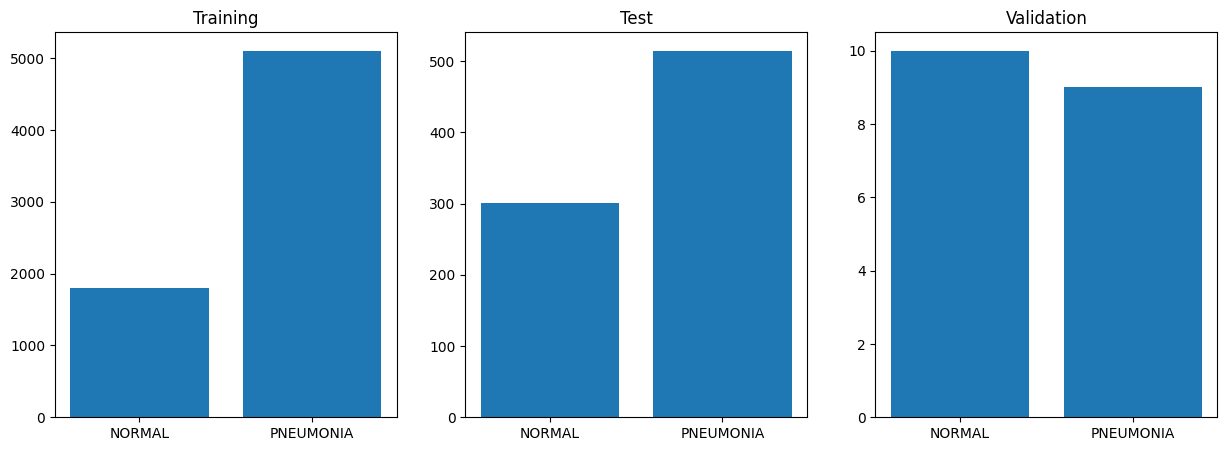

In [3]:
## This section just checks the number of images per class post or pre augmentation
# Post review Rachel suggested that we don't need to augment the Test & Validation & we made that change
def howmanyimages(main_folder = './chest_xray'):
    """
    This function counts files
    """
    subfolders = ['Training', 'Test', 'Validation']
    class_names = ['NORMAL', 'PNEUMONIA']
    
    fig, axs = plt.subplots(1, len(subfolders), figsize=(15, 5))
    
    for i, subfolder in enumerate(subfolders):
        files_per_subfolder = {}
        for class_name in class_names:
            subfolder_path = os.path.join(main_folder, subfolder , class_name)
            if os.path.isdir(subfolder_path):
                files_per_subfolder[class_name] = len([name for name in os.listdir(subfolder_path) 
                                                           if os.path.isfile(os.path.join(subfolder_path, name))])
        print("For ", subfolder)
        print(f'Number of files per class in the main folder: {files_per_subfolder}.\
              We will pick a few out of these for training, test & validation')
        
        # Create a bar chart for the current subfolder
        axs[i].bar(files_per_subfolder.keys(), files_per_subfolder.values())
        axs[i].set_title(subfolder)

    # Display the charts
    plt.show()
    
howmanyimages()

In [2]:
def get_data(main_folder, subfolders, class_names, num_images_per_class, whetherall = False):
    """
    Get the data and return Training, Test & Validation image set paths
    """
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    X_val = []
    y_val = []

    
    for subfolder in subfolders:
        for class_name in tqdm(class_names):
            class_folder = os.path.join(main_folder, subfolder, class_name)
            #print(class_folder)
            image_count = 0
            for file_name in os.listdir(class_folder):
                if file_name.endswith('.jpeg'):
                    file_path = os.path.join(class_folder, file_name)
                    if subfolder == 'Training':
                        X_train.append(file_path)
                        y_train.append(class_name)
                    elif subfolder == 'Test':
                        X_test.append(file_path)
                        y_test.append(class_name)
                    elif subfolder == 'Validation':
                        X_val.append(file_path)
                        y_val.append(class_name)
                    image_count += 1
                    if not whetherall:
                        if image_count >= num_images_per_class:
                            break

    return X_train, y_train, X_test, y_test, X_val, y_val


In [5]:
def visualize_features():
    """
    This function visualizes and explain the reasons why we chose the features we chose to model
    The visualization shows that the combination for 5 types of features showing texture, color depth,
    histogram gradients, contours & edges are a good combination for skin cancer image classification.
    
    Texture captures local spatial arrangement of pixel intensities
    Color depth captures distribution of color values which can distinguish between types of lesions
    HOG can detect boundaries and edges
    Contours & Edges can detect shapes and outlines again to distinguish between classes
    
    #### IMPORTANT NOTE; The current approach does not do any finetuning on the VGG16 or Resnet50/Resnet101 models 
    ### FINETUNING will be added in the future and may be more compute and memory intensive
    
    
    """
    main_folder_path = './chest_xray'
    subfolders = ['Training', 'Test', 'Validation']
    class_names = ['NORMAL','PNEUMONIA']
    
    X_train, _,_,_,_,_ = get_data(main_folder_path, subfolders, class_names, 
                                                                  1)
    
    #X_train_filtered = [file for file in X_train if "original" in file]
    X_train_filtered = X_train
    
    #print(X_train)
    
    # Select the first file from the filtered list of name containing Original word
    file_path = X_train_filtered[0]
    
    print("File image path", file_path)
    
    
    ## Plotting all complex features for one given image.
    print()
    print("Feature Set A")
    print()
    # Select the first file from the filtered list of name containing Original word
    file_path = X_train_filtered[0]

    image_c = cv2.imread(file_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image_c, cv2.COLOR_BGR2GRAY)

    # Compute the color histogram for each channel
    color = ('b', 'g', 'r')
    histograms = []
    for i, col in enumerate(color):
        hist = cv2.calcHist([image_c], [i], None, [256], [0, 256])
        histograms.append(hist)

    # Compute the LBP
    lbp = local_binary_pattern(gray, 8, 1)

    # Compute the HOG
    fd, hog_image = hog(gray, visualize=True)

    # Compute the contours and edges
    edges = cv2.Canny(gray, 100, 200)
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Apply a Gaussian filter to the edges
    edges_gaussian = cv2.GaussianBlur(edges, (5, 5), 0)

    # Draw the contours on the original image using green lines
    image_with_edges = cv2.drawContours(image_c.copy(), contours, -1, (0, 255, 0), 3)

    # Compute the Laplacian edges
    laplacian_edges = cv2.Laplacian(gray,cv2.CV_64F)

    # Display the image and features
    fig = plt.figure(figsize=(10, 10))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.subplot(331), plt.imshow(cv2.cvtColor(image_with_edges,cv2.COLOR_BGR2RGB)), 
    plt.title('Original with Edges')
    plt.subplot(332), plt.imshow(gray,cmap='gray'), plt.title('Grayscale')

    # Display the histogram (Bar)
    plt.subplot(333), plt.title('Color Histogram (Bar)')
    for i in range(3):
        plt.bar(np.arange(256) + i * 0.25,histograms[i].ravel(),width=0.25,color=color[i])
    plt.subplot(334), plt.imshow(lbp,cmap='gray'), plt.title('LBP')
    plt.subplot(335), plt.imshow(hog_image,cmap='gray'), plt.title('HOG')
    plt.subplot(336), plt.imshow(cv2.drawContours(image_c.copy(),contours,-1,(0,255,0),3)), 
    plt.title('Contours with Green Lines')
    plt.subplot(337), plt.imshow(edges_gaussian,cmap='gray'), plt.title('Edges with Gaussian Filter')
    plt.subplot(338), plt.imshow(laplacian_edges,cmap='gray'), plt.title('Laplacian Edges')
    plt.show()
    
    
    print("Feature Set B")
    print()
    
    img_original = image.load_img(file_path)

    img = cv2.imread(file_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Original image of class NORMAL')

    # Convert the image to a numpy array and preprocess it
    x_original = image.img_to_array(img_original)
    x_original = np.expand_dims(x_original, axis=0)
    x_vgg16_original = vgg16_preprocess_input(x_original)


    url = 'https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
    m_file_path = './vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
        
    # Download the weights file
    response = requests.get(url, verify=False)
    with open(m_file_path, 'wb') as f:
        f.write(response.content)

    # Load the VGG16 model without specifying any layer
    model_vgg16 = VGG16(weights=m_file_path, include_top=False)
    features_vgg16_original = model_vgg16.predict(x_vgg16_original, verbose=0)

    # Load the image and resize it to 224x224
    img_resized = image.load_img(file_path, target_size=(224, 224))

    # Convert the image to a numpy array and preprocess it
    x_resized = image.img_to_array(img_resized)
    x_resized = np.expand_dims(x_resized, axis=0)
    
    x_vgg16_resized = vgg16_preprocess_input(x_resized)
    
    x_resnet50_resized = resnet50_preprocess_input(x_resized)


    url = 'https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
    m_rfile_path = './vgg16_weights_tf_dim_ordering_tf_kernels.h5'
    
    # Download the weights file
    response = requests.get(url, verify=False)
    with open(m_rfile_path, 'wb') as f:
        f.write(response.content)

    # Load the pre-trained VGG16 model with the downloaded weights
    base_model = VGG16(weights=m_rfile_path)
    
    # Create a new model that outputs the features from the specified layer
    model_vgg16_l = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv3').output)
    
    # Load the VGG16 model with specifying a layer block5_conv3
    features_vgg16_resized = model_vgg16_l.predict(x_vgg16_resized, verbose=0)

    # Load the ResNet50 model with layer conv5_block3_out
    urlr = 'https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet50_weights_tf_dim_ordering_tf_kernels.h5'
    file_path_r = './resnet50_weights_tf_dim_ordering_tf_kernels.h5'
        
    # Download the weights file
    responser = requests.get(urlr, verify=False)
    with open(file_path_r, 'wb') as fr:
        fr.write(responser.content)

    
    model_resnet50_conv5_block3_out = ResNet50(weights=file_path_r) #'imagenet'
    model_resnet50_conv5_block3_out = Model(inputs=model_resnet50_conv5_block3_out.input, 
                                            outputs=model_resnet50_conv5_block3_out.get_layer('conv5_block3_out').output)
    features_resnet50_conv5_block3_out = model_resnet50_conv5_block3_out.predict(x_resnet50_resized, verbose=0)

    # Plot the extracted features
    plt.figure(figsize=(10, 10))
    plt.subplot(321), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Original')
    plt.subplot(322), plt.imshow(features_vgg16_original[0, :, :, 0], cmap='gray'), plt.title('VGG16 Original Size')
    plt.subplot(323), plt.imshow(features_vgg16_resized[0, :, :, 0], cmap='gray'), plt.title('VGG16 Resized')
    plt.subplot(324), plt.imshow(features_resnet50_conv5_block3_out[0, :, :, 0], cmap='gray'), 
    plt.title('ResNet50 Resized')
    plt.show()
    
    # Extract the CNN features without resizing the image
    model = VGG16(weights=m_file_path, include_top=False)
    img = image.load_img(file_path, target_size=(600, 450))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = vgg16_preprocess_input(img_data)
    cnn_feature = model.predict(img_data, verbose=0).flatten()

    # Extract the CNN features with resizing to 224x224 using VGG16
    base_model = VGG16(weights=m_rfile_path)
    model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv3').output)
    img = image.load_img(file_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = vgg16_preprocess_input(img_data)
    cnn_feature224_vgg = model.predict(img_data, verbose=0).flatten()

    # Extract the CNN features with resizing to 224x224 using ResNet50
    base_model = ResNet50(weights=file_path_r)
    layer_name = 'conv5_block3_out'
    model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)
    img = image.load_img(file_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = resnet50_preprocess_input(img_data)
    cnn_feature_resnet = model.predict(img_data, verbose=0).flatten()

    
    print()
    # Plot the CNN features without resizing the image
    plt.figure(figsize=(10, 10))
    for i in range(64):
        plt.subplot(8, 8, i + 1)
        plt.imshow(cnn_feature.reshape((18, 14, 512))[:, :, i])
        plt.axis('off')
    plt.suptitle('CNN Features (No Resize) 600x450')
    plt.show()

    print()
    # Plot the CNN features with resizing to 224x224 using VGG16
    plt.figure(figsize=(10, 10))
    for i in range(64):
        plt.subplot(8, 8, i + 1)
        plt.imshow(cnn_feature224_vgg.reshape((14, 14, 512))[:, :, i])
        plt.axis('off')
    plt.suptitle('CNN Features (VGG16) 224x224')
    plt.show()

    print()
    # Plot the CNN features with resizing to 224x224 using ResNet50
    plt.figure(figsize=(10, 10))
    for i in range(64):
        plt.subplot(8, 8, i + 1)
        plt.imshow(cnn_feature_resnet.reshape((7, 7, 2048))[:, :, i])
        plt.axis('off')
    plt.suptitle('CNN Features (ResNet50) 224x224')
    plt.show()
    
    fig = plt.figure(figsize=(15, 15))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)

    for i, class_name in enumerate(class_names):
        X_train, _,_,_,_,_ = get_data(main_folder_path, subfolders, [class_name], 100)
        #print(X_train)
        X_train_filtered = X_train
        file_path = X_train_filtered[0]
        #print(file_path)
        image_n = cv2.imread(file_path)
        gray = cv2.cvtColor(image_n, cv2.COLOR_BGR2GRAY)

        # Compute the color histogram for each channel
        color = ('b', 'g', 'r')
        histograms = []
        for j, col in enumerate(color):
            hist = cv2.calcHist([image_n], [j], None, [256], [0, 256])
            histograms.append(hist)

        # Compute the LBP
        lbp = local_binary_pattern(gray, 8, 1)

        # Compute the HOG
        fd, hog_image = hog(gray, visualize=True)

        # Compute the contours and edges
        edges = cv2.Canny(gray, 100, 200)
        contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Apply a Gaussian filter to the edges
        edges_gaussian = cv2.GaussianBlur(edges, (5, 5), 0)

        # Plot the image and features
        plt.subplot(7, 6, i * 6 + 1), plt.imshow(cv2.cvtColor(image_n,cv2.COLOR_BGR2RGB)), plt.title(f'Original {class_name}')

        plt.subplot(7, 6, i * 6 + 2), plt.imshow(gray,cmap='gray'), plt.title(f'Grayscale {class_name}')

        # Display the histogram (Bar)
        plt.subplot(7, 6, i * 6 + 3), plt.title(f'Color Histogram {class_name}')
        for j in range(3):
            plt.bar(np.arange(256) + j * 0.25,histograms[j].ravel(),width=0.25,color=color[j])

        plt.subplot(7, 6, i * 6 + 4), plt.imshow(lbp,cmap='gray'), plt.title(f'LBP {class_name}')

        plt.subplot(7, 6, i * 6 + 5), plt.imshow(hog_image,cmap='gray'), plt.title(f'HOG {class_name}')

        plt.subplot(7, 6, i * 6 + 6), plt.imshow(edges_gaussian,cmap='gray'), plt.title(f'Edges with Gaussian Filter {class_name}')

    plt.show()
    


100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 1329.84it/s]


File image path ./chest_xray/Training/NORMAL/NORMAL2-IM-0927-0001.jpeg

Feature Set A



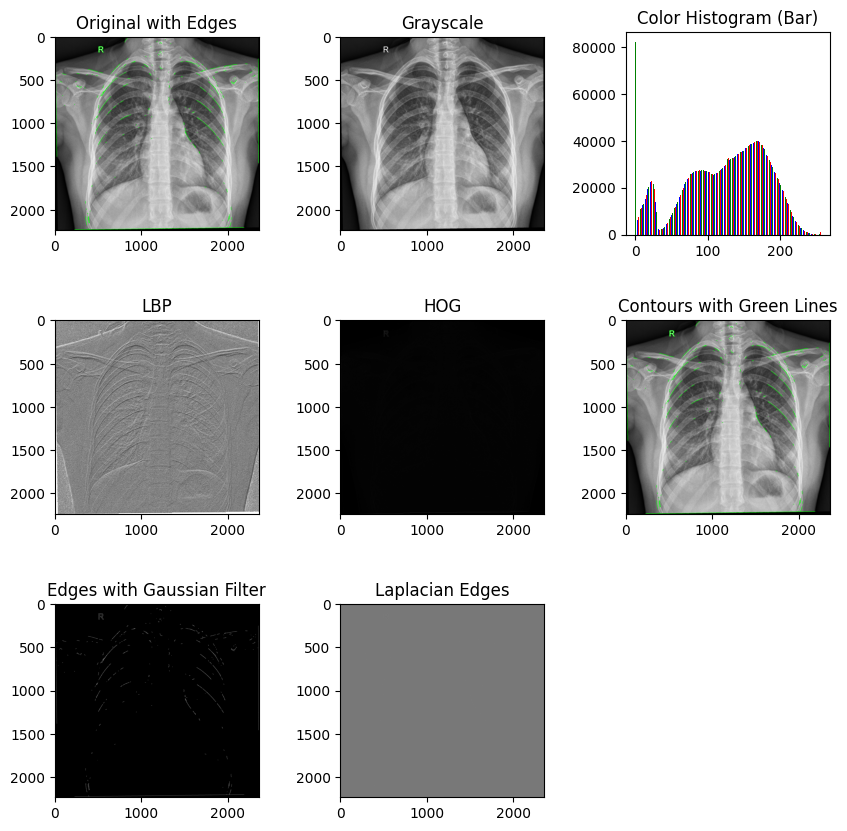

Feature Set B



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.r

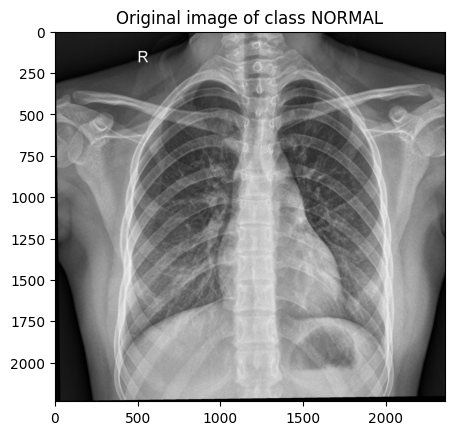

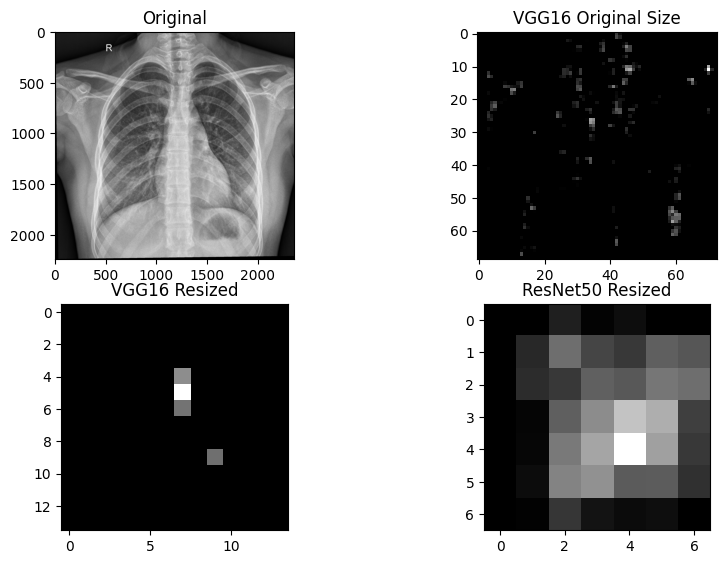

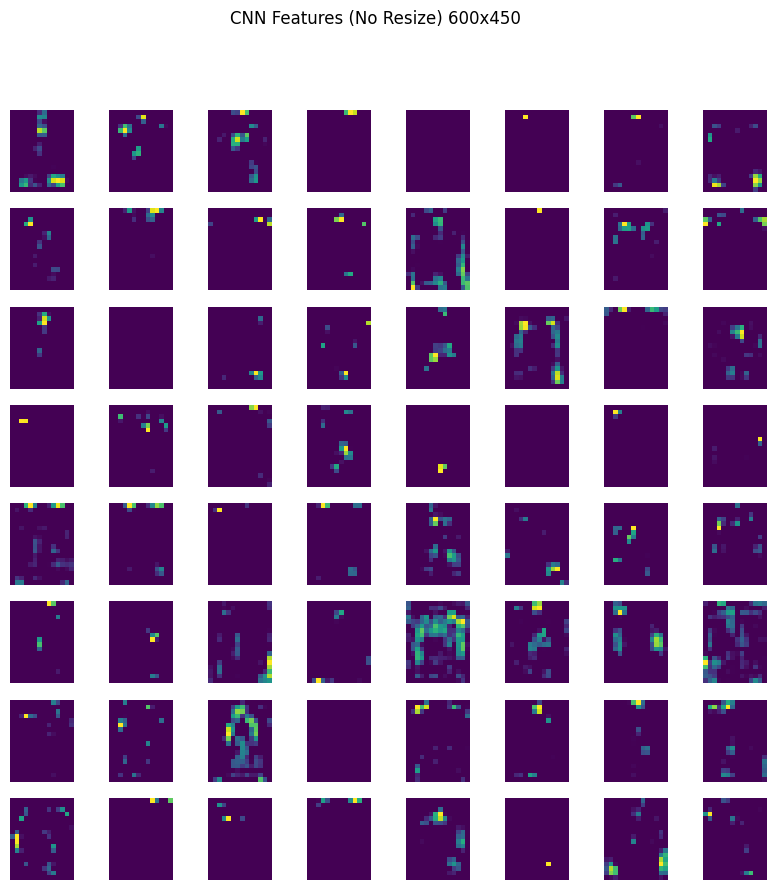

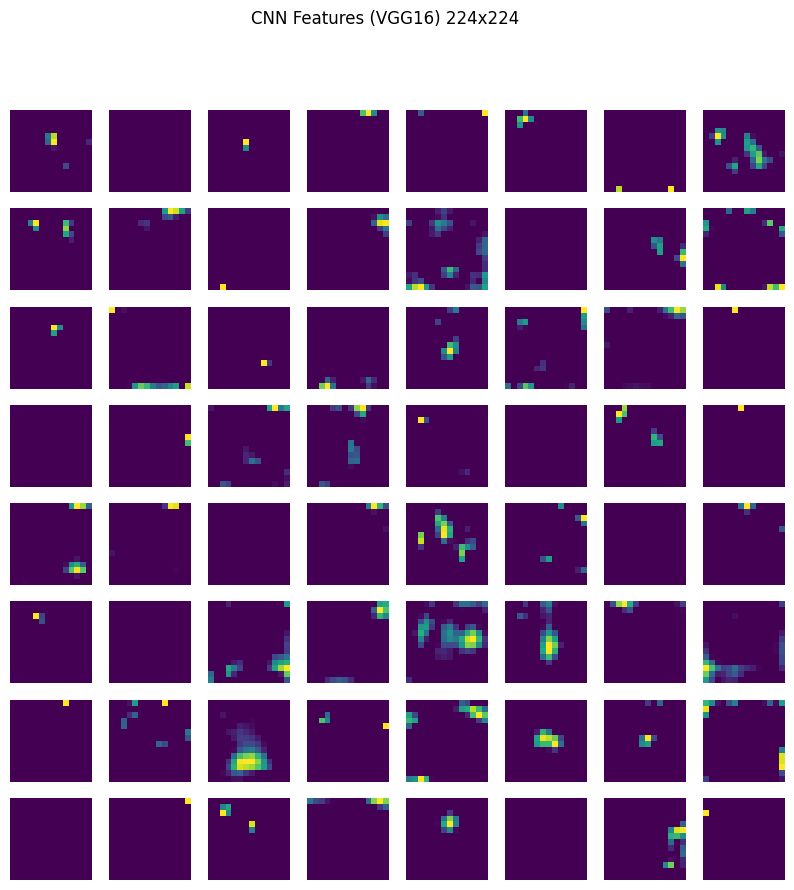

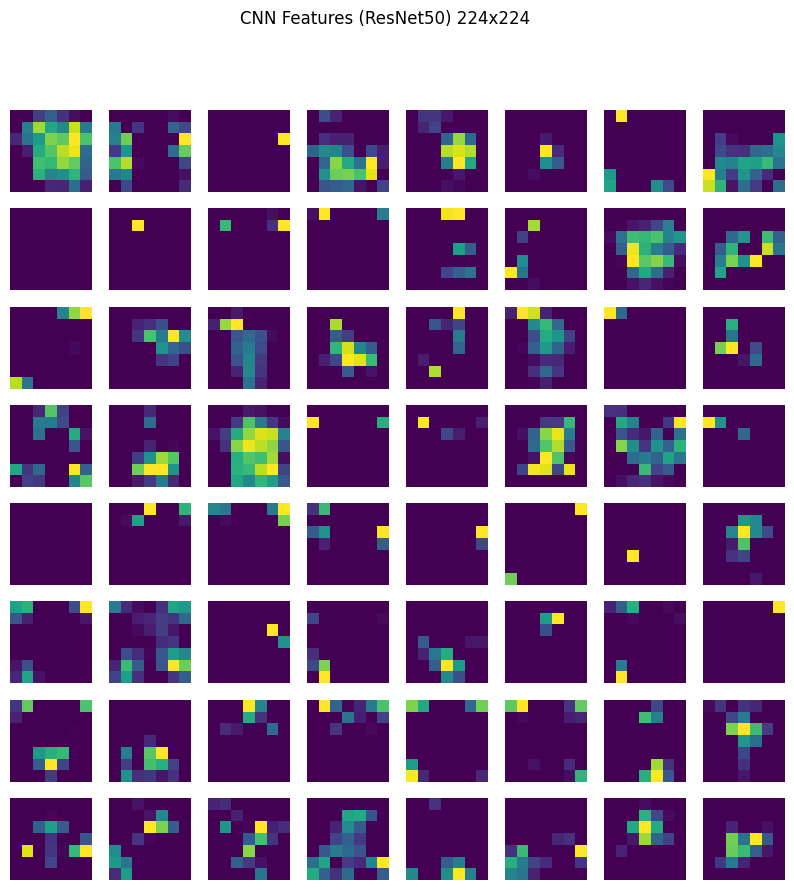

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 949.80it/s]


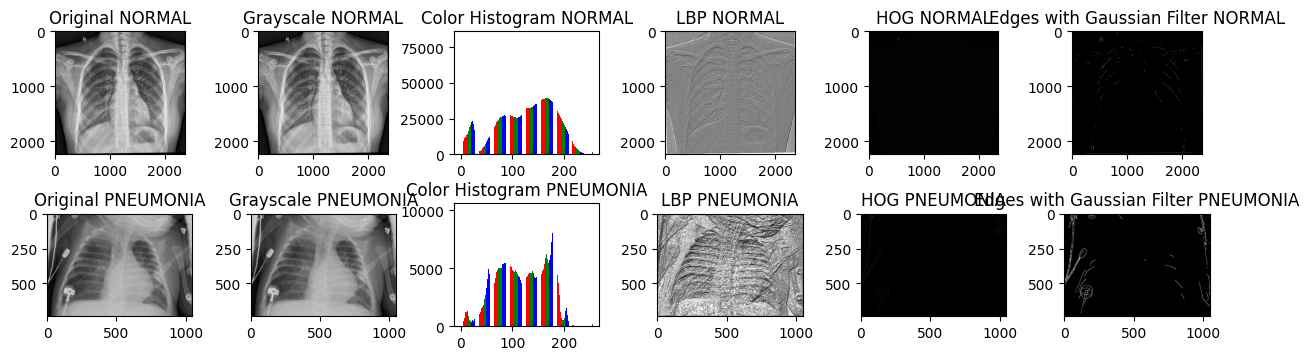

In [6]:
visualize_features()

## ML Based Image Analysis


#### HYPOTHESIS
With lightweight Combination Features & Embeddings based features (Resnet/VGG) effective image classification on `PNEUMONIA` dataset can be done with > 70% accuracy & > 75% ROC-AUC.

## Machine Learning Methods used

In this function, we train, evaluate & plot various optimizer performances for our datasets

The optimizers used are:

`Logistic Regression`: This is a simple and fast linear classifier that works well for binary classification tasks. It can also be extended to multi-class classification using techniques such as one-vs-rest or softmax regression.

`SGD`: Stochastic Gradient Descent (SGD) is an optimization algorithm that can be used to train a wide variety of models, including linear classifiers such as logistic regression and support vector machines. It is an iterative method that updates the model’s parameters in small steps based on a random subset of the training data, making it well-suited for large-scale learning tasks.

`Support Vector Machines/SVC`: Support Vector Machines (SVMs) are powerful classifiers that can handle both linearly separable and non-linearly separable data by using kernel functions to map the data into a higher-dimensional space. They are effective in high-dimensional spaces and can be trained on smaller datasets.

`Random Forests`: Random Forests are an ensemble learning method that combines multiple decision trees to improve the accuracy and robustness of the model. They can handle both categorical and continuous features and are relatively easy to interpret.

`Gaussian Naive Bayes`: This is a simple probabilistic classifier based on Bayes’ theorem that assumes independence between the features. It is fast and easy to implement, and can work well in practice even if the independence assumption is not strictly met.

`K Nearest Neighbors`: This is a non-parametric instance-based learning algorithm that classifies new instances based on their similarity to the training instances. It is simple to implement and can handle multi-class classification tasks.


[Source of optimizer definitions: bing.com]

We have implemented grid search for all of them but the process is immensely compute intensive & not meant for a laptop. So, skipped post finding the best params.

`Why were these choices made for this problem?` For low scale Non-GPU class work these optimizers are a set of great choices. However, which one to apply to a particular problem is a decison we made as a team.



### ML Helper Functions


Here we have functions for plotting the results and Hyper Param Tuning

In [2]:
## HELPER FUNCTIONS
def plot_roc_curve(y_test, y_score, classes):
    """
    This function plots ROC AUC curve for multiple algorithms/optimizers
    """
    le = LabelEncoder()
    y_test_encoded = le.fit_transform(y_test)
    
    try:
        fpr, tpr, _ = roc_curve(y_test_encoded, y_score)
        roc_auc = auc(fpr, tpr)
    
        plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {0:0.2f})'.format(roc_auc))
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic for binary data')
        plt.legend(loc="lower right")
        plt.show()
    except Exception as e:
        print("From the plot_roc_curve function", str(e))
        tb = traceback.extract_tb(e.__traceback__)
        filename, line, func, text = tb[-1]
        print(f'An exception occurred in file {filename}, line {line}, in {func}')
        print(f'Code: {text}')
        print(f'Exception: {str(e)}')


def plot_confusion_matrix(y_test, y_pred, class_names):
    """
    Visualizes the confusion matrix for multiple classes
    """
    try:
        cm = confusion_matrix(y_test, y_pred)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        fig, ax = plt.subplots()
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.figure.colorbar(im, ax=ax)
        
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               xticklabels=class_names, yticklabels=class_names,
               title='Normalized confusion matrix',
               ylabel='True label',
               xlabel='Predicted label')
        
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
        
        fmt = '.2f'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        
        fig.tight_layout()
        plt.show()
    except Exception as e:
        print("From the plot_confusion_matrix function",str(e))
        tb = traceback.extract_tb(e.__traceback__)
        filename, line, func, text = tb[-1]
        print(f'An exception occurred in file {filename}, line {line}, in {func}')
        print(f'Code: {text}')
        print(f'Exception: {str(e)}')
    
    
def evaluate_class(y_pred, y_test, class_name, class_names):
    """
    This function evaluates one of the classes v/s others in terms of metrics
    """
    try:
        # Calculate accuracy, precision, and recall for each class
        accuracies = []
        precisions = []
        recalls = []
    
        for c in class_names:
            accuracies.append(accuracy_score(y_test == c, y_pred == c))
            precisions.append(precision_score(y_test == c, y_pred == c))
            recalls.append(recall_score(y_test == c, y_pred == c))
    
        # Reorder the lists to plot the first class first
        first_class_idx = class_names.index(class_name)
        class_names = [class_name] + class_names[:first_class_idx] + class_names[first_class_idx+1:]
        accuracies = [accuracies[first_class_idx]] + accuracies[:first_class_idx] + accuracies[first_class_idx+1:]
        precisions = [precisions[first_class_idx]] + precisions[:first_class_idx] + precisions[first_class_idx+1:]
        recalls = [recalls[first_class_idx]] + recalls[:first_class_idx] + recalls[first_class_idx+1:]
    
        bar_width = 0.20
    
        r1 = np.arange(len(class_names))
        r2 = [x + bar_width for x in r1]
        r3 = [x + bar_width for x in r2]
    
        plt.bar(r1, accuracies, width=bar_width, label="Accuracy")
        plt.bar(r2, precisions, width=bar_width, label="Precision")
        plt.bar(r3, recalls, width=bar_width, label="Recall")
    
        plt.xticks([r + bar_width for r in range(len(class_names))], class_names)
    
        plt.hlines(accuracies[0], xmin=r1[0]-bar_width/2, xmax=r3[-1]+bar_width/2, 
               linestyles='dotted', colors='darkgreen', label="First class accuracy")
    
        plt.hlines(precisions[0], xmin=r1[0]-bar_width/2, xmax=r3[-1]+bar_width/2, 
                   linestyles='dotted', colors='darkblue', label="First class precision")
    
        plt.hlines(recalls[0], xmin=r1[0]-bar_width/2, xmax=r3[-1]+bar_width/2, 
                   linestyles='dotted', colors='darkred', label="First class recall")
    
        plt.legend()
        plt.show()
    except Exception as e:
        print("From the evaluate_class function",str(e))
        tb = traceback.extract_tb(e.__traceback__)
        filename, line, func, text = tb[-1]
        print(f'An exception occurred in file {filename}, line {line}, in {func}')
        print(f'Code: {text}')
        print(f'Exception: {str(e)}')
    


In [7]:
## MAIN TRAINING & EVALUATION FUNCTION
def train_and_evaluate(X_train, y_train, X_test, y_test, X_val, y_val, 
                       gridsrch= True, optslist = 'LR,CLF,SVM,KNN,NB,RF'):
    """
    This is the main training and evaluation functions that get called with Train, test and validation
    arrays and does an evaluation of all the different optimizers as can be seen below
    """
    global class_names


    # Create an imputer object that will replace missing values with the mean
    imputer = SimpleImputer(strategy='mean')
    # Fit the imputer on the training data
    imputer.fit(X_train)
    
    # Transform the training and test data to handle NaNs
    X_train_imputed = imputer.transform(X_train)
    X_test_imputed = imputer.transform(X_test)
    X_val_imputed = imputer.transform(X_val)
    """print(f"No of Nan in X_train_imputed: { np.sum(np.isnan(X_train_imputed))}")
    print(f"No of Nan in X_test_imputed: { np.sum(np.isnan(X_test_imputed))}")"""  
    
    """main_folder = '.\chest_xray'
    subfolders = ['Training']"""
    class_names = ['NORMAL','PNEUMONIA']
    
    start = time.time()
    
    optlist = optslist.split(',')
    
    
    # Ignore convergence warnings
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        warnings.filterwarnings("ignore", category=FitFailedWarning)
        warnings.filterwarnings("ignore")
        
        
        print()
        
        if 'LR' in optlist:
            print()
            print('Logistic Regression training:')
            lr = LogisticRegression(max_iter= 1000, C = 100.0)
            if gridsrch:
                param_grid = {
                    'C': [100, 300, 50], #20, 30 ,50, 10000,0.1, 0.01, 1, 
                    'penalty': ['l1', 'l2'], #
                    'solver': ['newton-cg', 'lbfgs'], #, 'liblinear', 'sag', 'saga''newton-cg',
                    'max_iter': [5000, 10000], #, 5000, 10000,, 10000 50000, 100000
                    'multi_class': ['ovr'] #'auto', 'multinomial'
                }
                grid = GridSearchCV(lr, param_grid, cv = 5, n_jobs=-1, verbose = 15)
                grid.fit(X_train, y_train)
                y_pred_lr = grid.predict(X_test)
                y_pred_lr_val = grid.predict(X_val_imputed)
                y_pred_lr_train = grid.predict(X_train_imputed)                
                best_params = grid.best_params_
                # Print the best parameters
                print("Best parameters: ", best_params)
            else:
                lr = LogisticRegression(max_iter=10000, C= 100.0) #, verbose = 1
                lr.fit(X_train_imputed, y_train)
                y_pred_lr = lr.predict(X_test_imputed)
                y_pred_lr_val = lr.predict(X_val_imputed)
                y_pred_lr_train = lr.predict(X_train_imputed)

            print('Accuracy train:', accuracy_score(y_train, y_pred_lr_train))
            print('Accuracy test:', accuracy_score(y_test, y_pred_lr))
            print('Accuracy val:', accuracy_score(y_val, y_pred_lr_val))

            try:
                # compute the predicted labels
                if gridsrch:
                    y_pred = np.argmax(grid.predict_proba(X_test_imputed), axis=1)
                    y_pred_v = np.argmax(grid.predict_proba(X_val_imputed), axis=1)
                else:
                    y_pred = np.argmax(lr.predict_proba(X_test_imputed), axis=1)
                    y_pred_v = np.argmax(lr.predict_proba(X_val_imputed), axis=1)

                
                if len(np.unique(y_test)) < 2 or len(np.unique(y_pred)) < 2 or \
                len(np.unique(y_val)) < 2 or len(np.unique(y_pred_v)) < 2:
                    print("ROC AUC score may not be well-defined when not all classes \
                    are present in y_test or y_pred.")
                else:
                    # compute the ROC AUC score
                    """y_pred_proba = lr.predict_proba(X_test_imputed)
                    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')"""
                    if gridsrch:
                        class_index = list(grid.classes_).index('PNEUMONIA')
                        print('AUC ROC tests:', roc_auc_score(y_test, grid.predict_proba(X_test_imputed)[:, class_index]))
                        print('AUC ROC val:', roc_auc_score(y_val, grid.predict_proba(X_val_imputed)[:, class_index]))
                        plot_roc_curve(np.array(y_test), np.array(grid.predict_proba(X_test_imputed)[:, class_index]), class_names)
                        plot_roc_curve(np.array(y_val), np.array(grid.predict_proba(X_val_imputed)[:, class_index]), class_names)                        
                    else:
                        class_index = list(lr.classes_).index('PNEUMONIA')
                        print('AUC ROC tests:', roc_auc_score(y_test, lr.predict_proba(X_test_imputed)[:, class_index]))
                        print('AUC ROC val:', roc_auc_score(y_val, lr.predict_proba(X_val_imputed)[:, class_index]))
                        plot_roc_curve(np.array(y_test), np.array(lr.predict_proba(X_test_imputed)[:, class_index]), class_names)
                        plot_roc_curve(np.array(y_val), np.array(lr.predict_proba(X_val_imputed)[:, class_index]), class_names)

            except Exception as e:
                print("From the train_and_evaluate function & LR section",str(e))
                tb = traceback.extract_tb(e.__traceback__)
                filename, line, func, text = tb[-3:-1]
                print(f'An exception occurred in file {filename}, line {line}, in {func}')
                print(f'Code: {text}')
                print(f'Exception: {str(e)}')

            #
            print('Precision test:', precision_score(y_test, y_pred_lr, average='weighted'))
            print('Recall test:', recall_score(y_test, y_pred_lr, average='weighted'))
            print('Precision val:', precision_score(y_val, y_pred_lr_val, average='weighted'))
            print('Recall val:', recall_score(y_val, y_pred_lr_val, average='weighted'))
            
            try:
                if 'PNEUMONIA' in np.unique(y_pred_lr_val): #np.unique(y_val) == 7 and 
                    print()
                    print("Printing how this model fairs for class PNEUMONIA")
                    evaluate_class(y_pred_lr_val, y_val, 'PNEUMONIA', class_names)
            except Exception as e:
                print()
                print("From the train_and_evaluate function & LR section",str(e))
                tb = traceback.extract_tb(e.__traceback__)
                filename, line, func, text = tb[-1]
                print(f'An exception occurred in file {filename}, line {line}, in {func}')
                print(f'Code: {text}')
                print(f'Exception: {str(e)}')


            ## Logistic Regression confusion matrix
            plot_confusion_matrix(np.array(y_test), np.array(y_pred_lr), class_names)


            ## Plot all grid search results
            if gridsrch:       
                print("Plot the gridsearch results for Logistic Regression")

                results = pd.DataFrame(grid.cv_results_)

                fig, axs = plt.subplots(2, 3, figsize=(15, 10))

                # Plot mean test score as a function of C
                axs[0, 0].plot(results['param_C'], results['mean_test_score'])
                axs[0, 0].set_xlabel('C')
                axs[0, 0].set_ylabel('Mean Test Score')
                axs[0, 0].set_title('Logistic Regression Hyperparameter Tuning')

                # Plot mean test score as a function of penalty
                sns.boxplot(x='param_penalty', y='mean_test_score', data=results, ax=axs[0, 1])
                axs[0, 1].set_xlabel('Penalty')
                axs[0, 1].set_ylabel('Mean Test Score')
                axs[0, 1].set_title('Logistic Regression Hyperparameter Tuning')

                # Plot mean test score as a function of solver
                sns.boxplot(x='param_solver', y='mean_test_score', data=results, ax=axs[0, 2])
                axs[0, 2].set_xlabel('Solver')
                axs[0, 2].set_ylabel('Mean Test Score')
                axs[0, 2].set_title('Logistic Regression Hyperparameter Tuning')

                # Plot mean test score as a function of max_iter
                sns.boxplot(x='param_max_iter', y='mean_test_score', data=results, ax=axs[1, 0])
                axs[1, 0].set_xlabel('Max Iterations')
                axs[1, 0].set_ylabel('Mean Test Score')
                axs[1, 0].set_title('Logistic Regression Hyperparameter Tuning')

                # Plot mean test score as a function of multi_class
                sns.boxplot(x='param_multi_class', y='mean_test_score', data=results, ax=axs[1, 1])
                axs[1, 1].set_xlabel('Multi Class')
                axs[1, 1].set_ylabel('Mean Test Score')
                axs[1, 1].set_title('Logistic Regression Hyperparameter Tuning')

                plt.tight_layout()
                plt.show()

            print()
            print(f"Cumulative Time taken in seconds was {time.time() - start}")
        if 'SGD' in optlist:
            print()
            print("Training with SGD Classifier..")

            if gridsrch:
                # SGD Classifier with logistic regression loss
                clf = SGDClassifier(loss='log_loss', max_iter=300)
                param_grid = {
                    'alpha': [0.01, 0.1, 1, 0.001], #, 10, 100
                    'penalty': ['l2'], #, 'l1', 'elasticnet'
                    'l1_ratio': [0.15], #np.linspace(0, 1, num=5),
                    'max_iter': [1500], #1000, 10000
                    'tol': np.logspace(-6, -3, num=3),
                    'learning_rate': ['optimal'], #, 'invscaling', 'adaptive'
                    'eta0': np.logspace(-5, -1, num=3),
                    'power_t': np.linspace(0.1, 1.0, num=5)
                }
                #param_grid_iterator = tqdm(list(ParameterGrid(param_grid)))
                
                grid = GridSearchCV(clf, param_grid, cv = 3, n_jobs=-1, verbose = 15)
                grid.fit(X_train_imputed, y_train)
                y_pred_clf = grid.predict(X_test_imputed)
                y_pred_clf_val = grid.predict(X_val_imputed)
                y_pred_clf_train = grid.predict(X_train_imputed)
                best_params = grid.best_params_
                # Print the best parameters
                print("Best parameters: ", best_params)
            else:
                clf = SGDClassifier(loss='log_loss', max_iter=1000, alpha= 1/100)
                clf.fit(X_train_imputed, y_train)
                y_pred_clf = clf.predict(X_test_imputed)
                y_pred_clf_val = clf.predict(X_val_imputed)
                y_pred_clf_train = clf.predict(X_train_imputed)
            print()
            print('SGD Classifier with logistic regression loss:')
            print()
            print('Accuracy train:', accuracy_score(y_train, y_pred_clf_train))
            print('Accuracy test:', accuracy_score(y_test, y_pred_clf))
            print('Accuracy val:', accuracy_score(y_val, y_pred_clf_val))



            try:
                # compute the predicted labels
                if gridsrch:
                    y_pred = np.argmax(grid.predict_proba(X_test_imputed), axis=1)
                    y_pred_v = np.argmax(grid.predict_proba(X_val_imputed), axis=1)
                else:
                    y_pred = np.argmax(clf.predict_proba(X_test_imputed), axis=1)
                    y_pred_v = np.argmax(clf.predict_proba(X_val_imputed), axis=1)

                if len(np.unique(y_test)) < 2 or len(np.unique(y_pred)) < 2 or \
                len(np.unique(y_val)) < 2 or len(np.unique(y_pred_v)) < 2:
                    print("ROC AUC score may not be well-defined when not all classes \
                    are present in y_test or y_pred.")
                else:
                    # compute the ROC AUC score
                    """y_pred_proba = lr.predict_proba(X_test_imputed)
                    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')"""
                    if gridsrch:
                        class_index = list(grid.classes_).index('PNEUMONIA')
                        
                        print('AUC ROC tests:', roc_auc_score(y_test, grid.predict_proba(X_test_imputed)[:, class_index]))
                        print('AUC ROC val:', roc_auc_score(y_val, grid.predict_proba(X_val_imputed)[:, class_index]))
                        plot_roc_curve(np.array(y_test), np.array(grid.predict_proba(X_test_imputed)[:, class_index]), class_names)
                        plot_roc_curve(np.array(y_val), np.array(grid.predict_proba(X_val_imputed)[:, class_index]), class_names)                        
                    else:
                        class_index = list(clf.classes_).index('PNEUMONIA')
                        
                        print('AUC ROC test:', roc_auc_score(y_test, clf.predict_proba(X_test_imputed)[:, class_index]))
                        print('AUC ROC val:', roc_auc_score(y_val, clf.predict_proba(X_val_imputed)[:, class_index]))
                            
                        plot_roc_curve(np.array(y_test), np.array(clf.predict_proba(X_test_imputed)[:, class_index]), class_names)
                        plot_roc_curve(np.array(y_val), np.array(clf.predict_proba(X_val_imputed)[:, class_index]), class_names)
                        
            except Exception as e:
                print("From the train_and_evaluate function & SGD section",str(e))
                tb = traceback.extract_tb(e.__traceback__)
                filename, line, func, text = tb[-1]
                print(f'An exception occurred in file {filename}, line {line}, in {func}')
                print(f'Code: {text}')
                print(f'Exception: {str(e)}')


            print('Precision test:', precision_score(y_test, y_pred_clf, average='weighted'))
            print('Recall test:', recall_score(y_test, y_pred_clf, average='weighted'))
            print('Precision val:', precision_score(y_val, y_pred_clf_val, average='weighted'))
            print('Recall val:', recall_score(y_val, y_pred_clf_val, average='weighted'))
            
            try:
                if 'PNEUMONIA' in np.unique(y_pred_clf_val): #np.unique(y_val) == 7 and
                        print()
                        print("Printing how this model fairs for class PNEUMONIA")
                        evaluate_class(y_pred_clf_val, y_val, 'PNEUMONIA', class_names)
            except Exception as e:
                print("From the train_and_evaluate function & SGD section",str(e))
                tb = traceback.extract_tb(e.__traceback__)
                filename, line, func, text = tb[-1]
                print(f'An exception occurred in file {filename}, line {line}, in {func}')
                print(f'Code: {text}')
                print(f'Exception: {str(e)}')
            
            print()
            #plot_roc_curve(np.array(y_test), np.array(clf.predict_proba(X_test_imputed)), class_names)
            plot_confusion_matrix(np.array(y_test), np.array(y_pred_clf), class_names)
            print()

            if gridsrch:
                print("Plot the gridsearch results for SGD")
                print()
                results = pd.DataFrame(grid.cv_results_)

                fig, axs = plt.subplots(4, 2, figsize=(15, 20))

                # Plot mean test score as a function of alpha
                axs[0, 0].plot(results['param_alpha'], results['mean_test_score'])
                axs[0, 0].set_xlabel('Alpha')
                axs[0, 0].set_ylabel('Mean Test Score')
                axs[0, 0].set_title('SGD Classifier Hyperparameter Tuning')

                # Plot mean test score as a function of penalty
                sns.boxplot(x='param_penalty', y='mean_test_score', data=results, ax=axs[0, 1])
                axs[0, 1].set_xlabel('Penalty')
                axs[0, 1].set_ylabel('Mean Test Score')
                axs[0, 1].set_title('SGD Classifier Hyperparameter Tuning')

                # Plot mean test score as a function of l1_ratio
                sns.boxplot(x='param_l1_ratio', y='mean_test_score', data=results, ax=axs[1, 0])
                axs[1, 0].set_xlabel('L1 Ratio')
                axs[1, 0].set_ylabel('Mean Test Score')
                axs[1, 0].set_title('SGD Classifier Hyperparameter Tuning')

                # Plot mean test score as a function of max_iter
                sns.boxplot(x='param_max_iter', y='mean_test_score', data=results, ax=axs[1, 1])
                axs[1, 1].set_xlabel('Max Iterations')
                axs[1, 1].set_ylabel('Mean Test Score')
                axs[1, 1].set_title('SGD Classifier Hyperparameter Tuning')

                # Plot mean test score as a function of tol
                sns.boxplot(x='param_tol', y='mean_test_score', data=results, ax=axs[2, 0])
                axs[2, 0].set_xlabel('Tolerance')
                axs[2, 0].set_ylabel('Mean Test Score')
                axs[2, 0].set_title('SGD Classifier Hyperparameter Tuning')

                # Plot mean test score as a function of learning_rate
                sns.boxplot(x='param_learning_rate', y='mean_test_score', data=results, ax=axs[2, 1])
                axs[2, 1].set_xlabel('Learning Rate')
                axs[2, 1].set_ylabel('Mean Test Score')
                axs[2, 1].set_title('SGD Classifier Hyperparameter Tuning')

                # Plot mean test score as a function of eta0
                sns.boxplot(x='param_eta0', y='mean_test_score', data=results, ax=axs[3, 0])
                axs[3, 0].set_xlabel('Eta0')
                axs[3, 0].set_ylabel('Mean Test Score')
                axs[3, 0].set_title('SGD Classifier Hyperparameter Tuning')

                # Plot mean test score as a function of power_t
                sns.boxplot(x='param_power_t', y='mean_test_score', data=results, ax=axs[3, 1])
                axs[3, 1].set_xlabel('Power T')
                axs[3, 1].set_ylabel('Mean Test Score')
                axs[3, 1].set_title('SGD Classifier Hyperparameter Tuning')

                plt.tight_layout()
                plt.show()
            print()
            print(f"Cumulative Time taken in seconds was {time.time() - start}")
            print()
            
    if 'SVM' in optlist:
        print()
        print("Training with SVM/SVC..")


        if gridsrch:
            svm = SVC(probability=True)
            param_grid = {
                'C': [0.1, 1, 10, 100],
                'kernel': ['rbf', 'sigmoid'], #'linear', 'poly', 
                                            #'degree': [1, 2, 3, 4],
                'gamma': ['scale', 'auto', 0.001, 1], #+ list(np.logspace(-5, 3, num=5)),
                'coef0': np.linspace(-1, 1, num=11),
                'shrinking': [True], #, False
                'probability': [True],
                'tol': np.logspace(-6, -3, num=3)
            }
            grid = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1, verbose =3)
            grid.fit(X_train_imputed, y_train)
            y_pred_svm = grid.predict(X_test_imputed)    
            y_pred_svm_val = grid.predict(X_val_imputed)
            y_pred_svm_train = grid.predict(X_train_imputed)
            best_params = grid.best_params_
            # Print the best parameters
            print("Best parameters: ", best_params)
        else:    
            # Support Vector Machines
            svm = SVC(kernel='linear', probability=True)
            svm.fit(X_train_imputed, y_train)
            y_pred_svm = svm.predict(X_test_imputed)
            y_pred_svm_val = svm.predict(X_val_imputed)
            print()    
            y_pred_svm_train = svm.predict(X_train_imputed)
            """svm = LinearSVC(dual=False) 
            svm.fit(X_train_imputed, y_train)
            y_pred_svm = svm.predict(X_test_imputed)
            y_pred_svm_val = svm.predict(X_val_imputed)
            y_pred_svm_train = svm.predict(X_train_imputed)"""
        
        print()    
        
        # Support Vector Machines
        print('Support Vector Machines:')
        print('Accuracy train:', accuracy_score(y_train, y_pred_svm_train))
        print('Accuracy test:', accuracy_score(y_test, y_pred_svm))
        print('Accuracy val:', accuracy_score(y_val, y_pred_svm_val))

        try:
            # compute the predicted labels
            if gridsrch:
                y_pred = np.argmax(grid.predict_proba(X_test_imputed), axis=1)
                y_pred_v = np.argmax(grid.predict_proba(X_val_imputed), axis=1)
            else:
                y_pred = np.argmax(svm.predict_proba(X_test_imputed), axis=1)
                y_pred_v = np.argmax(svm.predict_proba(X_val_imputed), axis=1)

            if len(np.unique(y_test)) < 2 or len(np.unique(y_pred)) < 2 or \
            len(np.unique(y_val)) < 2 or len(np.unique(y_pred_v)) < 2:
                print("ROC AUC score may not be well-defined when not all classes \
                are present in y_test or y_pred.")
            else:
                # compute the ROC AUC score
                if gridsrch:
                    class_index = list(grid.classes_).index('PNEUMONIA')
                    print('AUC ROC tests:', roc_auc_score(y_test, grid.predict_proba(X_test_imputed)[:, class_index]))
                    print('AUC ROC val:', roc_auc_score(y_val, grid.predict_proba(X_val_imputed)[:, class_index]))
                    plot_roc_curve(np.array(y_test), np.array(grid.predict_proba(X_test_imputed)[:, class_index]), class_names)
                    plot_roc_curve(np.array(y_val), np.array(grid.predict_proba(X_val_imputed)[:, class_index]), class_names)                    
                else:
                    class_index = list(svm.classes_).index('PNEUMONIA')
                    print('AUC ROC test:', roc_auc_score(y_test, svm.predict_proba(X_test_imputed)[:, class_index]))
                    print('AUC ROC val:', roc_auc_score(y_val, svm.predict_proba(X_val_imputed)[:, class_index]))

                    plot_roc_curve(np.array(y_test), np.array(svm.predict_proba(X_test_imputed)[:, class_index]), class_names)
                    plot_roc_curve(np.array(y_val), np.array(svm.predict_proba(X_val_imputed)[:, class_index]), class_names)
                    
        except Exception as e:
            print("From the train_and_evaluate function & SVM section",str(e))
            tb = traceback.extract_tb(e.__traceback__)
            filename, line, func, text = tb[-1]
            print(f'An exception occurred in file {filename}, line {line}, in {func}')
            print(f'Code: {text}')
            print(f'Exception: {str(e)}')



        print('Precision test:', precision_score(y_test, y_pred_svm, average='weighted'))
        print('Recall test:', recall_score(y_test, y_pred_svm, average='weighted'))
        print('Precision val:', precision_score(y_val, y_pred_svm_val, average='weighted'))
        print('Recall val:', recall_score(y_val, y_pred_svm_val, average='weighted'))
        
        try:
            if 'PNEUMONIA' in np.unique(y_pred_svm_val): #np.unique(y_val) == 7 and 
                    print()
                    print("Printing how this model fairs for class PNEUMONIA")
                    evaluate_class(y_pred_svm_val, y_val, 'PNEUMONIA', class_names)
        except Exception as e:
            print(str(e))
            tb = traceback.extract_tb(e.__traceback__)
            filename, line, func, text = tb[-1]
            print(f'An exception occurred in file {filename}, line {line}, in {func}')
            print(f'Code: {text}')
            print(f'Exception: {str(e)}')

        plot_confusion_matrix(np.array(y_test), np.array(y_pred_svm), class_names)
        
        if gridsrch:
            print()        
            print("Plot the gridsearch results for SVM/SVC")

            results = pd.DataFrame(grid.cv_results_)

            fig, axs = plt.subplots(3, 2, figsize=(15, 15))

            # Plot mean test score as a function of C
            axs[0, 0].plot(results['param_C'], results['mean_test_score'])
            axs[0, 0].set_xlabel('C')
            axs[0, 0].set_ylabel('Mean Test Score')
            axs[0, 0].set_title('SVM Hyperparameter Tuning')

            # Plot mean test score as a function of kernel
            sns.boxplot(x='param_kernel', y='mean_test_score', data=results, ax=axs[0, 1])
            axs[0, 1].set_xlabel('Kernel')
            axs[0, 1].set_ylabel('Mean Test Score')
            axs[0, 1].set_title('SVM Hyperparameter Tuning')

            # Plot mean test score as a function of gamma
            sns.boxplot(x='param_gamma', y='mean_test_score', data=results, ax=axs[1, 0])
            axs[1, 0].set_xlabel('Gamma')
            axs[1, 0].set_ylabel('Mean Test Score')
            axs[1, 0].set_title('SVM Hyperparameter Tuning')

            # Plot mean test score as a function of coef0
            sns.boxplot(x='param_coef0', y='mean_test_score', data=results, ax=axs[1, 1])
            axs[1, 1].set_xlabel('Coef0')
            axs[1, 1].set_ylabel('Mean Test Score')
            axs[1, 1].set_title('SVM Hyperparameter Tuning')

            # Plot mean test score as a function of shrinking
            sns.boxplot(x='param_shrinking', y='mean_test_score', data=results, ax=axs[2, 0])
            axs[2, 0].set_xlabel('Shrinking')
            axs[2, 0].set_ylabel('Mean Test Score')
            axs[2, 0].set_title('SVM Hyperparameter Tuning')

            # Plot mean test score as a function of probability
            sns.boxplot(x='param_probability', y='mean_test_score', data=results, ax=axs[2, 1])
            axs[2, 1].set_xlabel('Probability')
            axs[2, 1].set_ylabel('Mean Test Score')
            axs[2, 1].set_title('SVM Hyperparameter Tuning')

            plt.tight_layout()
            plt.show()

        print()
        print(f"Cumulative Time taken in seconds was {time.time() - start}")
        
        
    if 'RF' in optlist:
        print()    

        print("Training with Random Forest..")
        if gridsrch:
            rf = RandomForestClassifier()
            param_grid = {
                'n_estimators': [50, 100, 200],
                'max_depth': [30, 50, 200, None],
                'min_samples_split': [2, 4,  8],
                'min_samples_leaf': [1, 2, 8],
                'max_features': ['sqrt', 'log2']
            }
            grid = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1, verbose =1)
            grid.fit(X_train_imputed, y_train)
            y_pred_rf = grid.predict(X_test_imputed)
            y_pred_rf_val = grid.predict(X_val_imputed)
            y_pred_rf_train = grid.predict(X_train_imputed)
            best_params = grid.best_params_
            # Print the best parameters
            print("Best parameters: ", best_params)
        else:
            # Random Forest
            rf = RandomForestClassifier(n_estimators=100)
            rf.fit(X_train_imputed, y_train)
            y_pred_rf = rf.predict(X_test_imputed)
            y_pred_rf_val = rf.predict(X_val_imputed)
            y_pred_rf_train = rf.predict(X_train_imputed)

        print()    
        # Random Forest
        print('Random Forest:')
        print('Accuracy train:', accuracy_score(y_train, y_pred_rf_train))
        print('Accuracy test:', accuracy_score(y_test, y_pred_rf))
        print('Accuracy val:', accuracy_score(y_val, y_pred_rf_val))
        
        try:
            # compute the predicted labels
            if gridsrch:
                y_pred = np.argmax(grid.predict_proba(X_test_imputed), axis=1)
                y_pred_v = np.argmax(grid.predict_proba(X_val_imputed), axis=1)
            else:
                y_pred = np.argmax(rf.predict_proba(X_test_imputed), axis=1)
                y_pred_v = np.argmax(rf.predict_proba(X_val_imputed), axis=1)

            if len(np.unique(y_test)) < 2 or len(np.unique(y_pred)) < 2 or \
            len(np.unique(y_val)) < 2 or len(np.unique(y_pred_v)) < 2:
                print("ROC AUC score may not be well-defined when not all classes \
                are present in y_test or y_pred.")
            else:
                # compute the ROC AUC score
                """y_pred_proba = lr.predict_proba(X_test_imputed)
                auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')"""
                if gridsrch:
                    class_index = list(grid.classes_).index('PNEUMONIA')
                    print('AUC ROC tests:', roc_auc_score(y_test, 
                                                          grid.predict_proba(X_test_imputed)[:, class_index]))
                    print('AUC ROC val:', roc_auc_score(y_val, 
                                                        grid.predict_proba(X_val_imputed)[:, class_index]))
                    plot_roc_curve(np.array(y_test), np.array(grid.predict_proba(X_test_imputed)[:, class_index]), class_names)
                    plot_roc_curve(np.array(y_val), np.array(grid.predict_proba(X_val_imputed)[:, class_index]), class_names)

                else:
                    class_index = list(rf.classes_).index('PNEUMONIA')
                    print('AUC ROC test:', roc_auc_score(y_test, rf.predict_proba(X_test_imputed)[:, class_index]))
                    print('AUC ROC val:', roc_auc_score(y_val, rf.predict_proba(X_val_imputed)[:, class_index]))

                    plot_roc_curve(np.array(y_test), np.array(rf.predict_proba(X_test_imputed)[:, class_index]), class_names)
                    plot_roc_curve(np.array(y_val), np.array(rf.predict_proba(X_val_imputed)[:, class_index]), class_names)
        except Exception as e:
            print("From the train_and_evaluate function & RF section",str(e))        
            tb = traceback.extract_tb(e.__traceback__)
            filename, line, func, text = tb[-1]
            print(f'An exception occurred in file {filename}, line {line}, in {func}')
            print(f'Code: {text}')
            print(f'Exception: {str(e)}')
        

        print('Precision test:', precision_score(y_test, y_pred_rf, average='weighted'))
        print('Recall test:', recall_score(y_test, y_pred_rf, average='weighted'))
        print('Precision val:', precision_score(y_val, y_pred_rf_val, average='weighted'))
        print('Recall val:', recall_score(y_val, y_pred_rf_val, average='weighted'))

        try:
            if 'PNEUMONIA' in np.unique(y_pred_rf_val): #np.unique(y_val) == 7 and 
                    print()
                    print("Printing how this model fairs for class PNEUMONIA")
                    evaluate_class(y_pred_rf_val, y_val, 'PNEUMONIA', class_names)
            else:
                print("Class PNEUMONIA not found in the list")
                
        except Exception as e:
            print(str(e))        
            tb = traceback.extract_tb(e.__traceback__)
            filename, line, func, text = tb[-1]
            print(f'An exception occurred in file {filename}, line {line}, in {func}')
            print(f'Code: {text}')
            print(f'Exception: {str(e)}')
            
        
        if gridsrch:
            print("Plot the gridsearch results for Random Forest")
            print()
            results = pd.DataFrame(grid.cv_results_)

            fig, axs = plt.subplots(3, 2, figsize=(15, 15))

            # Plot mean test score as a function of n_estimators
            axs[0, 0].plot(results['param_n_estimators'], results['mean_test_score'])
            axs[0, 0].set_xlabel('Number of Estimators')
            axs[0, 0].set_ylabel('Mean Test Score')
            axs[0, 0].set_title('Random Forest Hyperparameter Tuning')

            # Plot mean test score as a function of max_depth
            sns.boxplot(x='param_max_depth', y='mean_test_score', data=results, ax=axs[0, 1])
            axs[0, 1].set_xlabel('Max Depth')
            axs[0, 1].set_ylabel('Mean Test Score')
            axs[0, 1].set_title('Random Forest Hyperparameter Tuning')

            # Plot mean test score as a function of min_samples_split
            sns.boxplot(x='param_min_samples_split', y='mean_test_score', data=results, ax=axs[1, 0])
            axs[1, 0].set_xlabel('Min Samples Split')
            axs[1, 0].set_ylabel('Mean Test Score')
            axs[1, 0].set_title('Random Forest Hyperparameter Tuning')

            # Plot mean test score as a function of min_samples_leaf
            sns.boxplot(x='param_min_samples_leaf', y='mean_test_score', data=results, ax=axs[1, 1])
            axs[1, 1].set_xlabel('Min Samples Leaf')
            axs[1, 1].set_ylabel('Mean Test Score')
            axs[1, 1].set_title('Random Forest Hyperparameter Tuning')

            # Plot mean test score as a function of max_features
            sns.boxplot(x='param_max_features', y='mean_test_score', data=results, ax=axs[2, 0])
            axs[2, 0].set_xlabel('Max Features')
            axs[2, 0].set_ylabel('Mean Test Score')
            axs[2, 0].set_title('Random Forest Hyperparameter Tuning')

            plt.tight_layout()
            plt.show()
        print()    
        print(f"Cumulative Time taken in seconds was {time.time() - start}")
    
    if 'NB' in optlist:
        print()    

        print("Training with Gaussian Naive bayes..")
        if gridsrch:
            param_grid = {'var_smoothing': np.logspace(0,-9, num=10)} ##100

            # Create a GridSearchCV object
            grid_search = GridSearchCV(GaussianNB(), param_grid, cv=5, n_jobs=-1, verbose =1)

            # Fit the GridSearchCV object to the data
            grid_search.fit(X_train_imputed, y_train)

            # Print the best parameters and the best score
            print(f"Best parameters: {grid_search.best_params_}")
            print(f"Best score: {grid_search.best_score_}")

            # Use the best estimator to make predictions on the test set
            y_pred_nb = grid_search.best_estimator_.predict(X_test_imputed)
            y_pred_nb_val = nb.predict(X_val_imputed)
        else:
            # Naive Bayes
            nb = GaussianNB()
            nb.fit(X_train_imputed, y_train)
            y_pred_nb = nb.predict(X_test_imputed)
            y_pred_nb_val = nb.predict(X_val_imputed)

        print()
        # Naive Bayes
        print('Naive Bayes:')
        print('Accuracy test:', accuracy_score(y_test, y_pred_nb))
        print('Accuracy val:', accuracy_score(y_val, y_pred_nb_val))
        
        try:
            # compute the predicted labels
            if gridsrch:
                y_pred = np.argmax(grid.predict_proba(X_test_imputed), axis=1)
                y_pred_v = np.argmax(grid.predict_proba(X_val_imputed), axis=1)
            else:
                y_pred = np.argmax(nb.predict_proba(X_test_imputed), axis=1)
                y_pred_v = np.argmax(nb.predict_proba(X_val_imputed), axis=1)

            if len(np.unique(y_test)) < 2 or len(np.unique(y_pred)) < 2 or \
            len(np.unique(y_val)) < 2 or len(np.unique(y_pred_v)) < 2:
                print("ROC AUC score may not be well-defined when not all classes \
                are present in y_test or y_pred.")
            else:
                # compute the ROC AUC score
                """y_pred_proba = lr.predict_proba(X_test_imputed)
                auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')"""
                if gridsrch:
                    print('AUC ROC tests:', roc_auc_score(y_test, 
                                                          grid.predict_proba(X_test_imputed), multi_class='ovr'))
                    print('AUC ROC val:', roc_auc_score(y_val, 
                                                        grid.predict_proba(X_val_imputed), multi_class='ovr'))
                else:
                    print('AUC ROC test:', roc_auc_score(y_test, rf.predict_proba(X_test_imputed), 
                                             multi_class='ovr'))
                    print('AUC ROC val:', roc_auc_score(y_val, rf.predict_proba(X_val_imputed), 
                                            multi_class='ovr'))

        except Exception as e:
            print("From the train_and_evaluate function & GNB section",str(e))        
            tb = traceback.extract_tb(e.__traceback__)
            filename, line, func, text = tb[-1]
            print(f'An exception occurred in file {filename}, line {line}, in {func}')
            print(f'Code: {text}')
            print(f'Exception: {str(e)}')
            
        
        print('Precision test:', precision_score(y_test, y_pred_nb, average='weighted'))
        print('Recall test:', recall_score(y_test, y_pred_nb, average='weighted'))
        print('Precision val:', precision_score(y_val, y_pred_nb_val, average='weighted'))
        print('Recall val:', recall_score(y_val, y_pred_nb_val, average='weighted'))
        
        try:
            if 'PNEUMONIA' in np.unique(y_pred_nb_val): #np.unique(y_val) == 7 and 
                    print()
                    print("Printing how this model fairs for class PNEUMONIA")
                    evaluate_class(y_pred_nb_val, y_val, 'PNEUMONIA', class_names)
        except Exception as e:
            print(str(e)) 
            tb = traceback.extract_tb(e.__traceback__)
            filename, line, func, text = tb[-1]
            print(f'An exception occurred in file {filename}, line {line}, in {func}')
            print(f'Code: {text}')
            print(f'Exception: {str(e)}')
            

                
        if gridsrch:
            print("Plot the gridsearch results for Naive Bayes")

            results = pd.DataFrame(grid_search.cv_results_)

            plt.plot(results['param_var_smoothing'], results['mean_test_score'])
            plt.xscale('log')
            plt.xlabel('Var Smoothing')
            plt.ylabel('Mean Test Score')
            plt.title('Gaussian Naive Bayes Hyperparameter Tuning')
            plt.show()
        print()        
        print(f"Cumulative Time taken was {time.time() - start}")  
        
        
    if 'KNN' in optlist:
        print()        
        if gridsrch:    
            print("Training with KNN..")
            # k-Nearest Neighbors
            knn = KNeighborsClassifier()
            param_grid = {
                    'n_neighbors': [10, 30],
                    'weights': ['distance'],
                    'algorithm': ['kd_tree'],
                    'leaf_size': [20],
                    'p': [2],
                    'metric': ['minkowski']
                }
            """param_grid = {
                'n_neighbors': [10, 30], #3, 5, 7, 9, 12,
                'weights': ['distance'], #'uniform', 
                'algorithm': ['kd_tree', 'brute','ball_tree'], #'auto','kd_tree',,  'brute'
                'leaf_size': [20, 50, 100, 200], #10, 20,, 40, 50
                'p': [2],#1,
                'metric': ['minkowski', 'euclidean', 'manhattan'] #
            }"""
            grid = GridSearchCV(knn, param_grid, cv=5, n_jobs=-1, verbose = 15)
            grid.fit(X_train_imputed, y_train)
            y_pred_knn = grid.predict(X_test_imputed)
            y_pred_knn_val = grid.predict(X_val_imputed)
            y_pred_knn_train = grid.predict(X_train_imputed)
            print()
            print('k-Nearest Neighbors:')
            print('Best parameters:', grid.best_params_)
            print('Accuracy train:', accuracy_score(y_train, y_pred_knn_train))
            print('Accuracy test:', accuracy_score(y_test, y_pred_knn))
            print('Accuracy  val:', accuracy_score(y_val, y_pred_knn_val))
            print('Precision:', precision_score(y_test, y_pred_knn, average='weighted', zero_division=0))
            print('Recall:', recall_score(y_test, y_pred_knn, average='weighted'))
            print('Precision:', precision_score(y_val, y_pred_knn_val, average='weighted', zero_division=0))
            print('Recall:', recall_score(y_val, y_pred_knn_val, average='weighted'))

            
            try:
            # compute the predicted labels
                y_pred = np.argmax(grid.predict_proba(X_test_imputed), axis=1)
                y_pred_v = np.argmax(grid.predict_proba(X_val_imputed), axis=1)

                if len(np.unique(y_test)) < 2 or len(np.unique(y_pred)) < 2 or \
                    len(np.unique(y_val)) < 2 or len(np.unique(y_pred_v)) < 2:
                    print("ROC AUC score may not be well-defined when not all classes \
                    are present in y_test or y_pred.")
                else:
                    # compute the ROC AUC score
                    class_index = list(grid.classes_).index('PNEUMONIA')
                    print('AUC ROC tests:', roc_auc_score(y_test, 
                                                         grid.predict_proba(X_test_imputed)[:, class_index]))
                    print('AUC ROC val:', roc_auc_score(y_val, 
                                                        grid.predict_proba(X_val_imputed)[:, class_index]))

            except Exception as e:
                print("From the train_and_evaluate function & KNN section",str(e))        
                tb = traceback.extract_tb(e.__traceback__)
                filename, line, func, text = tb[-1]
                print(f'An exception occurred in file {filename}, line {line}, in {func}')
                print(f'Code: {text}')
                print(f'Exception: {str(e)}')
            
            
            try:
                if 'PNEUMONIA' in np.unique(y_pred_knn_val): #np.unique(y_val) == 7 and 
                        print()
                        print("Printing how this model fairs for class PNEUMONIA")
                        evaluate_class(y_pred_knn_val, y_val, 'PNEUMONIA', class_names)
            except Exception as e:
                print("From the train_and_evaluate function & KNN section",str(e)) 
                tb = traceback.extract_tb(e.__traceback__)
                filename, line, func, text = tb[-1]
                print(f'An exception occurred in file {filename}, line {line}, in {func}')
                print(f'Code: {text}')
                print(f'Exception: {str(e)}')
                
            # Plot the results
            results = pd.DataFrame(grid.cv_results_)

            fig, axs = plt.subplots(3, 2, figsize=(15, 15))

            # Plot mean test score as a function of n_neighbors
            axs[0, 0].plot(results['param_n_neighbors'], results['mean_test_score'])
            axs[0, 0].set_xlabel('Number of Neighbors')
            axs[0, 0].set_ylabel('Mean Test Score')
            axs[0, 0].set_title('KNN Hyperparameter Tuning')

            # Plot mean test score as a function of weights
            sns.boxplot(x='param_weights', y='mean_test_score', data=results, ax=axs[0, 1])
            axs[0, 1].set_xlabel('Weights')
            axs[0, 1].set_ylabel('Mean Test Score')
            axs[0, 1].set_title('KNN Hyperparameter Tuning')

            # Plot mean test score as a function of algorithm
            sns.boxplot(x='param_algorithm', y='mean_test_score', data=results, ax=axs[1, 0])
            axs[1, 0].set_xlabel('Algorithm')
            axs[1, 0].set_ylabel('Mean Test Score')
            axs[1, 0].set_title('KNN Hyperparameter Tuning')

            # Plot mean test score as a function of leaf_size
            sns.boxplot(x='param_leaf_size', y='mean_test_score', data=results, ax=axs[1, 1])
            axs[1, 1].set_xlabel('Leaf Size')
            axs[1, 1].set_ylabel('Mean Test Score')
            axs[1, 1].set_title('KNN Hyperparameter Tuning')

            # Plot mean test score as a function of p
            sns.boxplot(x='param_p', y='mean_test_score', data=results, ax=axs[2, 0])
            axs[2, 0].set_xlabel('P')
            axs[2, 0].set_ylabel('Mean Test Score')
            axs[2, 0].set_title('KNN Hyperparameter Tuning')

            # Plot mean test score as a function of metric
            sns.boxplot(x='param_metric', y='mean_test_score', data=results, ax=axs[2, 1])
            axs[2, 1].set_xlabel('Metric')
            axs[2, 1].set_ylabel('Mean Test Score')
            axs[2, 1].set_title('KNN Hyperparameter Tuning')

            plt.tight_layout()
            plt.show()
            print()        
            print(f"Cumulative Time taken was {time.time() - start}")    
            print() 

# Extracting Features & Training (with multiple options/variations)

I decided to use Feature Extraction and then using ML training on them to create models for this binary image classification problem. 
We first ensure `class balance` by selecting equal number of images per class & then extract sophisticated features from the images. 
Next, we run the features through 2 distinct approaches - PCA & Non-PCA based `Dimensionality & Noise reduction` & then applying multiple types of Optimization Algorithms/Machine Learning Optimization.

In this section there are 2 types of functions definitions. 

`mlfeaturizationandtraining()`
&
`PCAbasedanalysis()`

The first one Generates features that are large and complex liek Combination Features. The second one does PCA reduction on embeddding features & more (although we are not using PCA a lot in this project becuase it did not perform or learning how to make it perform is a post project task. Please see resutls of PCA towards the end)

The parameters passed to the `mlfeaturizationandtraining` function are:

1. `num_images_per_class` Number of samples per class; it has to be equal no of samples to ensure `class balance`
2. `main_folder` Main folder path where the dataset is
3. `parent_folder` Parent folder path to save the features as .npy
4. `gridsrch` Whether or not to do grid search
5. `load` Whether to load data from .npy files, these are extracted features
6. `tne` Whether to do training and evaluation or just extract features
7. `whichftr` Which features to run training and eval on - `all` mean all
   `one` mean VGG16 with 224x224, `two` means Resnet50, `three` means VGG16 600x450 & `four` means the feature combo.
8. `optslist` Optimizers to use for training
9. `simplifyfeatures` Whether to simplify the feature vector using Variance & K Best
9. `pct` Percentage of features for K Best
10. `color_space_clhce` which color space to use for Color Histogram



`PCA FUNCTION`

The parameters passed to the `PCAbasedanalysis` function are:

1. `num_images_per_class` Number of samples per class; it has to be equal no of samples to ensure `class balance`
2. `parent_folder` Parent folder path to save the features as .npy
3. `k` Number of principal components
4. `whichftr` which of the 5 feature types to use 
5. `alg` which algorithm/optimizer to use
6. `screeapp` Whether to use PCA components based on Explained Variance Count
7. `gridsrch` whether to dp grid search for hyper parameters
8. `Strat` Whether to use Stratified cross validations
9. `en_y` whether to use Custom scoring in the GridSearchCV
10. `objective_trial` Objective trials to find the best algorithm and HPs

## Feature Extraction 

In this function we extract various types of features. 

- VGG16 (2 ways) - Created 600x450 as well as the native 224x224 feature sizes from layer `block5_conv3`
- Resnet50 - Extracted Features from `conv5_block3_out`
- Combination Feature = `C-Histogram` + `LBP` + `HOG` + `Contours` + `Edges`

The parameters are:

1. `X` the train,test, val list of file paths
2. `n_components_pca` This has become useless since I don't use PCA any more but it was used initially to ensure that across train/test/val we use the same no of components or the Training/Eval to work; Retaining for future purposes.
3. `color_space_clhce` Which color space to use for C-Histograms since it has been seen that LAB & HSV work well in terms of model perf

Here is a list of color spaces that we intend to support eventually. Currently, only BGR & LAB are supported.
- RGB: Red, Green, Blue
- BGR: Blue, Green, Red (used by OpenCV by default)
- HSV: Hue, Saturation, Value
- HLS: Hue, Lightness, Saturation
- YUV: Luma, Chroma U, Chroma V
- YCrCb: Luma, Chroma Red, Chroma Blue
- LAB: Lightness, A Channel (green to red), B Channel (blue to yellow)
- LUV: Lightness, U Channel (green to red), V Channel (blue to yellow)
- XYZ: CIE 1931 XYZ color space

In [9]:

def extract_features(X, n_components_pca = 0, color_space_clhce = 'BGR'):
    """
    Extract PCA, HOG, CNN+PCA & Color Histogram, contour, edge features from the images
    Note: One more step could be to use grayscale images along with color histogram
    Also, we need to see if we can merge all these together and create one feature set instead
    of 4.

    IMPORTANT : What has not been done yet?

    FINETUNING will be added in the future and may be more compute and memory intensive
    Batching of feature extraction will be done in the future as well to ensure we can 
    further minimize the compute requirement.
    """
    pca_cnn_features = []
    cnn_features = []
    hog_features = []
    color_hist_features = []
    pca_direct_features = []
    color_hist_features = []
    lbp_features = []
    hog_features = []
    contour_features = []
    edge_features = []
    
    try:


        tf.config.threading.set_inter_op_parallelism_threads(32)
        tf.config.threading.set_intra_op_parallelism_threads(32)

        
        url = 'https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
        file_path = './vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
        
        # Download the weights file
        response = requests.get(url, verify=False)
        with open(file_path, 'wb') as f:
            f.write(response.content)
        
        
        # Load the VGG16 model with the downloaded weights
        model = VGG16(weights=file_path, include_top=False)
        
        ## Extracing CNN features and then PCA from it
        #model = VGG16(weights='imagenet', include_top=False)

        print("==> Extracting CNN features with default image size without resizing") #Color Histogram & 
        for file_path in tqdm(X):
            #print(file_path)
            img = image.load_img(file_path, target_size=(800, 600))
            img_data = image.img_to_array(img)
            img_data = np.expand_dims(img_data, axis=0)
            img_data = vgg16_preprocess_input(img_data)
            cnn_feature = model.predict(img_data, verbose =0 )
            cnn_features.append(cnn_feature.flatten())

        print("Without Resizing VGG16 feature extraction completed", np.array(cnn_features).shape)
        print()
        ## Extract as 224 x 224 since it tends to perform better from a specific layer
        # Due to limitation of resources, we cannot test all possible layers that may be 
        # Good from the model metrics POV
        cnn_features224_vgg = []

        print("==> Extracting CNN 224 x 224 features with resizing")
        """#base_model = VGG16(weights='imagenet')
        base_model = VGG16(weights= file_path)
        model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv3').output)
        #model = VGG16(weights='imagenet', include_top=False)"""

        url = 'https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
        file_path = './vgg16_weights_tf_dim_ordering_tf_kernels.h5'
        
        # Download the weights file
        response = requests.get(url, verify=False)
        with open(file_path, 'wb') as f:
            f.write(response.content)

        #### IMPORTANT NOTE; The current approach does not do any finetuning on the VGG16 or Resnet50/Resnet101 models 
        ### FINETUNING will be added in the future and may be more compute and memory intensive
        
        
        # Load the pre-trained VGG16 model with the downloaded weights
        base_model = VGG16(weights=file_path)
        
        # Create a new model that outputs the features from the specified layer
        model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv3').output)

        for file_path in tqdm(X):
            img = image.load_img(file_path, target_size=(224, 224))
            img_data = image.img_to_array(img)
            img_data = np.expand_dims(img_data, axis=0)
            img_data = vgg16_preprocess_input(img_data)
            cnn_feature224 = model.predict(img_data, verbose =0 )
            cnn_features224_vgg.append(cnn_feature224.flatten())
                
        print("With Resizing VGG16 feature extraction completed")
        print()
                
        print("==> Extracting Resnet50 224 x  224 features with resize")
        # Load the pre-trained ResNet50 model
        """base_model = ResNet50(weights='imagenet')

        # Specify the layer name from which you want to extract features
        layer_name = 'conv5_block3_out'

        # Create a new model that outputs the features from the specified layer
        model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)"""

        urlr = 'https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet50_weights_tf_dim_ordering_tf_kernels.h5'
        file_path_r = './resnet50_weights_tf_dim_ordering_tf_kernels.h5'
        
        # Download the weights file
        responser = requests.get(urlr, verify=False)
        with open(file_path_r, 'wb') as fr:
            fr.write(responser.content)
        
        # Load the pre-trained ResNet50 model with the downloaded weights
        base_model = ResNet50(weights=file_path_r)
        
        # Specify the name of the layer from which to extract features
        layer_name = 'conv5_block3_out'
        
        # Create a new model that outputs the features from the specified layer
        model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)

        cnn_features_resnet = []

        for file_path in tqdm(X):
            # Load and preprocess the image
            img = image.load_img(file_path, target_size=(224, 224))
            img_data = image.img_to_array(img)
            img_data = np.expand_dims(img_data, axis=0)
            img_data = resnet50_preprocess_input(img_data)

            # Extract the CNN features
            cnn_featurer = model.predict(img_data, verbose=0)
            cnn_features_resnet.append(cnn_featurer.flatten())
        print("With Resizing RESNET50 feature extraction completed")
        print()

            
        ## KEEPING THIS CODE FOR FUTURE LEARNINGs
        """print("==> Extracting PCA from CNN with un-resized images")
        print("Shape before PCA", np.array(cnn_features).shape)
        # Transform the data using the chosen number of components
        if n_components_pca == 0:
            pca = PCA()
            pca.fit(cnn_features)

            # Calculate the cumulative explained variance
            cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

            print("Initial PCA number of components that are explaining 95% of variance is", n_components_pca)
            print()
            # Choose the number of components such that 95% of the total variance is retained
            n_components_pca = np.where(cumulative_explained_variance >= 0.95)[0][0] + 1

        print(f"Number of PCA components that retain 95% of the total explained variance for this set: \
            {n_components_pca}")

        print("==> Scaling CNN features")
        scaler = StandardScaler()
        cnn_features_scaled = scaler.fit_transform(cnn_features)

        print("==> Fitting PCA to scaled CNN features")
        pca = PCA(n_components=n_components_pca)
        pca.fit(cnn_features_scaled)

        # transform new data using the pre-fit PCA object
        pca_cnn_features = pca.transform(cnn_features_scaled)
        
        print("Shape after PCA", np.array(pca_cnn_features).shape)"""
        

        print()
        print("==> Extracting Color Hist, LBP, Hog, Contour & Edge features stacked into one")    

        ## We need to extract features using the LAB color space & may be simplify this further.

        st = time.time()

        color_hist_features = []
        lbp_features = []
        hog_features = []
        contour_features = []
        edge_features = []
 
        
        c = 0
        
        for file_path in tqdm(X):
            img = cv2.imread(file_path)
            
            
            img = cv2.resize(img, (1200, 1500))
            
            if color_space_clhce == 'BGR':
                color_hist_feature = cv2.calcHist([img], [0, 1, 2], None, 
                                                  [8, 8, 8], [0, 256, 0, 256, 0, 256])
            elif color_space_clhce == 'LAB':
                lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB) # Extracting from LAB color space
                color_hist_feature = cv2.calcHist([lab_img], [0, 1, 2], None, 
                                                  [8, 8, 8], [0, 256, 0, 256, 0, 256])
            else:
                print("The value of parameter color_space_clhce is not supported yet! Use BGR or LAB")
                break

            if not np.isnan(color_hist_feature).any():
                color_hist_features.append(color_hist_feature.flatten())
            else:
                color_hist_features.append(np.zeros_like(color_hist_feature.flatten()))
            
            #print("CHIST shape", np.array(color_hist_features).shape)

            
            if len(img.shape) == 2:
                gray_img = img
            else:
                gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


            # LBP
            lbp_feature = local_binary_pattern(gray_img, 8, 1)
            
            lbp_feature = lbp_feature.T
            
            if not np.isnan(lbp_feature).any():
                lbp_features.append(lbp_feature.flatten())
            else:
                #print("LBP nan else")
                lbp_features.append(np.zeros_like(lbp_feature.flatten()))
                
            #print("LBP shapes", np.array(lbp_feature).shape, np.array(lbp_features[c].shape))
            

            # HOG
            hog_feature = hog(gray_img)
            hog_feature = hog_feature.T

            
            if not np.isnan(hog_feature).any():
                hog_features.append(hog_feature)
            else:
                hog_features.append(np.zeros_like(hog_feature))
                
            #print("HOG", np.array(hog_feature).shape, hog_features[c].shape)

            try:
                contours, _ = cv2.findContours(gray_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                contour_area = [cv2.contourArea(contour) for contour in contours]
                if len(contour_area) > 0:
                    contour_feature = np.array(contour_area).mean()
                else:
                    contour_feature = 0
                contour_features.append(contour_feature)
                
                #print("Countour shapes", np.array(contour_feature).shape, np.array(contour_features[c].shape))
                
            
            except Exception as e:
                print(f"Error extracting contour feature for image {file_path}: {e}")

            # Edge
            try:
                edge_img = cv2.Canny(gray_img, 100, 200)
                if not np.isnan(edge_img).any():
                    edge_feature = edge_img.mean()
                else:
                    edge_feature = 0
                edge_features.append(edge_feature)
                
                #print("Edge shapes", np.array(edge_feature).shape, np.array(edge_features[c].shape))
                
            except Exception as e:
                print(f"Error extracting edge feature for image {file_path}: {e}")
                print("Image shape", gray_img.shape)
                tb = traceback.extract_tb(e.__traceback__)
                filename, line, func, text = tb[-1]
                print(f'An exception occurred in file {filename}, line {line}, in {func}')
                print(f'Code: {text}')
                print(f'Exception: {str(e)}')
            
            
            c += 1

        print()
        print(f"Cumulative Time taken for extracing all complex features (seconds): {time.time() - st}")                


        ## Combine all 5 types of features into one array
        try:
            print("Printing the shapes of the feature arrays before calling hstack")
            print("CHIST", np.array(color_hist_features).shape)
            print("LBP",np.array(lbp_features).shape)
            print("HOG",np.array(hog_features).shape)
            print("CONTOUR", np.array(contour_features).shape)
            print("EDGE",np.array(edge_features).shape)
            print()
            
            color_hist_lbp_hog_contour_edge = np.hstack([color_hist_features, lbp_features, hog_features, 
                                                         np.array(contour_features).reshape(-1, 1), 
                                                         np.array(edge_features).reshape(-1, 1)])
        except Exception as e:
            print(np.array(color_hist_features).shape)
            print(np.array(lbp_features).shape)
            print(np.array(hog_features).shape)
            print(np.array(contour_features).shape)
            print(np.array(edge_features).shape)
            print(f"Error stacking images using hstack: {e}")
            
        print()
        print(f"Cumulative Time taken so far for stacking all features (seconds): {time.time() - st}")      
        print()        
        print(f"Size of the CLHCE feature vector {color_hist_lbp_hog_contour_edge.shape}")
        print()

    except Exception as e:
            print("Exception in extract_features", str(e))
            tb = traceback.extract_tb(e.__traceback__)
            filename, line, func, text = tb[-1]
            print(f'An exception occurred in file {filename}, line {line}, in {func}')
            print(f'Code: {text}')
            print(f'Exception: {str(e)}')
    
    
    #Unused :pca_direct_features,color_hist_features,color_hist_lbp_hog, hog_features
    return  cnn_features, color_hist_lbp_hog_contour_edge, \
            cnn_features224_vgg, cnn_features_resnet



## ML Featurization & ML Training (Main Function)

Here we do Feature Extraction and Training depending on the paramter passed
In this case, we use Variance and K Best approach of ML Traning.
This function makes calls to all other functions like `extract_features` & `train_and_evaluate` & gets called directly from the 
`EXPERIMENTATION` section

In [8]:

def mlfeaturizationandtraining(num_images_per_class, main_folder, parent_folder, gridsrch, load, 
                               tne = True, whichftr = 'all',optslist = 'LR,CLF,SVM,KNN,NB,RF',
                              simplifyfeatures = False, pct = 0.95, color_space_clhce = 'BGR'):
    """
    This function extracts features from the images & then does logistic regression
    & then plots the graphs 
    The features we are extracting are PCA, HOG, CNN + PCA, Color Histogram
    """


    subfolders = ['Training','Test', 'Validation']
    class_names = ['NORMAL','PNEUMONIA']

    #subfolders = ['Check']
    #class_names = ['NORMAL'] #,'PNEUMONIA'
    
    try:

        tracemalloc.start()

        # Create a directory to store the feature files
        feature_dir = 'features' + str(num_images_per_class)
        # Create the full path to the feature directory
        feature_path = os.path.join(parent_folder, feature_dir)
        if not load:
            print(f"Will save the .npy files in {feature_path}")

        if load:
            print()
            print("Loading saved features")
            # Load the extracted features from files

            if whichftr == 'all' or whichftr == 'three':        
                X_train_cnn = np.load(os.path.join(feature_path, 'X_train_cnn.npy')).astype(np.float32)
            
            if whichftr == 'all' or whichftr == 'four':        
                X_train_color_hist_lbp_hog = np.load(os.path.join(feature_path, 'X_train_color_hist_lbp_hog.npy')).astype(np.float32)

            if whichftr == 'all' or whichftr == 'one':        
                X_train_cnn_features224_vgg = np.load(os.path.join(feature_path, 'X_train_cnn_features224_vgg.npy')).astype(np.float32)

            if whichftr == 'all' or whichftr == 'two':        
                X_train_cnn_features_resnet = np.load(os.path.join(feature_path, 'X_train_cnn_features_resnet.npy')).astype(np.float32)
            
            
            y_train = np.load(os.path.join(feature_path, 'Y_train.npy'))

                
            if whichftr == 'all' or whichftr == 'three':                   
                X_test_cnn = np.load(os.path.join(feature_path, 'X_test_cnn.npy')).astype(np.float32)

            if whichftr == 'all' or whichftr == 'four':             
                X_test_color_hist_lbp_hog = np.load(os.path.join(feature_path, 'X_test_color_hist_lbp_hog.npy')).astype(np.float32)

            if whichftr == 'all' or whichftr == 'one':    
                X_test_cnn_features224_vgg = np.load(os.path.join(feature_path, 'X_test_cnn_features224_vgg.npy')).astype(np.float32)

            if whichftr == 'all' or whichftr == 'two':             
                X_test_cnn_features_resnet = np.load(os.path.join(feature_path, 'X_test_cnn_features_resnet.npy')).astype(np.float32)
                
            y_test = np.load(os.path.join(feature_path, 'Y_test.npy'))

            if whichftr == 'all' or whichftr == 'three':               
                X_val_cnn = np.load(os.path.join(feature_path, 'X_val_cnn.npy')).astype(np.float32)
            if whichftr == 'all' or whichftr == 'four':               
                X_val_color_hist_lbp_hog = np.load(os.path.join(feature_path, 'X_val_color_hist_lbp_hog.npy')).astype(np.float32)

            if whichftr == 'all' or whichftr == 'one':    
                X_val_cnn_features224_vgg = np.load(os.path.join(feature_path, 'X_val_cnn_features224_vgg.npy')).astype(np.float32)
    
            if whichftr == 'all' or whichftr == 'two':                 
                X_val_cnn_features_resnet = np.load(os.path.join(feature_path, 'X_val_cnn_features_resnet.npy')).astype(np.float32)
            
            
            y_val = np.load(os.path.join(feature_path, 'Y_val.npy'))
        else:
                    
            X_train, y_train, X_test, y_test, X_val, y_val = get_data(main_folder, subfolders, class_names, 
                                                                      num_images_per_class)
    
            print("Sizes of Train, Test & Validation arrays", len(X_train), len(X_test),len(X_val))
            print()
            start = time.time()
            #n_components_pca = 0
            n_components_pca = min(len(X_train), len(X_test), len(X_val))

            ## Saving the features
            print()
            print(f"\033[1m\033[4mExtracting features for Training\033[0m")
            # Create the feature directory if it does not exist
            if not os.path.exists(feature_path):
                os.makedirs(feature_path)

            print()
            X_train_cnn, X_train_color_hist_lbp_hog,  \
            X_train_cnn_features224_vgg, X_train_cnn_features_resnet= extract_features(X_train, 
                                                                                       n_components_pca,
                                                                                      color_space_clhce)

            print()
            print(f"\033[1m\033[4m===>Saving in {feature_path}\033[0m")
            # Save the extracted features to files
            np.save(os.path.join(feature_path, 'X_train_cnn.npy'), X_train_cnn)
            np.save(os.path.join(feature_path, 'X_train_color_hist_lbp_hog.npy'), X_train_color_hist_lbp_hog)
            np.save(os.path.join(feature_path, 'X_train_cnn_features224_vgg.npy'), X_train_cnn_features224_vgg)
            np.save(os.path.join(feature_path, 'X_train_cnn_features_resnet.npy'), X_train_cnn_features_resnet)
            np.save(os.path.join(feature_path, 'Y_train.npy'), y_train)
            #print(X_train_pca2[:1])
            print()
            print(f"\033[1m\033[4mExtracting features for Testing\033[0m")

            print()
            #,X_test_pca_d, X_test_color_hist,X_test_hog
            X_test_cnn, X_test_color_hist_lbp_hog,  \
            X_test_cnn_features224_vgg, X_test_cnn_features_resnet= extract_features(X_test, 
                                                                                     tr_n_components_pca,
                                                                                    color_space_clhce)
            
            print()
            print(f"\033[1m\033[4m===>Saving in {feature_path}\033[0m")            
            np.save(os.path.join(feature_path, 'X_test_cnn.npy'), X_test_cnn)
            np.save(os.path.join(feature_path, 'X_test_color_hist_lbp_hog.npy'), X_test_color_hist_lbp_hog)
            np.save(os.path.join(feature_path, 'X_test_cnn_features224_vgg.npy'), X_test_cnn_features224_vgg)
            np.save(os.path.join(feature_path, 'X_test_cnn_features_resnet.npy'), X_test_cnn_features_resnet)
            np.save(os.path.join(feature_path, 'Y_test.npy'), y_test)
            print()

            print(f"\033[1m\033[4mExtracting features for Validation\033[0m")
            print()

            X_val_cnn, X_val_color_hist_lbp_hog,  \
            X_val_cnn_features224_vgg, X_val_cnn_features_resnet= extract_features(X_val, 
                                                                                   tr_n_components_pca,
                                                                                  color_space_clhce)
  
            print()
            print(f"\033[1m\033[4m===>Saving in {feature_path}\033[0m")       

            np.save(os.path.join(feature_path, 'X_val_cnn.npy'), X_val_cnn)
            np.save(os.path.join(feature_path, 'X_val_color_hist_lbp_hog.npy'), X_val_color_hist_lbp_hog)
            np.save(os.path.join(feature_path, 'X_val_cnn_features224_vgg.npy'), X_val_cnn_features224_vgg)
            np.save(os.path.join(feature_path, 'X_val_cnn_features_resnet.npy'), X_val_cnn_features_resnet)
            np.save(os.path.join(feature_path, 'Y_val.npy'), y_val)
            print()
            print(f"Time taken for feature extraction {time.time() - start} seconds")


        if tne: ## Runs if we want to train & evaluate

            print(f"\033[1m\033[4mTrain & Evaluate section with a choice of 6 optimizers & 4 features ==>\033[0m")
            print()

            st = time.time()

            print()
            
            if whichftr == 'one' or whichftr == 'all':
                
                if simplifyfeatures:
                    print("Doing feature selection using Variance & K Best")

                    variance_selector = VarianceThreshold(threshold = 0)

                    # Fit the variance_selector to the training data
                    variance_selector.fit(X_train_cnn_features224_vgg)

                    # Transform the training data
                    X_train_cnn_features224_vgg_selected = variance_selector.transform(X_train_cnn_features224_vgg)

                    print("Original feature count", X_train_cnn_features224_vgg.shape[1])

                    # Define the number of features to select
                    k = int(X_train_cnn_features224_vgg.shape[1] * pct) # selecting 85%

                    # Create a SelectKBest object with the f_classif scoring function
                    kbest_selector = SelectKBest(f_classif, k=k)

                    # Fit the kbest_selector to the transformed training data
                    kbest_selector.fit(X_train_cnn_features224_vgg_selected, y_train)

                    # Transform the training, test, and validation sets
                    X_train_cnn_features224_vgg_selected = kbest_selector.transform(X_train_cnn_features224_vgg_selected)
                    X_test_cnn_features224_vgg_selected = kbest_selector.transform(variance_selector.transform(X_test_cnn_features224_vgg))
                    X_val_cnn_features224_vgg_selected = kbest_selector.transform(variance_selector.transform(X_val_cnn_features224_vgg))

                    print()

                    print(f"Cumulative Time taken: {time.time() - st}")

                    # Check the shape of the selected features
                    print("X_train selected shape:", X_train_cnn_features224_vgg_selected.shape)
                    print("X_test selected shape:", X_test_cnn_features224_vgg_selected.shape)
                    print("X_val selected shape:", X_val_cnn_features224_vgg_selected.shape)

                    train_and_evaluate(np.array(X_train_cnn_features224_vgg_selected).reshape(len(X_train_cnn_features224_vgg_selected), -1), 
                                       np.array(y_train), 
                                                np.array(X_test_cnn_features224_vgg_selected).reshape(len(X_test_cnn_features224_vgg_selected), -1), 
                                       np.array(y_test),
                                      np.array(X_val_cnn_features224_vgg_selected).reshape(len(X_val_cnn_features224_vgg_selected), -1), 
                                       np.array(y_val),gridsrch,optslist)
                    print()

                    print(f"Cumulative Time taken: {time.time() - st}")

                else:            
                    print(f'\033[1m\033[4mVGG 224 CNN features with test/val dataset with \
                    {num_images_per_class} samples\033[0m')
                    train_and_evaluate(np.array(X_train_cnn_features224_vgg).reshape(len(X_train_cnn_features224_vgg), -1), 
                                       np.array(y_train), 
                                      np.array(X_test_cnn_features224_vgg).reshape(len(X_test_cnn_features224_vgg), -1), 
                                       np.array(y_test),
                                      np.array(X_val_cnn_features224_vgg).reshape(len(X_val_cnn_features224_vgg), -1), 
                                       np.array(y_val),gridsrch,optslist)
                print()

                print(f"Cumulative Time taken: {time.time() - st}")
                
            if whichftr == 'two' or whichftr == 'all':
                if simplifyfeatures:
                    print("Doing feature selection using Variance & K Best")
                
                    variance_selector = VarianceThreshold(threshold = 0)

                    # Fit the variance_selector to the training data
                    variance_selector.fit(X_train_cnn_features_resnet)

                    # Transform the training data
                    X_train_cnn_features_resnet_selected = variance_selector.transform(X_train_cnn_features_resnet)
                    
                    print("Original feature count", X_train_cnn_features_resnet.shape[1])
                    
                    # Define the number of features to select
                    k = int(X_train_cnn_features_resnet.shape[1] * pct) # selecting 85%

                    # Create a SelectKBest object with the f_classif scoring function
                    kbest_selector = SelectKBest(f_classif, k=k)

                    # Fit the kbest_selector to the transformed training data
                    kbest_selector.fit(X_train_cnn_features_resnet_selected, y_train)

                    # Transform the training, test, and validation sets
                    X_train_cnn_features_resnet_selected = kbest_selector.transform(X_train_cnn_features_resnet_selected)
                    X_test_cnn_features_resnet_selected = kbest_selector.transform(variance_selector.transform(X_test_cnn_features_resnet))
                    X_val_cnn_features_resnet_selected = kbest_selector.transform(variance_selector.transform(X_val_cnn_features_resnet))

                    print()

                    print(f"Cumulative Time taken: {time.time() - st}")

                    # Check the shape of the selected features
                    print("X_train selected shape:", X_train_cnn_features_resnet_selected.shape)
                    print("X_test selected shape:", X_test_cnn_features_resnet_selected.shape)
                    print("X_val selected shape:", X_val_cnn_features_resnet_selected.shape)
                    
                    train_and_evaluate(np.array(X_train_cnn_features_resnet_selected).reshape(len(X_train_cnn_features_resnet_selected), -1), 
                                       np.array(y_train), 
                                                np.array(X_test_cnn_features_resnet_selected).reshape(len(X_test_cnn_features_resnet_selected), -1), 
                                       np.array(y_test),
                                      np.array(X_val_cnn_features_resnet_selected).reshape(len(X_val_cnn_features_resnet_selected), -1), 
                                       np.array(y_val),gridsrch,optslist)
                    print()

                    print(f"Cumulative Time taken: {time.time() - st}")
                    
                else:
                    print()
                    print(f'\033[1m\033[4mResnet 224 CNN features with test/val dataset with \
                    {num_images_per_class} samples\033[0m')
                    train_and_evaluate(np.array(X_train_cnn_features_resnet).reshape(len(X_train_cnn_features_resnet), -1), 
                                       np.array(y_train), 
                                                np.array(X_test_cnn_features_resnet).reshape(len(X_test_cnn_features_resnet), -1), 
                                       np.array(y_test),
                                      np.array(X_val_cnn_features_resnet).reshape(len(X_val_cnn_features_resnet), -1), 
                                       np.array(y_val),gridsrch,optslist)
                print()
                print(f"Cumulative Time taken so far (seconds): {time.time() - st}")
                print()
                
            if whichftr == 'three' or whichftr == 'all':
                if simplifyfeatures: # Whether to reduce feature space
                    print()
                    print("Doing feature selection using Variance & K Best")

                    variance_selector = VarianceThreshold(threshold = 0)

                    # Fit the variance_selector to the training data
                    variance_selector.fit(X_train_cnn)

                    # Transform the training data
                    X_train_cnn_selected = variance_selector.transform(X_train_cnn)

                    print("Original feature count", X_train_cnn.shape[1])
                    # Define the number of features to select
                    k = int(X_train_cnn.shape[1] * pct)

                    # Create a SelectKBest object with the f_classif scoring function
                    kbest_selector = SelectKBest(f_classif, k=k)

                    # Fit the kbest_selector to the transformed training data
                    kbest_selector.fit(X_train_cnn_selected, y_train)

                    # Transform the training, test, and validation sets
                    X_train_cnn_selected = kbest_selector.transform(X_train_cnn_selected)
                    X_test_cnn_selected = kbest_selector.transform(variance_selector.transform(X_test_cnn))
                    X_val_cnn_selected = kbest_selector.transform(variance_selector.transform(X_val_cnn))


                    # Check the shape of the selected features
                    print("X_train selected shape:", X_train_cnn_selected.shape)
                    print("X_test selected shape:", X_test_cnn_selected.shape)
                    print("X_val selected shape:", X_val_cnn_selected.shape)


                    print(f'\033[1m\033[4mColor histogram/lbp/hog/contour/edge features with test/val dataset with \
                    {num_images_per_class} samples\033[0m')
                    train_and_evaluate(np.array(X_train_cnn_selected).reshape(len(X_train_cnn_selected)
                                                                                    , -1), 
                                       np.array(y_train), 
                                       np.array(X_test_cnn_selected).reshape(len(X_test_cnn_selected)
                                                                                   , -1), 
                                       np.array(y_test),
                                       np.array(X_val_cnn_selected).reshape(len(X_val_cnn_selected)
                                                                                  , -1), 
                                       np.array(y_val),gridsrch,optslist)
                else:                
                    print()
                    print(f'\033[1m\033[4mCNN 600 x 450 features with test/val dataset with \
                    {num_images_per_class} samples\033[0m')
                    train_and_evaluate(np.array(X_train_cnn).reshape(len(X_train_cnn), -1), np.array(y_train), 
                                                np.array(X_test_cnn).reshape(len(X_test_cnn), -1), np.array(y_test),
                                      np.array(X_val_cnn).reshape(len(X_val_cnn), -1), np.array(y_val),
                                       gridsrch,optslist)
                print()

                print(f"Cumulative Time taken so far (seconds): {time.time() - st}")

            if whichftr == 'four' or whichftr == 'all':    
                
                if simplifyfeatures:
                    print()
                    print("Doing feature selection using Variance & K Best")
                    print("Original feature count", X_train_color_hist_lbp_hog.shape[1])
                    variance_selector = VarianceThreshold(threshold = 0)

                    # Define the number of features to select
                    k = int(X_train_color_hist_lbp_hog.shape[1] * pct)
                    
                    # Fit the variance_selector to the training data
                    
                    variance_selector.fit(X_train_color_hist_lbp_hog)

                    # Transform the training data
                    X_train_color_hist_lbp_hog_selected = variance_selector.transform(X_train_color_hist_lbp_hog)

                    del X_train_color_hist_lbp_hog

                    # Create a SelectKBest object with the f_classif scoring function
                    kbest_selector = SelectKBest(f_classif, k=k)

                    # Fit the kbest_selector to the transformed training data
                    kbest_selector.fit(X_train_color_hist_lbp_hog_selected, y_train)

                    # Transform the training, test, and validation sets
                    X_train_color_hist_lbp_hog_selected = kbest_selector.transform(X_train_color_hist_lbp_hog_selected)
                    X_test_color_hist_lbp_hog_selected = kbest_selector.transform(variance_selector.transform(X_test_color_hist_lbp_hog))
                    X_val_color_hist_lbp_hog_selected = kbest_selector.transform(variance_selector.transform(X_val_color_hist_lbp_hog))

                    del X_test_color_hist_lbp_hog
                    del X_val_color_hist_lbp_hog

                    # Check the shape of the selected features
                    print("X_train selected shape:", X_train_color_hist_lbp_hog_selected.shape)
                    print("X_test selected shape:", X_test_color_hist_lbp_hog_selected.shape)
                    print("X_val selected shape:", X_val_color_hist_lbp_hog_selected.shape)


                    print(f'\033[1m\033[4mColor histogram/lbp/hog/contour/edge features with test/val dataset with \
                    {num_images_per_class} samples\033[0m')
                    train_and_evaluate(np.array(X_train_color_hist_lbp_hog_selected).reshape(len(X_train_color_hist_lbp_hog_selected)
                                                                                    , -1), 
                                       np.array(y_train), 
                                       np.array(X_test_color_hist_lbp_hog_selected).reshape(len(X_test_color_hist_lbp_hog_selected)
                                                                                   , -1), 
                                       np.array(y_test),
                                       np.array(X_val_color_hist_lbp_hog_selected).reshape(len(X_val_color_hist_lbp_hog_selected)
                                                                                  , -1), 
                                       np.array(y_val),gridsrch,optslist)
                else:
                    # Check the shape of the selected features
                    print("X_train selected shape:", X_train_color_hist_lbp_hog.shape)
                    print("X_test selected shape:", X_test_color_hist_lbp_hog.shape)
                    print("X_val selected shape:", X_val_color_hist_lbp_hog.shape)


                    print(f'\033[1m\033[4mColor histogram/lbp/hog/contour/edge features with test/val dataset with \
                    {num_images_per_class} samples\033[0m')
                    train_and_evaluate(np.array(X_train_color_hist_lbp_hog).reshape(len(X_train_color_hist_lbp_hog)
                                                                                    , -1), 
                                       np.array(y_train), 
                                       np.array(X_test_color_hist_lbp_hog).reshape(len(X_test_color_hist_lbp_hog)
                                                                                   , -1), 
                                       np.array(y_test),
                                       np.array(X_val_color_hist_lbp_hog).reshape(len(X_val_color_hist_lbp_hog)
                                                                                  , -1), 
                                       np.array(y_val),gridsrch,optslist)
                print()

                print(f"Cumulative Time taken so far (seconds): {time.time() - st}")

                print()


        print("All Done!!")
    except Exception as e:
            print("Exception in mlfeaturizationandtraining ",str(e))
            tb = traceback.extract_tb(e.__traceback__)
            filename, line, func, text = tb[-1]
            print(f'An exception occurred in file {filename}, line {line}, in {func}')
            print(f'Code: {text}')
            print(f'Exception: {str(e)}')
            # ... run your application ...
            snapshot = tracemalloc.take_snapshot()
            top_stats = snapshot.statistics('lineno')
            print(" [ Top 10 ]")
            for stat in top_stats[:10]:
                print(stat)


## PCA Based Dimensionality Reduction

Here we reduce the dimensions using PCA techniques. We use SVD for Singular value decomposition of the image features generated using various techniques. We will primarily focus on the `Combo` feature since that is the main hypothesis of this entire experiment. However, we also have options to use `Embeddings` based model features.

In [3]:
def PCAbasedanalysis(num_images_per_class, parent_folder, k, whichftr, 
                     alg, screeapp = True, gridsrch = False, Strat = True, en_y = False,
                    objective_trial= False, denoise = False, no_of_trials = 10):
    """
    Singular Value Decomposition (SVD) is a computational method often employed to calculate principal components for a dataset. 
    Using SVD to perform PCA is efficient and numerically robust³.

    Mathematically, given a real values data matrix `X` of size `n x p`, where `n` is the number of samples and `p` is the number of variables, 
    we can assume that it is centered, i.e. column means have been subtracted and are now equal to zero. 
    Then the `p x p` covariance matrix `C` is given by `C = X^T X / (n - 1)`. 
    It is a symmetric matrix and so it can be diagonalized: `C = VLV^T`, where `V` is a matrix of eigenvectors (each column is an eigenvector) 
    and `L` is a diagonal matrix with eigenvalues λi in the decreasing order on the diagonal. 
    The eigenvectors are called principal axes or principal directions of the data. Projections of the data on the principal 
    axes are called principal components, also known as PC scores; these can be seen as new, transformed, variables. 
    The j-th principal component is given by j-th column of `XV`. The coordinates of the i-th data point in the new PC 
    space are given by the i-th row of `XV`.
    
    If we now perform singular value decomposition of `X`, we obtain a decomposition `X = UΣV^T`. The right singular vectors in matrix `V` 
    are equivalent to the eigenvectors of the covariance matrix, and the singular values in matrix Σ are equal to the square roots of the 
    eigenvalues of the covariance matrix¹.
    
    Source: Conversation with Bing,
    (1) How Are Principal Component Analysis and Singular Value ... - Intoli. https://intoli.com/blog/pca-and-svd/.
    (2) Relationship between SVD and PCA. 
    How to use SVD to perform PCA?. https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca.
    (3) What is the intuitive relationship between SVD and PCA?. 
    https://math.stackexchange.com/questions/3869/what-is-the-intuitive-relationship-between-svd-and-pca.
    (4) Singular Value Decomposition (SVD) vs Principal Component Analysis (PCA .... 
    https://askanydifference.com/difference-between-singular-value-decomposition-svd-and-principal-component-analysis-pca-with-table/.
    (5) Machine Learning — Singular Value Decomposition (SVD ... - Medium. 
    https://jonathan-hui.medium.com/machine-learning-singular-value-decomposition-svd-principal-component-analysis-pca-1d45e885e491.
    
    """
            
    class Logger(object):
        def __init__(self, filename="Default.log"):
            self.terminal = sys.stdout
            self.log = open(filename, "a")
    
        def write(self, message):
            self.terminal.write(message)
            self.log.write(message)
    
        def flush(self):
            pass
    def custom_scorer(estimator, X, y, threshold = 0.95):
        try:
            train_acc = estimator.score(X, y)

            print('Y shape'. np.array(y).shape)
            
            # Calculate the validation accuracy using cross-validation
            val_acc = cross_val_score(estimator, X, y, cv=5).mean()
            
            # Combine the training and validation accuracy in some way
            # For example, you could take the average or the minimum of the two
            score = (train_acc + val_acc) / 2
        
            # If the training accuracy is greater than 0.95, return a low score
            if train_acc > threshold or score > threshold:  #, threshold = 0.95
                return 0
        except Exception as e:
            print(str(e))
    
        return score
    def check_overfitting(train_accuracy, val_accuracy):
        # Define a threshold for when the difference between the training and validation accuracy is too high
        threshold = 0.05
    
        # Calculate the difference between the training and validation accuracy
        diff = train_accuracy - val_accuracy
    
        # If the difference is greater than the threshold, the model may be overfitting
        if diff > threshold:
            print(f'The model may be overfitting because the difference between the training accuracy ({train_accuracy:.2f}) and validation accuracy ({val_accuracy:.2f}) is {diff:.2f}, which is greater than the threshold of {threshold}.')
        # If the difference is less than or equal to the threshold, the model may be underfitting
        elif diff < -threshold:
            print(f'The model may be underfitting because the difference between the training accuracy ({train_accuracy:.2f}) and validation accuracy ({val_accuracy:.2f}) is {diff:.2f}, which is less than the negative threshold of {-threshold}.')
        else:
            print(f'The model seems to be fitting well because the difference between the training accuracy ({train_accuracy:.2f}) and validation accuracy ({val_accuracy:.2f}) is {diff:.2f}, which is within an acceptable range.')
    
    def objective(trial):
        """
        This function selects model optimizers and the best hyper parameters based on Trials
        """
        #classifier_name = trial.suggest_categorical('classifier', ['SGD', 'SVC', 'RandomForest', 'GBM', 'AdaBoost', 'ExtraTrees', 'KNN'])
        
        ## Simplified modeling options for the trials
        classifier_name = trial.suggest_categorical('classifier', ['SGD', 'SVC', 'RandomForest'])
        
        
        if classifier_name == 'SGD':
            sgd_loss = trial.suggest_categorical('sgd_loss', [ 'log_loss', 'modified_huber']) #, 'hinge','squared_hinge'
            sgd_penalty = trial.suggest_categorical('sgd_penalty', ['l2', 'l1', 'elasticnet'])
            sgd_alpha = trial.suggest_loguniform('sgd_alpha', 1e-5, 1e2)
            sgd_max_iter = trial.suggest_int('sgd_max_iter', 10000, 70000)
            sgd_tol = trial.suggest_float('sgd_tol', 1e-5, 1e-1)
            classifier_obj = SGDClassifier(loss=sgd_loss, penalty=sgd_penalty, alpha=sgd_alpha,
                                           max_iter=sgd_max_iter, tol=sgd_tol)
            """sgd_learning_rate = trial.suggest_categorical('sgd_learning_rate', ['optimal','invscaling','adaptive'])
            
            classifier_obj = SGDClassifier(loss=sgd_loss, penalty=sgd_penalty, alpha=sgd_alpha,
                                           max_iter=sgd_max_iter, tol=sgd_tol, learning_rate=sgd_learning_rate)

            sgd_eta0 = trial.suggest_loguniform('sgd_eta0', 1e-5, 1e-1)
            sgd_power_t = trial.suggest_float('sgd_power_t', 0.1, 1.0)
            
            classifier_obj = SGDClassifier(loss=sgd_loss, penalty=sgd_penalty, alpha=sgd_alpha,
                                           l1_ratio=sgd_l1_ratio, max_iter=sgd_max_iter, tol=sgd_tol,
                                           learning_rate=sgd_learning_rate
                                           , eta0=sgd_eta0, power_t=sgd_power_t)"""
        elif classifier_name == 'SVC':
            svc_c = trial.suggest_loguniform('svc_c', 1e-5, 1e10)
            svc_kernel = trial.suggest_categorical('svc_kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
            svc_degree = trial.suggest_int('svc_degree', 1, 3)
            svc_gamma = trial.suggest_categorical('svc_gamma', ['scale', 'auto'])
            svc_coef0 = trial.suggest_float('svc_coef0', 0.0, 1.0)
            svc_shrinking = trial.suggest_categorical('svc_shrinking', [True, False])
            svc_max_iter = trial.suggest_int('svc_max_iter', 2000, 100000)
            classifier_obj = SVC(C=svc_c, kernel=svc_kernel, degree=svc_degree,
                                 gamma=svc_gamma, coef0=svc_coef0, shrinking=svc_shrinking,
                                 max_iter = svc_max_iter, probability=True)
        elif classifier_name == 'RandomForest':
            rf_n_estimators = trial.suggest_int('rf_n_estimators', 10, 4000)
            rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32)
            rf_min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 10)
            rf_min_samples_leaf = trial.suggest_int('rf_min_samples_leaf', 1, 10)
            rf_max_features = trial.suggest_categorical('rf_max_features', ['sqrt', 'log2'])
            classifier_obj = RandomForestClassifier(n_estimators=rf_n_estimators, max_depth=rf_max_depth,
                                                    min_samples_split=rf_min_samples_split,
                                                    min_samples_leaf=rf_min_samples_leaf,
                                                    max_features=rf_max_features)
        """elif classifier_name == 'GBM':
            gbm_n_estimators = trial.suggest_int('gbm_n_estimators', 10, 5000)
            gbm_learning_rate = trial.suggest_loguniform('gbm_learning_rate', 1e-5, 1) 
            gbm_max_depth = trial.suggest_int('gbm_max_depth', 2, 32)
            gbm_min_samples_split = trial.suggest_int('gbm_min_samples_split', 2, 10)
            gbm_min_samples_leaf = trial.suggest_int('gbm_min_samples_leaf', 1, 10)
            gbm_subsample = trial.suggest_float('gbm_subsample', 0.5, 1.0)
            classifier_obj = GradientBoostingClassifier(n_estimators=gbm_n_estimators,
                                                        learning_rate=gbm_learning_rate,
                                                        max_depth=gbm_max_depth,
                                                        min_samples_split=gbm_min_samples_split,
                                                        min_samples_leaf=gbm_min_samples_leaf,
                                                        subsample=gbm_subsample,
                                                        validation_fraction=0.2,
                                                        n_iter_no_change=5,
                                                        tol=0.01)

        elif classifier_name == 'AdaBoost':
            ada_n_estimators = trial.suggest_int('ada_n_estimators', 10, 6000)
            ada_learning_rate = trial.suggest_loguniform('ada_learning_rate', 1e-5, 1)
            ada_algorithm = trial.suggest_categorical('ada_algorithm', ['SAMME', 'SAMME.R'])
            ada_random_state = trial.suggest_int('ada_random_state', 0, 100)
            classifier_obj = AdaBoostClassifier(n_estimators=ada_n_estimators, learning_rate=ada_learning_rate, 
                                                algorithm=ada_algorithm, random_state=ada_random_state)
        elif classifier_name == 'ExtraTrees':
            et_n_estimators = trial.suggest_int('et_n_estimators', 10, 10000)
            et_max_depth = trial.suggest_int('et_max_depth', 2, 32)
            et_min_samples_split = trial.suggest_int('et_min_samples_split', 2, 10)
            et_min_samples_leaf = trial.suggest_int('et_min_samples_leaf', 1, 10)
            classifier_obj = ExtraTreesClassifier(n_estimators=et_n_estimators, max_depth=et_max_depth, 
                                                  min_samples_split=et_min_samples_split, min_samples_leaf=et_min_samples_leaf)
        else:
            knn_n_neighbors = trial.suggest_int('knn_n_neighbors', 1, X_train_pca.shape[0] // 2)
            knn_weights = trial.suggest_categorical('knn_weights', ['uniform', 'distance'])
            knn_p = trial.suggest_int('knn_p', 1, 2)
            classifier_obj = KNeighborsClassifier(n_neighbors=knn_n_neighbors, weights=knn_weights,
                                                  p=knn_p)"""
    
        # Evaluate model using cross-validation
        cv_scores = cross_val_score(classifier_obj, 
                                    X_train_pca, 
                                    y_train_encoded, 
                                    cv = 7, 
                                    n_jobs=-1, 
                                    verbose = 15) # n_jobs=-1 to use all available cores for faster computation

        cv_score = np.mean(cv_scores)

        if cv_score > 0.95:
            print(f"CV score is greater than the threshold {cv_score}")
            print()
            return 0.0
        
        # Calculate AUC ROC for each fold of the cross-validation
        auc_roc_scores = []
        cv = StratifiedKFold(n_splits=7)
        for train_index, test_index in cv.split(X_train_pca, y_train_encoded):
            X_train_cv, X_test_cv = X_train_pca[train_index], X_train_pca[test_index]
            y_train_cv, y_test_cv = y_train_encoded[train_index], y_train_encoded[test_index]
            classifier_obj.fit(X_train_cv, y_train_cv)
            y_pred_proba = classifier_obj.predict_proba(X_test_cv)[:, 1]
            auc_roc_scores.append(roc_auc_score(y_test_cv, y_pred_proba))

        """if score_val > best_score:
                best_score = score_val
                best_params = classifier_obj.get_params()
        
        return score_val"""
        
        # Calculate the average AUC ROC score
        auc_roc_score = np.mean(auc_roc_scores)
        print(f"The AUC ROC score is {auc_roc_score}")
        print()
        # Return a low score if the AUC ROC is below the threshold
        if auc_roc_score > 0.90:
            print(f"The AUC ROC score is beyond the threshold {auc_roc_score}")
            print()
            return 0.0
        
        # Use a weighted average of the cross-validation score and the AUC ROC score as the final score
        final_score = 0.5 * cv_score + 0.5 * auc_roc_score
        print("Final Score from the objective function",final_score)
        print()
        return final_score
       


    try:

        tracemalloc.start()  # start trace malloc
        ## Logging to a file based log        
        sys.stdout = Logger("D:\\logs\\logging_verbose10.txt")
        # Create a directory to store the feature files
        feature_dir = 'features' + str(num_images_per_class)
        # Create the full path to the feature directory
        feature_path = os.path.join(parent_folder, feature_dir)

        start = time.time()
        
        print(f"Loading features from {feature_path}")
        print()
        # Load the data

        if whichftr == 'all' or whichftr == 'five':
            X_train = np.load(os.path.join(feature_path, 'X_train_pca.npy')).astype(np.float32)
            y_train = np.load(os.path.join(feature_path,'Y_train.npy'))
            X_test = np.load(os.path.join(feature_path, 'X_test_pca.npy')).astype(np.float32)
            y_test = np.load(os.path.join(feature_path,'Y_test.npy'))
            X_val = np.load(os.path.join(feature_path, 'X_val_pca.npy')).astype(np.float32)
            y_val = np.load(os.path.join(feature_path,'Y_val.npy'))

        if whichftr == 'all' or whichftr == 'two':        
            X_train = np.load(os.path.join(feature_path, 'X_train_cnn_features_resnet.npy')).astype(np.float32)
            y_train = np.load(os.path.join(feature_path,'Y_train.npy'))
            X_test = np.load(os.path.join(feature_path, 'X_test_cnn_features_resnet.npy')).astype(np.float32)
            y_test = np.load(os.path.join(feature_path,'Y_test.npy'))
            X_val = np.load(os.path.join(feature_path, 'X_val_cnn_features_resnet.npy')).astype(np.float32)
            y_val = np.load(os.path.join(feature_path,'Y_val.npy'))


        if whichftr == 'all' or whichftr == 'three':        
            X_train = np.load(os.path.join(feature_path, 'X_train_cnn.npy')).astype(np.float32)
            y_train = np.load(os.path.join(feature_path,'Y_train.npy'))
            X_test = np.load(os.path.join(feature_path, 'X_test_cnn.npy')).astype(np.float32)
            y_test = np.load(os.path.join(feature_path,'Y_test.npy'))
            X_val = np.load(os.path.join(feature_path, 'X_val_cnn.npy')).astype(np.float32)
            y_val = np.load(os.path.join(feature_path,'Y_val.npy'))

        
        if whichftr == 'all' or whichftr == 'four':        
            X_train = np.load(os.path.join(feature_path, 'X_train_color_hist_lbp_hog.npy')).astype(np.float32)
            y_train = np.load(os.path.join(feature_path,'Y_train.npy'))
            X_test = np.load(os.path.join(feature_path, 'X_test_color_hist_lbp_hog.npy')).astype(np.float32)
            y_test = np.load(os.path.join(feature_path,'Y_test.npy'))
            X_val = np.load(os.path.join(feature_path, 'X_val_color_hist_lbp_hog.npy')).astype(np.float32)
            y_val = np.load(os.path.join(feature_path,'Y_val.npy'))

        if whichftr == 'all' or whichftr == 'one':        
            X_train = np.load(os.path.join(feature_path, 'X_train_cnn_features224_vgg.npy')).astype(np.float32)
            y_train = np.load(os.path.join(feature_path,'Y_train.npy'))
            X_test = np.load(os.path.join(feature_path, 'X_test_cnn_features224_vgg.npy')).astype(np.float32)
            y_test = np.load(os.path.join(feature_path,'Y_test.npy'))
            X_val = np.load(os.path.join(feature_path, 'X_val_cnn_features224_vgg.npy')).astype(np.float32)
            y_val = np.load(os.path.join(feature_path,'Y_val.npy'))

        print()

        print("Feature set sizes:")
        print(f"Training: {np.array(X_train).shape}")
        print(f"Test: {np.array(X_test).shape}")
        print(f"Validation: {np.array(X_val).shape}")
        print()
        print("Features loaded. Cumulative Time taken in seconds", time.time() - start)
        print()
        
        # Compute the mean image
        mean_image = np.mean(X_train, axis=0)
        
        # Subtract the mean image from the training data
        X_train_centered = X_train - mean_image
        
        print("Co-variance matrix calculation. Cumulative Time taken in seconds", time.time() - start)
        print()
        # Compute the covariance matrix
        # Compute the SVD of the centered training data
        U, S, Vt = svd(X_train_centered, full_matrices=False)
        print("SVD processing . Cumulative Time taken in seconds", time.time() - start)
        print()

        if screeapp: ## If instead of using the hardcoded No of PCs we want to select PCs based on Explained Variance in the dataset
            eigenvalues = S ** 2 / (X_train.shape[0] - 1)
            
            # Plot the scree plot
            plt.plot(np.arange(1, len(eigenvalues) + 1), eigenvalues)
            plt.title('Scree Plot')
            plt.xlabel('Principal Component')
            plt.ylabel('Eigenvalue')
            plt.show()
            
            # Determine the ideal number of PCs
            cumulative_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues)
            ideal_num_pcs = np.argmax(cumulative_variance >= 0.95) + 1
            print()
            print(f'Ideal number of PCs: {ideal_num_pcs}')
            print()
            k = ideal_num_pcs

        
        # Select the top k principal components
        
        V = Vt.T
        top_k_components = V[:, :k]
        
        print(f"Top {k} components. Cumulative Time taken in seconds", time.time() - start)
        print()
        
        # Project the input data on the top k principal components
        X_train_pca = X_train_centered.dot(top_k_components)
        X_test_pca = (X_test - mean_image).dot(top_k_components)
        X_val_pca = (X_val - mean_image).dot(top_k_components)

       
         # Apply a median filter to the data to further de-noise the data post PCA
        if denoise:
            X_train_pca_denoised = median_filter(X_train_pca, size=3)
            X_test_pca_denoised = median_filter(X_test_pca, size=3)
            X_val_pca_denoised = median_filter(X_val_pca, size=3)

        ## In both cases, we need to encode Y
        if en_y or objective_trial:
            le = LabelEncoder()
            y_train_encoded = le.fit_transform(y_train)
            y_test_encoded = le.fit_transform(y_test)
            y_val_encoded = le.fit_transform(y_val)
            
            print("Calling fit transform to encode the labels. Cumulative Time taken in seconds", time.time() - start)
            print()
    
            scorer_uni = {
                    'accuracy': make_scorer(accuracy_score),
                    'roc_auc': make_scorer(roc_auc_score),
                    'precision': make_scorer(precision_score),
                    'recall': make_scorer(recall_score),
                    'f1': make_scorer(f1_score),
                    'average_precision': make_scorer(average_precision_score)
                }


        ## Now that we have the data to use for training, we will use 2 methods to grid search and model selection
        ## First we will use OPTUNE package that helps find best params from a range
        ## Next we will also manually select a list of params to rune from & use regular GridSearchCV
                
        if objective_trial:
            print("Now running Objective trials using OPTUNA.")
            print()
            # Create study and optimize objective function
            study = optuna.create_study(direction='maximize')
            study.optimize(objective, n_trials = no_of_trials)
            # Print best hyperparameters
            print("The best hyperparams found:", study.best_params)
            # Get the best hyperparameters from the study
            best_params = study.best_params
            
            print("Best Classifier:",best_params['classifier'])
            print()
            print("Cumulative Time taken in seconds", time.time() - start)
            print()


            # Get the best classifier name from the study
            best_classifier_name = best_params['classifier']
            
            # Remove the classifier name from the best_params dictionary
            del best_params['classifier']
            print("Best hyper-parameters:", best_params)
            print()


            # Define a dictionary to map the trial parameter names to the classifier parameter names
            param_map = {
                'svc_c': 'C', 
                'svc_kernel': 'kernel', 
                'svc_degree': 'degree', 
                'svc_gamma': 'gamma', 
                'svc_max_iter': 'max_iter',
                'svc_shrinking': 'shrinking',
                'svc_coef0': 'coef0',
                'probability': 'probability',
                'rf_n_estimators': 'n_estimators', 
                'rf_max_depth': 'max_depth', 
                'rf_min_samples_split': 'min_samples_split', 
                'rf_min_samples_leaf': 'min_samples_leaf',
                'gbm_n_estimators': 'n_estimators', 
                'gbm_learning_rate': 'learning_rate', 
                'gbm_max_depth': 'max_depth', 
                'gbm_min_samples_split': 'min_samples_split', 
                'gbm_min_samples_leaf': 'min_samples_leaf',
                'gbm_subsample': 'subsample',
                'ada_n_estimators': 'n_estimators', 
                'ada_learning_rate': 'learning_rate',
                'ada_algorithm': 'algorithm', 
                'ada_random_state': 'random_state',
                'et_n_estimators': 'n_estimators', 
                'et_max_depth': 'max_depth', 
                'et_min_samples_split': 'min_samples_split', 
                'et_min_samples_leaf': 'min_samples_leaf',
                'knn_n_neighbors': 'n_neighbors',  
                'knn_weights':'weights','knn_p':'p',
                'sgd_loss': 'loss', 
                'sgd_penalty': 'penalty', 
                'sgd_alpha': 'alpha',
                'sgd_max_iter': 'max_iter', 
                'sgd_tol': 'tol',
                'sgd_learning_rate': 'learning_rate', 
                'sgd_eta0': 'eta0', 
                'sgd_power_t': 'power_t'
            }


            # Use the param_map to rename the keys of the best_params dictionary
            #best_params = {param_map[key]: value for key, value in best_params.items()}
            best_params = {param_map.get(key, key): value for key, value in best_params.items()}

            print("The params:",best_classifier_name, best_params)
            print()
            
            # Use the best hyperparameters to create your model -- simplify the list of optimizers
            if best_classifier_name == "SGD":
                #best_params['Probability'] = [True]
                clf_best = SGDClassifier(**best_params)
            elif best_classifier_name == "SVC":
                #best_params['Probability'] = [True]
                clf_best = SVC(**best_params)
            elif best_classifier_name == "RandomForest":
                clf_best = RandomForestClassifier(**best_params)
            """elif best_classifier_name == "GBM":
                clf_best = GradientBoostingClassifier(**best_params)
            elif best_classifier_name == "AdaBoost":
                clf_best = AdaBoostClassifier(**best_params)
            elif best_classifier_name == "ExtraTrees":
                clf_best = ExtraTreesClassifier(**best_params)
            else:
                clf_best = KNeighborsClassifier(**best_params)"""

            
            # Fit the model to the training data
            if denoise:
                clf_best.fit(X_train_pca_denoised, y_train) #y_train_encoded
            else:
                clf_best.fit(X_train_pca, y_train) #y_train_encoded
            print("Model fit with best model and hyper parameters done!")
            print()
            print("Now doing predictions")
            print()
            # Evaluate the model on the test data
            if denoise:
                test_accuracy = clf_best.score(X_test_pca_denoised, y_test)
                print(f'Test accuracy from objective function approach _denoised_ : {test_accuracy:.3f}')
                print()
                val_accuracy = clf_best.score(X_val_pca_denoised, y_val)
                print(f'Validation accuracy from objective function approach _denoised_: {val_accuracy:.3f}')
                print()
                
                y_train_pred = clf_best.predict(X_train_pca_denoised)
                y_train_prob = clf_best.predict_proba(X_train_pca_denoised)[:, 1]
                
                y_pred = clf_best.predict(X_test_pca_denoised)
                y_prob = clf_best.predict_proba(X_test_pca_denoised)[:, 1]
                
                y_val_pred = clf_best.predict(X_val_pca_denoised)
                y_val_prob = clf_best.predict_proba(X_val_pca_denoised)[:, 1]
                
            else:
                test_accuracy = clf_best.score(X_test_pca, y_test)
                print(f'Test accuracy from objective function approach: {test_accuracy:.3f}')
                print()
                val_accuracy = clf_best.score(X_val_pca, y_val)
                print(f'Validation accuracy from objective function approach: {val_accuracy:.3f}')
                print()
                
                y_train_pred = clf_best.predict(X_train_pca)
                y_train_prob = clf_best.predict_proba(X_train_pca)[:, 1]
                
                y_pred = clf_best.predict(X_test_pca)
                y_prob = clf_best.predict_proba(X_test_pca)[:, 1]
                
                y_val_pred = clf_best.predict(X_val_pca)
                y_val_prob = clf_best.predict_proba(X_val_pca)[:, 1]

            
            #return
        else: ## Not using the objective function approach
            print("Now running SVC/SVM or SGD fit. Cumulative Time taken in seconds so far", time.time() - start)
            print()
    
            # Either do gridsearch or manually select Hyper Parameters in this section
            if gridsrch:
                if alg == 'SVM':
                    svm = SVC()
                    
                    #scorer_svm = make_scorer(custom_scorer, greater_is_better = True, threshold = 0.92)
    
                    param_grid = {
                                    'C': [0.1, 0.01, 1, 10, 100, 1000, 10000, 100000, 1000000],
                                    'kernel': ['rbf', 'sigmoid'], #'linear', 'poly', 
                                    'degree': [1, 2, 3],
                                    'gamma': ['scale', 'auto', 0.001, 0.0001, 0.01, 1, 10, 100, 1000, 10000], #+ list(np.logspace(-5, 3, num=5)),
                                    'coef0': np.linspace(-1, 1, num=11),
                                    'shrinking': [True], #, False
                                    'probability': [True],
                                    'tol': np.logspace(-6, -3, num=4),
                                    'class_weight': ['balanced']
                                 }

                    if Strat:
                        cv = StratifiedKFold(n_splits = 5)
                    else:
                        cv = 3
                    try:
                        #scoring = scorer_svm,
                        if en_y:
                            clf = GridSearchCV(svm, param_grid, scoring = scorer_uni, 
                                               refit='accuracy', cv = cv, n_jobs=-1, verbose = 15)     
                            clf.fit(X_train_pca, y_train_encoded)
                            print("Automatically selected best Grid Params",clf.best_params_)
                        else:
                            clf = GridSearchCV(svm, param_grid, cv = cv, n_jobs=-1, verbose = 15) 
                            clf.fit(X_train_pca, y_train) #y_train_encoded
                    except Exception as e:
                        print("From grid search", str(e))
                        return
    
                elif alg == 'SGD':
                    #scorer_sgd = make_scorer(custom_scorer, greater_is_better=True, threshold = 0.92)
                    sgd = SGDClassifier(loss='log_loss', max_iter=300)
                    param_grid = {
                        'loss': ['hinge', 'log_loss', 'perceptron', 'modified_huber'],
                        'alpha': [0.01, 1, 0.1, 0.001, 0.00001, 0.000001], #, 10, 100
                        'penalty': ['l1', 'elasticnet','l2'], #, 'l1', 'elasticnet'
                        'l1_ratio': np.linspace(0, 1, num=5).tolist() + [0.15], #np.linspace(0, 1, num=5),
                        'max_iter': [10000, 25000, 50000, 100000], #1000, 10000
                        'tol': np.logspace(-6, -3, num=3),
                        'learning_rate': ['optimal','invscaling','adaptive'], #, 'invscaling', 'adaptive'
                        'eta0': np.logspace(-5, -1, num=3),
                        'power_t': np.linspace(0.1, 1.0, num=5)
                    }
                    #param_grid_iterator = tqdm(list(ParameterGrid(param_grid)))
                    try:            
                        if en_y:
                            clf = GridSearchCV(sgd , param_grid, scoring = scorer_uni, 
                                               refit='accuracy', cv = 3, n_jobs=-1, verbose = 13) 
                            clf.fit(X_train_pca, y_train_encoded)
                            print("Automatically selected best Grid Params",clf.best_params_)                            
                        else:
                            clf = GridSearchCV(sgd , param_grid,  cv = 3, n_jobs=-1, verbose = 13) 
                            clf.fit(X_train_pca, y_train)
                            
                    except Exception as e:
                        print("From grid search SGD", str(e))
                        return
                
                
                print("Grid search Cumulative Time taken in seconds", time.time() - start)
                print()
    
                print("Now selecting the chosen params manually based on metrics and retraining the model on those")
                print()
    
                # Access the cv_results_ attribute
                cv_results = clf.cv_results_
                df_cv_results = pd.DataFrame(cv_results)
    
                #print("CV Results")
                #print(df_cv_results)
                print()
                #print(df_cv_results.columns)
                #print()
                df_cv_results.columns = df_cv_results.columns.str.strip()
                valid_params = []
                for i in range(len(df_cv_results)):
                    params = df_cv_results.loc[i, 'params']
                    mean_test_score = df_cv_results.loc[i, 'mean_test_score']
                    if 0.85 <= mean_test_score <= 0.90:
                        valid_params.append({'params': params, 'mean_test_score': mean_test_score})
    
                
                df_valid_params = pd.DataFrame(valid_params)
                # Sort the dataframe by the 'mean_test_score' column in descending order
                df_valid_params = df_valid_params.sort_values(by='mean_test_score', ascending=False)
                
                # Display only the top 5 rows
                print("Top 5 Valid Params")
                print(df_valid_params.head(5))
                print()
    
                print()
                
                # Choose the best combination of parameters from the valid parameter combinations
                if valid_params:
                    valid_params = sorted(valid_params, key=lambda x: x['mean_test_score'], reverse=True)
    
                    best_params = valid_params[0]['params']
                    print(f'Manually Selected Best Grid Search parameters: {best_params}')
                    print()
    
                    # Create a new SVM model with the best parameters
                    if alg == 'SVM':
                        clf_best = SVC(**best_params)
                    elif alg == 'SGD':
                        clf_best = SGDClassifier(loss='log_loss', **best_params)
                    
                    # Fit the model to the training data
                    clf_best.fit(X_train_pca, y_train)
                    
                    # Evaluate the model on the test data
                    test_accuracy = clf_best.score(X_test_pca, y_test)
                    print(f'Test accuracy: {test_accuracy:.3f}')
                    print()
        
                    y_train_pred = clf_best.predict(X_train_pca)
                    y_train_prob = clf_best.predict_proba(X_train_pca)[:, 1]
        
                    y_pred = clf_best.predict(X_test_pca)
                    y_prob = clf_best.predict_proba(X_test_pca)[:, 1]
                
                    y_val_pred = clf_best.predict(X_val_pca)
                    y_val_prob = clf_best.predict_proba(X_val_pca)[:, 1]
        
                else:
                    print('No parameter combination meets the specified criteria')
                    print()
                    return
    
            else:        
                if alg == 'SVM':
                    # 'C': 100, 'class_weight': 'balanced', 'coef0': -1.0, 'gamma': 'scale', 
                    # 'kernel': 'rbf', 'probability': True, 'shrinking': True, 'tol': 1e-06
                    clf_best = SVC(kernel='rbf', class_weight='balanced', probability=True)
                elif alg == 'SGD':
                    clf_best = SGDClassifier(loss='log_loss', max_iter=100000, alpha= 1/100)
                    
                clf_best.fit(X_train_pca, y_train)
                
                # Compute the training accuracy, recall, precision, and AUC-ROC
                y_train_pred = clf_best.predict(X_train_pca)
                y_train_prob = clf_best.predict_proba(X_train_pca)[:, 1]
    
                y_pred = clf_best.predict(X_test_pca)
                y_prob = clf_best.predict_proba(X_test_pca)[:, 1]
            
                y_val_pred = clf_best.predict(X_val_pca)
                y_val_prob = clf_best.predict_proba(X_val_pca)[:, 1]
                print()
                print("Singular SVC/SGD fit Cumulative Time taken in seconds", time.time() - start)
                print()

        print()
        print("Now, plotting the output of training and saving models")
        print()
        pos_label = 'PNEUMONIA'
        
        # Binarize the labels
        y_train_bin = label_binarize(y_train, classes=['NORMAL', 'PNEUMONIA'])
        y_train_pred_bin = label_binarize(y_train_pred, classes=['NORMAL', 'PNEUMONIA'])
        y_test_bin = label_binarize(y_test, classes=['NORMAL', 'PNEUMONIA'])
        y_pred_bin = label_binarize(y_pred, classes=['NORMAL', 'PNEUMONIA'])
        y_val_bin = label_binarize(y_val, classes=['NORMAL', 'PNEUMONIA'])
        y_val_pred_bin = label_binarize(y_val_pred, classes=['NORMAL', 'PNEUMONIA'])
        
        # Compute the training accuracy, recall, precision, and AUC-ROC
        train_accuracy = accuracy_score(y_train_bin, y_train_pred_bin)
        train_recall = recall_score(y_train_bin, y_train_pred_bin)
        train_precision = precision_score(y_train_bin, y_train_pred_bin)
        train_auc_roc = roc_auc_score(y_train_bin, y_train_prob)
        print(f'Training accuracy: {train_accuracy:.2f}')
        print(f'Training recall: {train_recall:.2f}')
        print(f'Training precision: {train_precision:.2f}')
        print(f'Training AUC-ROC: {train_auc_roc:.2f}')
        
        # Compute the test accuracy, recall, precision, and AUC-ROC
        test_accuracy = accuracy_score(y_test_bin, y_pred_bin)
        test_recall = recall_score(y_test_bin, y_pred_bin)
        test_precision = precision_score(y_test_bin, y_pred_bin)
        test_auc_roc = roc_auc_score(y_test_bin, y_prob)
        print(f'Test accuracy: {test_accuracy:.2f}')
        print(f'Test recall: {test_recall:.2f}')
        print(f'Test precision: {test_precision:.2f}')
        print(f'Test AUC-ROC: {test_auc_roc:.2f}')
        
        # Compute the validation accuracy, recall, precision and AUC-ROC
        val_accuracy=accuracy_score(y_val_bin,y_val_pred_bin)
        val_recall=recall_score(y_val_bin,y_val_pred_bin)
        val_precision=precision_score(y_val_bin,y_val_pred_bin)
        val_auc_roc=roc_auc_score(y_val_bin,y_val_prob)
        print(f'Validation accuracy: {val_accuracy:.2f}')
        print(f'Validation recall: {val_recall:.2f}')
        print(f'Validation precision: {val_precision:.2f}')
        print(f'Validation AUC-ROC: {val_auc_roc:.2f}')
        
        print("Accuracy calculation. Cumulative Time taken in seconds", time.time() - start)
        print()
        print()
        print("Visualizing the results")
        print()

        class_names= ['NORMAL', 'PNEUMONIA']
        class_index = list(clf_best.classes_).index('PNEUMONIA')

        if denoise:
            print()
            print("ROC AUC for Test _denoised")
            plot_roc_curve(np.array(y_test), np.array(clf_best.predict_proba(X_test_pca_denoised)[:, class_index]), class_names)
            
            print()
            print("ROC AUC for Validation _denoised")
    
            plot_roc_curve(np.array(y_val), np.array(clf_best.predict_proba(X_val_pca_denoised)[:, class_index]), class_names)
            
        else:
            print()
            print("ROC AUC for Test")
            plot_roc_curve(np.array(y_test), np.array(clf_best.predict_proba(X_test_pca)[:, class_index]), class_names)
            
            print()
            print("ROC AUC for Validation")
    
            plot_roc_curve(np.array(y_val), np.array(clf_best.predict_proba(X_val_pca)[:, class_index]), class_names)
            

        try:
            if 'PNEUMONIA' in np.unique(y_val_pred): #np.unique(y_val) == 7 and 
                print()
                print("Printing how this model fairs for class PNEUMONIA for test")
                evaluate_class(y_pred, y_test, 'PNEUMONIA', class_names)
                print()
                print("Printing how this model fairs for class PNEUMONIA for validation")
                evaluate_class(y_val_pred, y_val, 'PNEUMONIA', class_names)
        except Exception as e:
            print()
            print("From the PCA analysis function class evaluation",str(e))
            tb = traceback.extract_tb(e.__traceback__)
            filename, line, func, text = tb[-1]
            print(f'An exception occurred in file {filename}, line {line}, in {func}')
            print(f'Code: {text}')
            print(f'Exception: {str(e)}')

        print()
        print("Confusion Matrix for Test")
        
        plot_confusion_matrix(np.array(y_test), np.array(y_pred), class_names)

        print()
        print("Confusion Matrix for Validation")
        
        plot_confusion_matrix(np.array(y_val), np.array(y_val_pred), class_names)

        print()
        print("Memory Usage:")
        
        current, peak = tracemalloc.get_traced_memory()
        print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
        tracemalloc.stop()

        # Call this function with your calculated metrics
        check_overfitting(train_accuracy, test_accuracy)
        print()
        print("All completed! Cumulative Time taken in seconds", time.time() - start)
        print()
        
    except Exception as e:
        print("From the PCA analysis function ",str(e))
        tb = traceback.extract_tb(e.__traceback__)
        filename, line, func, text = tb[-1]
        print(f'An exception occurred in file {filename}, line {line}, in {func}')
        print(f'Code: {text}')
        print(f'Exception: {str(e)}')
    


# EXPERIMENTATION

In this section, we first extract Features and store them to save compute & then run mutiple experiments to find the right fit on this Chest X ray dataset for Binary X Ray Image Classification

### Generating Features from Images

Here we generate features from images and save them. This is a fairly compute intensive process and hence should not be done every time we want to run an ML experiment.
These features will be saved as `.npy` for future use

In [11]:
howmanyimages() ## To prove we are using originals for Test and Validation
## Running to extract feature for 400 sample images


# The approach is to gte above 60% Accuracy with some model of the 6 with minimal amount of data
# So that this method can be used to train models and inference models on small devices with low resources
main_folder_path = './chest_xray'
parent_folder = './'
mlfeaturizationandtraining(500, main_folder_path, parent_folder, gridsrch = False, load = False, tne = False,
                          color_space_clhce = 'BGR') 

For  Training
Number of files per class in the main folder: {'NORMAL': 1344, 'PNEUMONIA': 3874}.              We will pick a few out of these for training, test & validation
For  Test
Number of files per class in the main folder: {'NORMAL': 234, 'PNEUMONIA': 390}.              We will pick a few out of these for training, test & validation
For  Validation
Number of files per class in the main folder: {'NORMAL': 8, 'PNEUMONIA': 8}.              We will pick a few out of these for training, test & validation


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1995.86it/s]

Sizes of Train, Test & Validation arrays 1000 624 16

Will save the .npy files in ./features500

Extracting features for Training




C:\Users\saketadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


==> Extracting CNN features with default image size without resizing


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:26<00:00,  1.77it/s]


Without Resizing VGG16 feature extraction completed (1000, 230400)

==> Extracting CNN 224 x 224 features with resizing


C:\Users\saketadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:33<00:00,  4.69it/s]
C:\Users\saketadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


With Resizing VGG16 feature extraction completed

==> Extracting Resnet50 224 x  224 features with resize


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:45<00:00,  1.31it/s]


With Resizing RESNET50 feature extraction completed


==> Extracting Color Hist, LBP, Hog, Contour & Edge features stacked into one


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [17:35<00:00,  1.06s/it]



Cumulative Time taken for extracing all complex features (seconds): 1055.272331237793
Printing the shapes of the feature arrays before calling hstack
CHIST (1000, 512)
LBP (1000, 1800000)
HOG (1000, 2217780)
CONTOUR (1000,)
EDGE (1000,)


Cumulative Time taken so far for stacking all features (seconds): 1073.4372310638428

Size of the CLHCE feature vector (1000, 4018294)


===>Saving in ./features500

Extracting features for Testing



C:\Users\saketadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


==> Extracting CNN features with default image size without resizing


100%|████████████████████████████████████████████████████████████████████████████████| 624/624 [21:30<00:00,  2.07s/it]
C:\Users\saketadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Without Resizing VGG16 feature extraction completed (624, 230400)

==> Extracting CNN 224 x 224 features with resizing


100%|████████████████████████████████████████████████████████████████████████████████| 624/624 [06:23<00:00,  1.63it/s]
C:\Users\saketadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


With Resizing VGG16 feature extraction completed

==> Extracting Resnet50 224 x  224 features with resize


100%|████████████████████████████████████████████████████████████████████████████████| 624/624 [19:41<00:00,  1.89s/it]


With Resizing RESNET50 feature extraction completed


==> Extracting Color Hist, LBP, Hog, Contour & Edge features stacked into one


100%|████████████████████████████████████████████████████████████████████████████████| 624/624 [11:09<00:00,  1.07s/it]



Cumulative Time taken for extracing all complex features (seconds): 669.2219967842102
Printing the shapes of the feature arrays before calling hstack
CHIST (624, 512)
LBP (624, 1800000)
HOG (624, 2217780)
CONTOUR (624,)
EDGE (624,)


Cumulative Time taken so far for stacking all features (seconds): 679.268238067627

Size of the CLHCE feature vector (624, 4018294)


===>Saving in ./features500

Extracting features for Validation



C:\Users\saketadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


==> Extracting CNN features with default image size without resizing


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [01:27<00:00,  5.45s/it]
C:\Users\saketadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Without Resizing VGG16 feature extraction completed (16, 230400)

==> Extracting CNN 224 x 224 features with resizing


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.01it/s]
C:\Users\saketadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


With Resizing VGG16 feature extraction completed

==> Extracting Resnet50 224 x  224 features with resize


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:36<00:00,  2.26s/it]


With Resizing RESNET50 feature extraction completed


==> Extracting Color Hist, LBP, Hog, Contour & Edge features stacked into one


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.08s/it]



Cumulative Time taken for extracing all complex features (seconds): 17.219820737838745
Printing the shapes of the feature arrays before calling hstack
CHIST (16, 512)
LBP (16, 1800000)
HOG (16, 2217780)
CONTOUR (16,)
EDGE (16,)


Cumulative Time taken so far for stacking all features (seconds): 17.485583782196045

Size of the CLHCE feature vector (16, 4018294)


===>Saving in ./features500

Time taken for feature extraction 6659.989357709885 seconds
All Done!!


In [21]:
howmanyimages() ## To prove we are using originals for Test and Validation
## Running to extract feature for 400 sample images


# The approach is to gte above 60% Accuracy with some model of the 6 with minimal amount of data
# So that this method can be used to train models and inference models on small devices with low resources
main_folder_path = './chest_xray'
parent_folder = './'
mlfeaturizationandtraining(100, main_folder_path, parent_folder, gridsrch = False, load = False, tne = False,
                          color_space_clhce = 'BGR') 


For  Training
Number of files per class in the main folder: {'NORMAL': 1344, 'PNEUMONIA': 3874}.              We will pick a few out of these for training, test & validation
For  Test
Number of files per class in the main folder: {'NORMAL': 234, 'PNEUMONIA': 390}.              We will pick a few out of these for training, test & validation
For  Validation
Number of files per class in the main folder: {'NORMAL': 8, 'PNEUMONIA': 8}.              We will pick a few out of these for training, test & validation


100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]

Sizes of Train, Test & Validation arrays 200 200 16

Will save the .npy files in ./features100

Extracting features for Training




C:\Users\saketadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


==> Extracting CNN features with default image size without resizing


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [03:24<00:00,  1.02s/it]
C:\Users\saketadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Without Resizing VGG16 feature extraction completed (200, 230400)

==> Extracting CNN 224 x 224 features with resizing


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:02<00:00,  3.21it/s]
C:\Users\saketadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


With Resizing VGG16 feature extraction completed

==> Extracting Resnet50 224 x  224 features with resize


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:35<00:00,  2.09it/s]


With Resizing RESNET50 feature extraction completed


==> Extracting Color Hist, LBP, Hog, Contour & Edge features stacked into one


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [03:18<00:00,  1.01it/s]



Cumulative Time taken for extracing all complex features (seconds): 198.23362827301025
Printing the shapes of the feature arrays before calling hstack
CHIST (200, 512)
LBP (200, 1800000)
HOG (200, 2217780)
CONTOUR (200,)
EDGE (200,)


Cumulative Time taken so far for stacking all features (seconds): 201.28517365455627

Size of the CLHCE feature vector (200, 4018294)


===>Saving in ./features100

Extracting features for Testing



C:\Users\saketadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


==> Extracting CNN features with default image size without resizing


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [06:28<00:00,  1.94s/it]
C:\Users\saketadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Without Resizing VGG16 feature extraction completed (200, 230400)

==> Extracting CNN 224 x 224 features with resizing


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:16<00:00,  2.62it/s]
C:\Users\saketadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


With Resizing VGG16 feature extraction completed

==> Extracting Resnet50 224 x  224 features with resize


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [02:05<00:00,  1.59it/s]


With Resizing RESNET50 feature extraction completed


==> Extracting Color Hist, LBP, Hog, Contour & Edge features stacked into one


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [03:19<00:00,  1.00it/s]



Cumulative Time taken for extracing all complex features (seconds): 199.40874671936035
Printing the shapes of the feature arrays before calling hstack
CHIST (200, 512)
LBP (200, 1800000)
HOG (200, 2217780)
CONTOUR (200,)
EDGE (200,)


Cumulative Time taken so far for stacking all features (seconds): 202.62491369247437

Size of the CLHCE feature vector (200, 4018294)


===>Saving in ./features100

Extracting features for Validation



C:\Users\saketadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


==> Extracting CNN features with default image size without resizing


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:36<00:00,  2.28s/it]
C:\Users\saketadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Without Resizing VGG16 feature extraction completed (16, 230400)

==> Extracting CNN 224 x 224 features with resizing


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]
C:\Users\saketadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


With Resizing VGG16 feature extraction completed

==> Extracting Resnet50 224 x  224 features with resize


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.43it/s]


With Resizing RESNET50 feature extraction completed


==> Extracting Color Hist, LBP, Hog, Contour & Edge features stacked into one


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]



Cumulative Time taken for extracing all complex features (seconds): 16.157812356948853
Printing the shapes of the feature arrays before calling hstack
CHIST (16, 512)
LBP (16, 1800000)
HOG (16, 2217780)
CONTOUR (16,)
EDGE (16,)


Cumulative Time taken so far for stacking all features (seconds): 16.437570571899414

Size of the CLHCE feature vector (16, 4018294)


===>Saving in ./features100

Time taken for feature extraction 1536.6806309223175 seconds
All Done!!


In [11]:
howmanyimages() ## To prove we are using originals for Test and Validation
## Running to extract feature for 400 sample images


# The approach is to gte above 60% Accuracy with some model of the 6 with minimal amount of data
# So that this method can be used to train models and inference models on small devices with low resources
main_folder_path = './chest_xray'
parent_folder = './'
mlfeaturizationandtraining(250, main_folder_path, parent_folder, gridsrch = False, load = False, tne = False,
                          color_space_clhce = 'BGR') 


For  Training
Number of files per class in the main folder: {'NORMAL': 1344, 'PNEUMONIA': 3874}.              We will pick a few out of these for training, test & validation
For  Test
Number of files per class in the main folder: {'NORMAL': 234, 'PNEUMONIA': 390}.              We will pick a few out of these for training, test & validation
For  Validation
Number of files per class in the main folder: {'NORMAL': 8, 'PNEUMONIA': 8}.              We will pick a few out of these for training, test & validation
Will save the .npy files in ./features250


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1993.49it/s]

Sizes of Train, Test & Validation arrays 500 484 16


Extracting features for Training




C:\Users\saketadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


==> Extracting CNN features with default image size without resizing


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [05:00<00:00,  1.66it/s]
C:\Users\saketadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Without Resizing VGG16 feature extraction completed (500, 230400)

==> Extracting CNN 224 x 224 features with resizing


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:00<00:00,  4.16it/s]
C:\Users\saketadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


With Resizing VGG16 feature extraction completed

==> Extracting Resnet50 224 x  224 features with resize


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [03:06<00:00,  2.68it/s]


With Resizing RESNET50 feature extraction completed


==> Extracting Color Hist, LBP, Hog, Contour & Edge features stacked into one


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [26:54<00:00,  3.23s/it]



Cumulative Time taken for extracing all complex features (seconds): 1614.0860464572906
Printing the shapes of the feature arrays before calling hstack
CHIST (500, 512)
LBP (500, 1800000)
HOG (500, 2217780)
CONTOUR (500,)
EDGE (500,)


Cumulative Time taken so far for stacking all features (seconds): 1621.8457601070404

Size of the CLHCE feature vector (500, 4018294)


===>Saving in ./features250

Extracting features for Testing



C:\Users\saketadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


==> Extracting CNN features with default image size without resizing


100%|████████████████████████████████████████████████████████████████████████████████| 484/484 [09:40<00:00,  1.20s/it]
C:\Users\saketadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Without Resizing VGG16 feature extraction completed (484, 230400)

==> Extracting CNN 224 x 224 features with resizing


100%|████████████████████████████████████████████████████████████████████████████████| 484/484 [02:31<00:00,  3.19it/s]
C:\Users\saketadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


With Resizing VGG16 feature extraction completed

==> Extracting Resnet50 224 x  224 features with resize


100%|████████████████████████████████████████████████████████████████████████████████| 484/484 [05:41<00:00,  1.42it/s]


With Resizing RESNET50 feature extraction completed


==> Extracting Color Hist, LBP, Hog, Contour & Edge features stacked into one


100%|████████████████████████████████████████████████████████████████████████████████| 484/484 [25:47<00:00,  3.20s/it]



Cumulative Time taken for extracing all complex features (seconds): 1547.3641152381897
Printing the shapes of the feature arrays before calling hstack
CHIST (484, 512)
LBP (484, 1800000)
HOG (484, 2217780)
CONTOUR (484,)
EDGE (484,)


Cumulative Time taken so far for stacking all features (seconds): 1554.6848213672638

Size of the CLHCE feature vector (484, 4018294)


===>Saving in ./features250

Extracting features for Validation



C:\Users\saketadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


==> Extracting CNN features with default image size without resizing


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:27<00:00,  1.72s/it]
C:\Users\saketadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Without Resizing VGG16 feature extraction completed (16, 230400)

==> Extracting CNN 224 x 224 features with resizing


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.48it/s]
C:\Users\saketadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


With Resizing VGG16 feature extraction completed

==> Extracting Resnet50 224 x  224 features with resize


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.12it/s]


With Resizing RESNET50 feature extraction completed


==> Extracting Color Hist, LBP, Hog, Contour & Edge features stacked into one


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:49<00:00,  3.08s/it]



Cumulative Time taken for extracing all complex features (seconds): 49.29555583000183
Printing the shapes of the feature arrays before calling hstack
CHIST (16, 512)
LBP (16, 1800000)
HOG (16, 2217780)
CONTOUR (16,)
EDGE (16,)


Cumulative Time taken so far for stacking all features (seconds): 49.54937195777893

Size of the CLHCE feature vector (16, 4018294)


===>Saving in ./features250

Time taken for feature extraction 5105.050082921982 seconds
All Done!!


### Running Experiments

In this section, we will run experiments with the extracted features. We will use `Variance + K Best` in one approach to reduce the feature set dimensionality and `PCA + SVD` in another case.

`Note:` We need to ensure that the model generalizes and does not leak features as well as high enough accuracy and Recall for both scenarios. 
We will also do some grid search.

#### Objective Trial Optimization Function

In this section, we call Optuna to finetune the best models

Loading features from ./features100


Feature set sizes:
Training: (200, 4018294)
Test: (200, 4018294)
Validation: (16, 4018294)

Features loaded. Cumulative Time taken in seconds 6.249511957168579

Co-variance matrix calculation. Cumulative Time taken in seconds 7.088639497756958

SVD processing . Cumulative Time taken in seconds 64.79028534889221



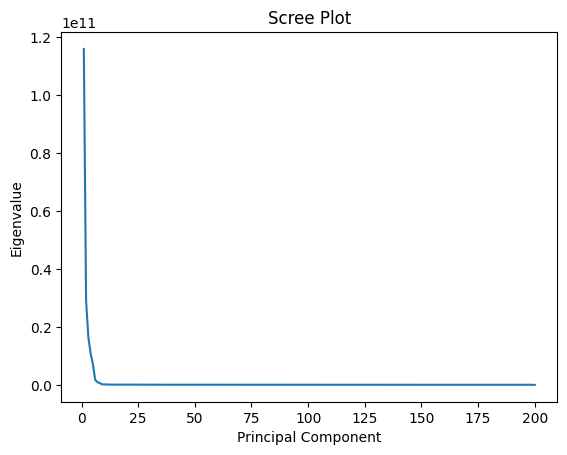


Ideal number of PCs: 42

Top 42 components. Cumulative Time taken in seconds 65.3443911075592



[I 2023-09-02 19:05:11,255] A new study created in memory with name: no-name-6a37ab7f-80b9-4297-abe2-099cb998142a


Calling fit transform to encode the labels. Cumulative Time taken in seconds 67.37024593353271

Now running Objective trials using OPTUNA.



C:\Users\saketadmin\AppData\Local\Temp\2\ipykernel_14012\2481846468.py:94: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  sgd_alpha = trial.suggest_loguniform('sgd_alpha', 1e-5, 1e2)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 61 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    1.4s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    1.4s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    1.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    1.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    1.4s finished
[I 2023-09-02 19:05:12,845] Trial 0 finished with value: 0.0 and parameters: {'classifier': 'SGD', 'sgd_loss': 'log_loss', 

The AUC ROC score is 0.9193877551020407

The AUC ROC score is beyond the threshold 0.9193877551020407



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.6s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.6s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s finished
[I 2023-09-02 19:05:13,593] Trial 1 finished with value: 0.8629603565564157 and parameters: {'classifier': 'SGD', 'sgd_loss': 'modified_huber', 'sgd_penalty': 'l2', 'sgd_alpha': 13.623577619370879, 'sgd_max_iter': 13760, 'sgd_tol': 0.009828098764695016}. Best is trial 1 with value: 0.8629603565564157.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 61 concurrent workers.


The AUC ROC score is 0.8258503401360544

Final Score from the objective function 0.8629603565564157



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    3.5s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    3.6s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    3.6s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    3.6s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    3.7s finished
[I 2023-09-02 19:07:22,940] Trial 2 finished with value: 0.0 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 2286, 'rf_max_depth': 20, 'rf_min_samples_split': 2, 'rf_min_samples_leaf': 7, 'rf_max_features': 'log2'}. Best is trial 1 with value: 0.8629603565564157.


The AUC ROC score is 0.9544217687074831

The AUC ROC score is beyond the threshold 0.9544217687074831



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 61 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    5.1s remaining:   12.9s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    5.1s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    5.1s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    5.1s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    5.2s finished
[I 2023-09-02 19:10:51,303] Trial 3 finished with value: 0.0 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 3674, 'rf_max_depth': 21, 'rf_min_samples_split': 2, 'rf_min_samples_leaf': 9, 'rf_max_features': 'log2'}. Best is trial 1 with value: 0.8629603565564157.


The AUC ROC score is 0.950971817298348

The AUC ROC score is beyond the threshold 0.950971817298348



C:\Users\saketadmin\AppData\Local\Temp\2\ipykernel_14012\2481846468.py:94: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  sgd_alpha = trial.suggest_loguniform('sgd_alpha', 1e-5, 1e2)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 61 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.2s finished
[I 2023-09-02 19:10:51,716] Trial 4 finished with value: 0.8375439831104855 and parameters: {'classifier': 'SGD', 'sgd_loss': 'modifi

The AUC ROC score is 0.8459183673469387

Final Score from the objective function 0.8375439831104855

The best hyperparams found: {'classifier': 'SGD', 'sgd_loss': 'modified_huber', 'sgd_penalty': 'l2', 'sgd_alpha': 13.623577619370879, 'sgd_max_iter': 13760, 'sgd_tol': 0.009828098764695016}
Best Classifier: SGD

Cumulative Time taken in seconds 407.8315863609314

Best hyper-parameters: {'sgd_loss': 'modified_huber', 'sgd_penalty': 'l2', 'sgd_alpha': 13.623577619370879, 'sgd_max_iter': 13760, 'sgd_tol': 0.009828098764695016}

The params: SGD {'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 13.623577619370879, 'max_iter': 13760, 'tol': 0.009828098764695016}

Model fit with best model and hyper parameters done!

Now doing predictions

Test accuracy from objective function approach: 0.840

Validation accuracy from objective function approach: 0.812


Now, plotting the output of training and saving models

Training accuracy: 0.91
Training recall: 0.82
Training precision: 0.99
Training AU

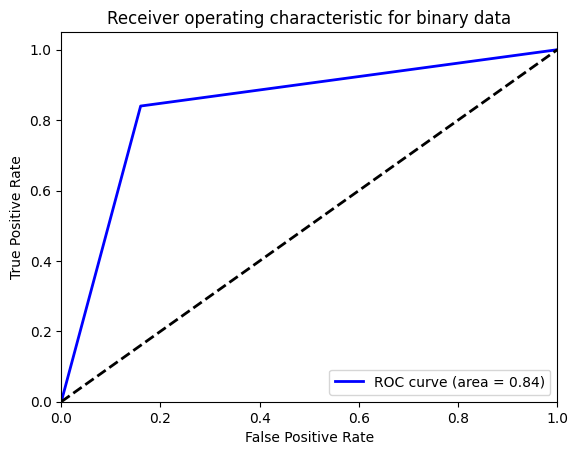


ROC AUC for Validation


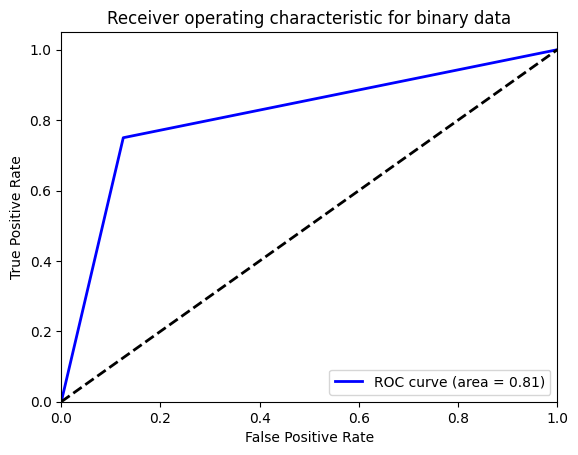


Printing how this model fairs for class PNEUMONIA for test


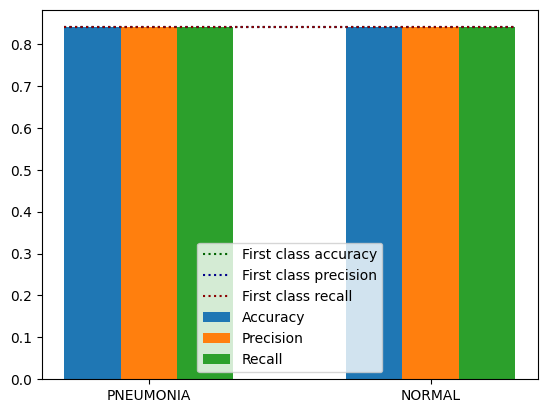


Printing how this model fairs for class PNEUMONIA for validation


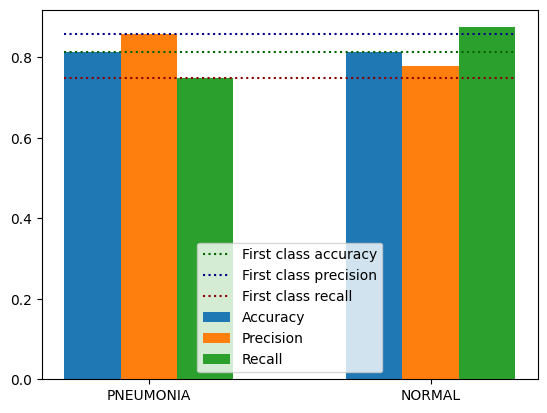


Confusion Matrix for Test


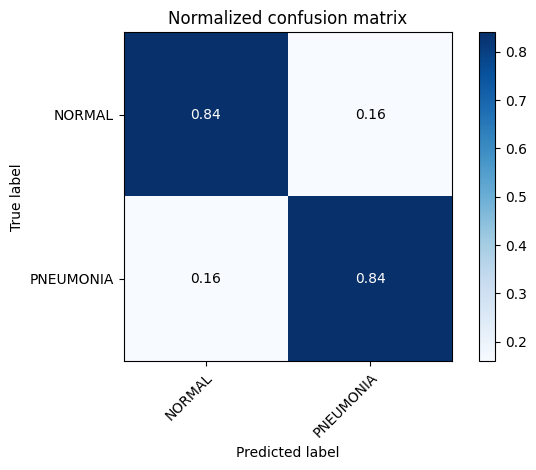


Confusion Matrix for Validation


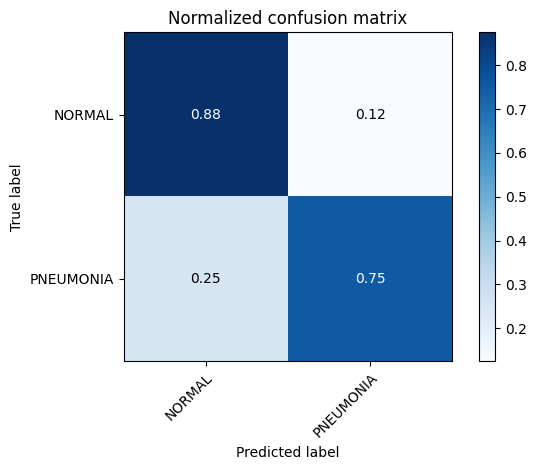


Memory Usage:
Current memory usage is 13136.434875MB; Peak was 22776.054041MB
The model may be overfitting because the difference between the training accuracy (0.91) and validation accuracy (0.84) is 0.07, which is greater than the threshold of 0.05.
Loading features from ./features500


Feature set sizes:
Training: (1000, 4018294)
Test: (624, 4018294)
Validation: (16, 4018294)

Features loaded. Cumulative Time taken in seconds 24.695274829864502

Co-variance matrix calculation. Cumulative Time taken in seconds 28.713603496551514



In [4]:
main_folder_path = './chest_xray'
parent_folder = './'
# objective_trial set to False must mean gridsrch set to True
PCAbasedanalysis(100, parent_folder, 150, 'four', 'SGD', 
                 screeapp = True, gridsrch = False, Strat = False, 
                 en_y = False, objective_trial = True, denoise = False)

Loading features from ./features500


Feature set sizes:
Training: (1000, 4018294)
Test: (624, 4018294)
Validation: (16, 4018294)

Features loaded. Cumulative Time taken in seconds 24.502930879592896

Co-variance matrix calculation. Cumulative Time taken in seconds 28.565422773361206

SVD processing . Cumulative Time taken in seconds 611.829975605011



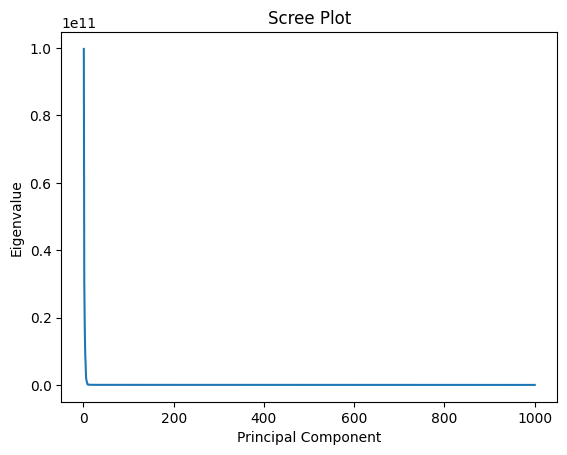


Ideal number of PCs: 239

Top 239 components. Cumulative Time taken in seconds 612.3362863063812



[I 2023-09-02 19:53:21,580] A new study created in memory with name: no-name-da998db4-1c43-4cdb-806f-da88d0415a35


Calling fit transform to encode the labels. Cumulative Time taken in seconds 619.786614894867

Now running Objective trials using OPTUNA.



C:\Users\saketadmin\AppData\Local\Temp\2\ipykernel_12732\2476190303.py:113: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  svc_c = trial.suggest_loguniform('svc_c', 1e-5, 1e10)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 61 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    1.7s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    1.7s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    1.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    1.7s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    1.7s finished
[I 2023-09-02 19:53:25,321] Trial 0 finished with value: 0.7048118666473159 and parameters: {'classifier': 'SVC', 'svc_c': 0.0004

The AUC ROC score is 0.882643671103302

Final Score from the objective function 0.7048118666473159



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 61 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:   15.9s remaining:   40.0s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:   16.0s remaining:   21.4s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:   16.0s remaining:   12.0s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:   16.1s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:   16.2s finished
[I 2023-09-02 19:57:02,741] Trial 1 finished with value: 0.0 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 2098, 'rf_max_depth': 14, 'rf_min_samples_split': 9, 'rf_min_samples_leaf': 5, 'rf_max_features': 'log2'}. Best is trial 0 with value: 0.7048118666473159.


The AUC ROC score is 0.9553848915086764

The AUC ROC score is beyond the threshold 0.9553848915086764



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 61 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    6.9s remaining:   17.5s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    7.0s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    7.0s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    7.0s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    7.3s finished
[I 2023-09-02 19:58:31,876] Trial 2 finished with value: 0.0 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 840, 'rf_max_depth': 15, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 4, 'rf_max_features': 'log2'}. Best is trial 0 with value: 0.7048118666473159.


The AUC ROC score is 0.9553258518245623

The AUC ROC score is beyond the threshold 0.9553258518245623



C:\Users\saketadmin\AppData\Local\Temp\2\ipykernel_12732\2476190303.py:113: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  svc_c = trial.suggest_loguniform('svc_c', 1e-5, 1e10)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 61 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.4s finished
[I 2023-09-02 19:58:33,809] Trial 3 finished with value: 0.49206772255274533 and parameters: {'classifier': 'SVC', 'svc_c': 7028770860.2951

The AUC ROC score is 0.49718577505722916

Final Score from the objective function 0.49206772255274533



C:\Users\saketadmin\AppData\Local\Temp\2\ipykernel_12732\2476190303.py:95: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  sgd_alpha = trial.suggest_loguniform('sgd_alpha', 1e-5, 1e2)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 61 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.03207850456237793s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:   10.7s finished
[I 2023-09-02 19:58:45,124]

The AUC ROC score is 0.8641292197630227

Final Score from the objective function 0.8740346117106681

The best hyperparams found: {'classifier': 'SGD', 'sgd_loss': 'log_loss', 'sgd_penalty': 'l1', 'sgd_alpha': 0.10986880176841844, 'sgd_max_iter': 32765, 'sgd_tol': 0.022130505284560942}
Best Classifier: SGD

Cumulative Time taken in seconds 943.3341658115387

Best hyper-parameters: {'sgd_loss': 'log_loss', 'sgd_penalty': 'l1', 'sgd_alpha': 0.10986880176841844, 'sgd_max_iter': 32765, 'sgd_tol': 0.022130505284560942}

The params: SGD {'loss': 'log_loss', 'penalty': 'l1', 'alpha': 0.10986880176841844, 'max_iter': 32765, 'tol': 0.022130505284560942}

Model fit with best model and hyper parameters done!

Now doing predictions

Test accuracy from objective function approach: 0.824

Validation accuracy from objective function approach: 1.000


Now, plotting the output of training and saving models

Training accuracy: 0.91
Training recall: 0.83
Training precision: 0.99
Training AUC-ROC: 0.91
Tes

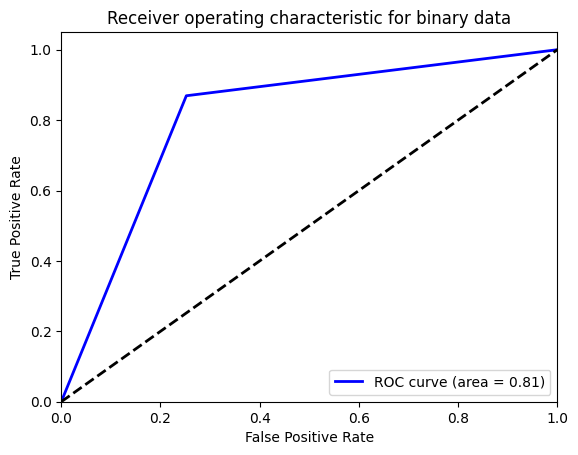


ROC AUC for Validation


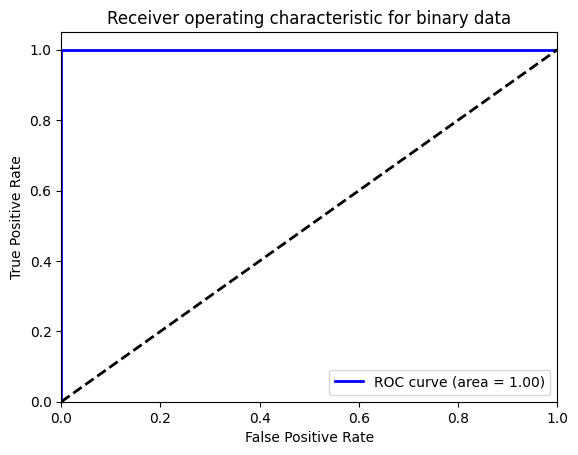


Printing how this model fairs for class PNEUMONIA for test


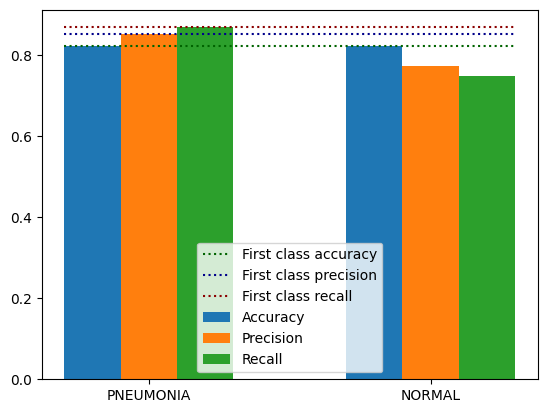


Printing how this model fairs for class PNEUMONIA for validation


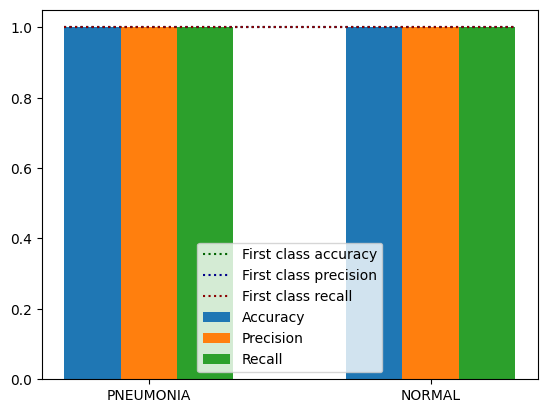


Confusion Matrix for Test


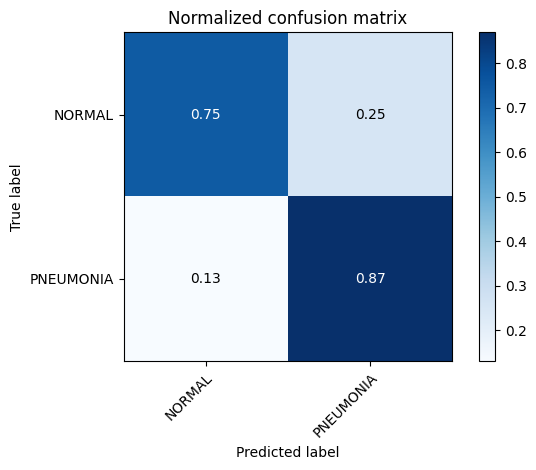


Confusion Matrix for Validation


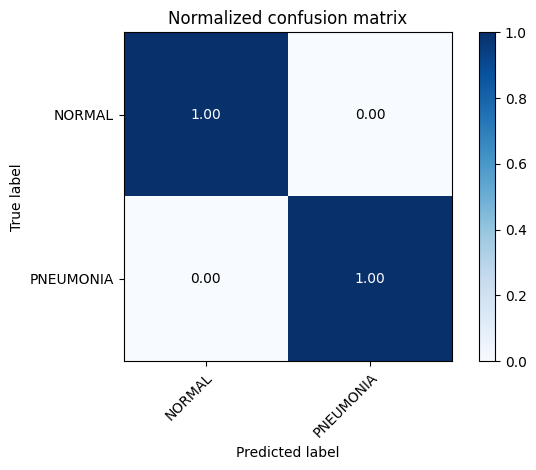


Memory Usage:
Current memory usage is 58532.390546MB; Peak was 106750.056057MB
The model may be overfitting because the difference between the training accuracy (0.91) and validation accuracy (0.82) is 0.09, which is greater than the threshold of 0.05.


In [4]:
main_folder_path = './chest_xray'
parent_folder = './'
# objective_trial set to False must mean gridsrch set to True
PCAbasedanalysis(500, parent_folder, 150, 'four', 'SGD', 
                 screeapp = True, gridsrch = False, Strat = False, 
                 en_y = False, objective_trial = True, denoise = False)

Loading features from ./features500


Feature set sizes:
Training: (1000, 4018294)
Test: (624, 4018294)
Validation: (16, 4018294)

Features loaded. Cumulative Time taken in seconds 24.35588002204895

Co-variance matrix calculation. Cumulative Time taken in seconds 28.41743540763855

SVD processing . Cumulative Time taken in seconds 611.5237085819244



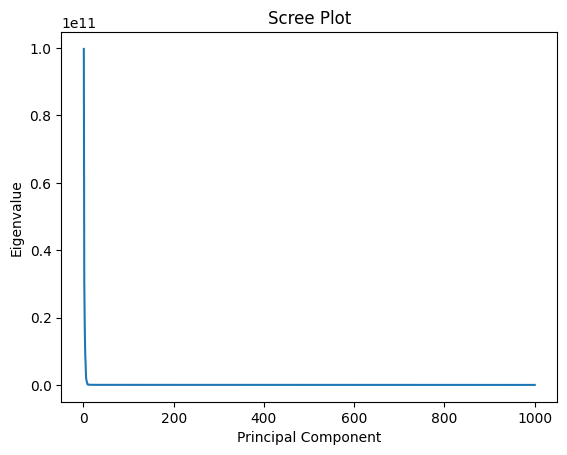


Ideal number of PCs: 239

Top 239 components. Cumulative Time taken in seconds 612.0262908935547



[I 2023-09-02 20:13:36,006] A new study created in memory with name: no-name-ae728f1a-ece4-467e-871d-c783d5460097


Calling fit transform to encode the labels. Cumulative Time taken in seconds 619.4463477134705

Now running Objective trials using OPTUNA.



C:\Users\saketadmin\AppData\Local\Temp\2\ipykernel_11656\1782647539.py:113: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  svc_c = trial.suggest_loguniform('svc_c', 1e-5, 1e10)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 61 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    1.7s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    1.7s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    1.7s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    1.7s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    1.7s finished
[I 2023-09-02 20:13:39,992] Trial 0 finished with value: 0.6308184227991807 and parameters: {'classifier': 'SVC', 'svc_c': 0.0145

The AUC ROC score is 0.6806685181511606

Final Score from the objective function 0.6308184227991807



C:\Users\saketadmin\AppData\Local\Temp\2\ipykernel_11656\1782647539.py:95: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  sgd_alpha = trial.suggest_loguniform('sgd_alpha', 1e-5, 1e2)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 61 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.6s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.6s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s finished
[I 2023-09-02 20:13:40,857] Trial 1 finished with value: 0.8690334997553308 and parameters: {'classifier': 'SGD', 'sgd_loss

The AUC ROC score is 0.8980689693717865

Final Score from the objective function 0.8690334997553308



C:\Users\saketadmin\AppData\Local\Temp\2\ipykernel_11656\1782647539.py:95: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  sgd_alpha = trial.suggest_loguniform('sgd_alpha', 1e-5, 1e2)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 61 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.6s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.6s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s finished
[I 2023-09-02 20:13:41,974] Trial 2 finished with value: 0.8595037591516465 and parameters: {'classifier': 'SGD', 'sgd_loss

The AUC ROC score is 0.8710596914822266

Final Score from the objective function 0.8595037591516465



C:\Users\saketadmin\AppData\Local\Temp\2\ipykernel_11656\1782647539.py:95: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  sgd_alpha = trial.suggest_loguniform('sgd_alpha', 1e-5, 1e2)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 61 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.6s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.6s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s finished
[I 2023-09-02 20:13:42,863] Trial 3 finished with value: 0.8634715245630739 and parameters: {'classifier': 'SGD', 'sgd_loss

The AUC ROC score is 0.867063492063492

Final Score from the objective function 0.8634715245630739



C:\Users\saketadmin\AppData\Local\Temp\2\ipykernel_11656\1782647539.py:113: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  svc_c = trial.suggest_loguniform('svc_c', 1e-5, 1e10)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 61 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.8s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.8s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.8s finished
[I 2023-09-02 20:13:45,414] Trial 4 finished with value: 0.0 and parameters: {'classifier': 'SVC', 'svc_c': 29744.579030629415, '

The AUC ROC score is 0.9823471344498919

The AUC ROC score is beyond the threshold 0.9823471344498919



C:\Users\saketadmin\AppData\Local\Temp\2\ipykernel_11656\1782647539.py:95: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  sgd_alpha = trial.suggest_loguniform('sgd_alpha', 1e-5, 1e2)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 61 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.6s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.6s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.7s finished
[I 2023-09-02 20:13:46,636] Trial 5 finished with value: 0.8805388664543594 and parameters: {'classifier': 'SGD', 'sgd_loss

The AUC ROC score is 0.8731276548177956

Final Score from the objective function 0.8805388664543594



C:\Users\saketadmin\AppData\Local\Temp\2\ipykernel_11656\1782647539.py:95: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  sgd_alpha = trial.suggest_loguniform('sgd_alpha', 1e-5, 1e2)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 61 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.6s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.6s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s finished
[I 2023-09-02 20:13:47,699] Trial 6 finished with value: 0.8815730924005573 and parameters: {'classifier': 'SGD', 'sgd_loss

The AUC ROC score is 0.8851861167002013

Final Score from the objective function 0.8815730924005573



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 61 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    4.7s remaining:   12.0s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    4.8s remaining:    6.4s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    4.8s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    4.8s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    4.9s finished
[I 2023-09-02 20:14:48,398] Trial 7 finished with value: 0.0 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 594, 'rf_max_depth': 17, 'rf_min_samples_split': 3, 'rf_min_samples_leaf': 8, 'rf_max_features': 'log2'}. Best is trial 6 with value: 0.8815730924005573.


The AUC ROC score is 0.9515370784960153

The AUC ROC score is beyond the threshold 0.9515370784960153



C:\Users\saketadmin\AppData\Local\Temp\2\ipykernel_11656\1782647539.py:95: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  sgd_alpha = trial.suggest_loguniform('sgd_alpha', 1e-5, 1e2)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 61 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0370635986328125s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.6s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s finished
[I 2023-09-02 20:14:49,253] 

The AUC ROC score is 0.8841940532081379

Final Score from the objective function 0.8720930868818194



C:\Users\saketadmin\AppData\Local\Temp\2\ipykernel_11656\1782647539.py:113: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  svc_c = trial.suggest_loguniform('svc_c', 1e-5, 1e10)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 61 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.16293811798095703s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.1s finished
[I 2023-09-02 20:14:50,563] Trial

The AUC ROC score is 0.6133750861979388

Final Score from the objective function 0.5976817601495246

The best hyperparams found: {'classifier': 'SGD', 'sgd_loss': 'log_loss', 'sgd_penalty': 'elasticnet', 'sgd_alpha': 0.000128058945107182, 'sgd_max_iter': 39594, 'sgd_tol': 0.09963547596828681}
Best Classifier: SGD

Cumulative Time taken in seconds 694.0033128261566

Best hyper-parameters: {'sgd_loss': 'log_loss', 'sgd_penalty': 'elasticnet', 'sgd_alpha': 0.000128058945107182, 'sgd_max_iter': 39594, 'sgd_tol': 0.09963547596828681}

The params: SGD {'loss': 'log_loss', 'penalty': 'elasticnet', 'alpha': 0.000128058945107182, 'max_iter': 39594, 'tol': 0.09963547596828681}

Model fit with best model and hyper parameters done!

Now doing predictions

Test accuracy from objective function approach: 0.822

Validation accuracy from objective function approach: 0.875


Now, plotting the output of training and saving models

Training accuracy: 0.94
Training recall: 0.90
Training precision: 0.98
Tr

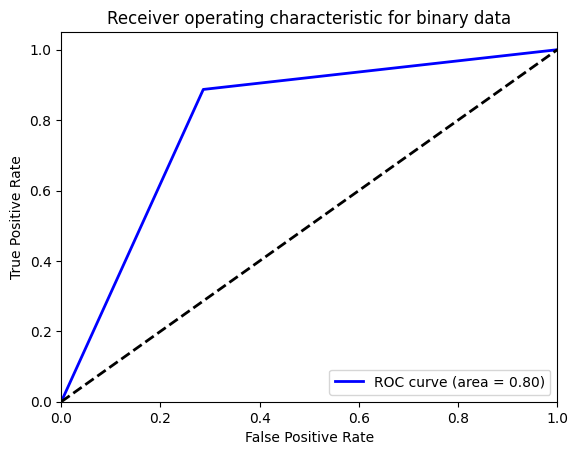


ROC AUC for Validation


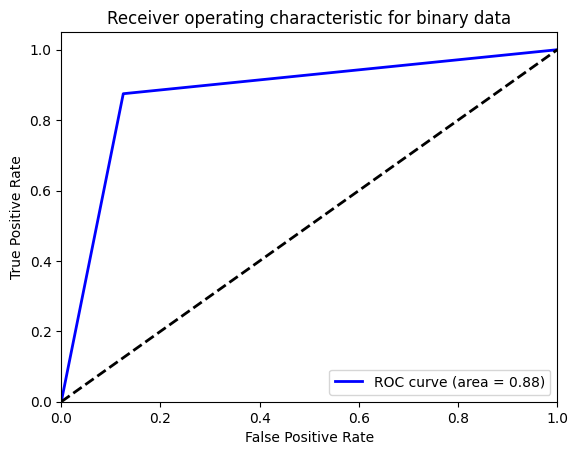


Printing how this model fairs for class PNEUMONIA for test


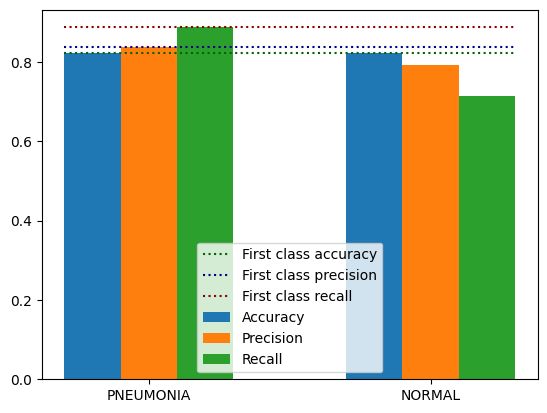


Printing how this model fairs for class PNEUMONIA for validation


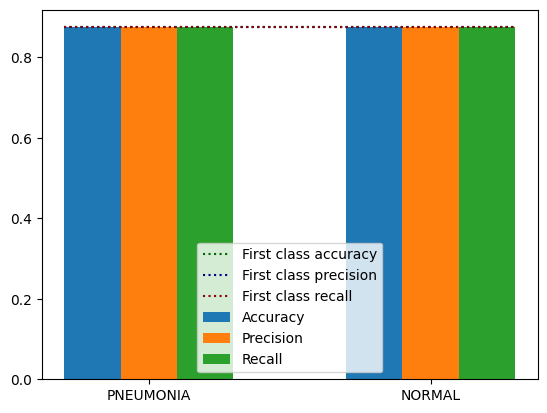


Confusion Matrix for Test


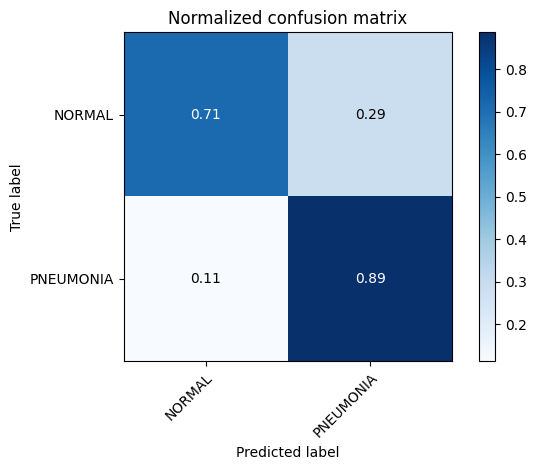


Confusion Matrix for Validation


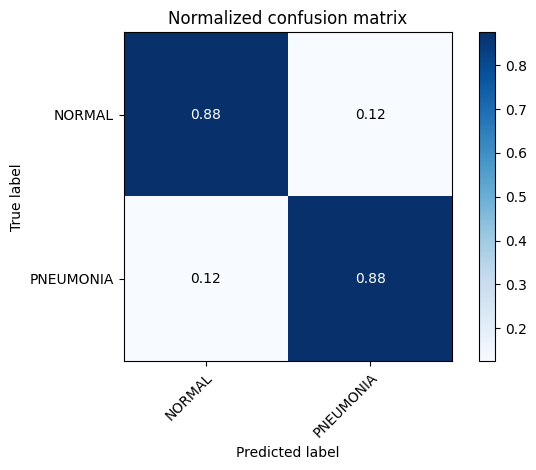


Memory Usage:
Current memory usage is 58532.485635MB; Peak was 106750.056625MB
The model may be overfitting because the difference between the training accuracy (0.94) and validation accuracy (0.82) is 0.12, which is greater than the threshold of 0.05.

All completed! Cumulative Time taken in seconds 697.1376330852509

Loading features from ./features1000



In [4]:
main_folder_path = './chest_xray'
parent_folder = './'
# objective_trial set to False must mean gridsrch set to True
PCAbasedanalysis(500, parent_folder, 150, 'four', 'SGD', 
                 screeapp = True, gridsrch = False, Strat = False, 
                 en_y = False, objective_trial = True, denoise = False)

Loading features from ./features1000


Feature set sizes:
Training: (2000, 4018294)
Test: (624, 4018294)
Validation: (16, 4018294)

Features loaded. Cumulative Time taken in seconds 40.54073977470398

Co-variance matrix calculation. Cumulative Time taken in seconds 48.83466601371765

SVD processing . Cumulative Time taken in seconds 1270.1206395626068



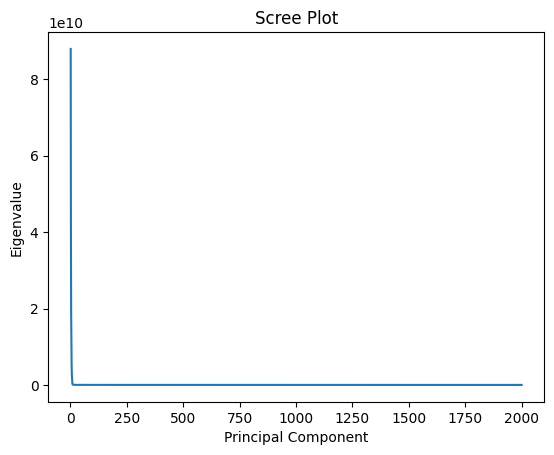


Ideal number of PCs: 465

Top 465 components. Cumulative Time taken in seconds 1270.8352704048157



[I 2023-09-02 20:38:37,441] A new study created in memory with name: no-name-13a6b9df-31a3-4e2f-901f-0a10210ea6fc


Calling fit transform to encode the labels. Cumulative Time taken in seconds 1284.9974687099457

Now running Objective trials using OPTUNA.



C:\Users\saketadmin\AppData\Local\Temp\2\ipykernel_6460\1782647539.py:95: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  sgd_alpha = trial.suggest_loguniform('sgd_alpha', 1e-5, 1e2)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 61 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    1.4s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    1.4s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    1.4s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    1.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    1.5s finished
[I 2023-09-02 20:38:39,402] Trial 0 finished with value: 0.0 and parameters: {'classifier': 'SGD', 'sgd_loss': 'modified_hub

The AUC ROC score is 0.9045356052398305

The AUC ROC score is beyond the threshold 0.9045356052398305



C:\Users\saketadmin\AppData\Local\Temp\2\ipykernel_6460\1782647539.py:113: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  svc_c = trial.suggest_loguniform('svc_c', 1e-5, 1e10)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 61 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    1.7s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    1.7s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    1.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    1.7s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    1.7s finished
[I 2023-09-02 20:38:49,185] Trial 1 finished with value: 0.0 and parameters: {'classifier': 'SVC', 'svc_c': 0.07496137194649308, '

The AUC ROC score is 0.912119324583621

The AUC ROC score is beyond the threshold 0.912119324583621



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 61 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:  2.8min remaining:  7.1min
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:  2.8min remaining:  3.8min
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:  2.9min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:  2.9min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:  2.9min finished
[I 2023-09-02 21:03:53,336] Trial 2 finished with value: 0.0 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 3861, 'rf_max_depth': 31, 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 9, 'rf_max_features': 'sqrt'}. Best is trial 0 with value: 0.0.


The AUC ROC score is 0.9703985072349103

The AUC ROC score is beyond the threshold 0.9703985072349103



C:\Users\saketadmin\AppData\Local\Temp\2\ipykernel_6460\1782647539.py:95: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  sgd_alpha = trial.suggest_loguniform('sgd_alpha', 1e-5, 1e2)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 61 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    1.7s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    1.7s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    1.7s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    1.7s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    1.9s finished
[I 2023-09-02 21:03:57,055] Trial 3 finished with value: 0.0 and parameters: {'classifier': 'SGD', 'sgd_loss': 'log_loss', '

The AUC ROC score is 0.9175296534451466

The AUC ROC score is beyond the threshold 0.9175296534451466



C:\Users\saketadmin\AppData\Local\Temp\2\ipykernel_6460\1782647539.py:95: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  sgd_alpha = trial.suggest_loguniform('sgd_alpha', 1e-5, 1e2)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 61 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:  1.6min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:  2.3min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:  2.3min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:  2.3min remaining:   56.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:  2.4min finished
C:\Users\saketadmin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:7

The AUC ROC score is 0.7386029463494251

Final Score from the objective function 0.7779813897493659



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:   35.1s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:   35.3s remaining:   47.1s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:   35.4s remaining:   26.5s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:   35.6s remaining:   14.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:   35.9s finished
[I 2023-09-02 21:27:59,602] Trial 5 finished with value: 0.0 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 1783, 'rf_max_depth': 19, 'rf_min_samples_split': 3, 'rf_min_samples_leaf': 9, 'rf_max_features': 'log2'}. Best is trial 4 with value: 0.7779813897493659.


The AUC ROC score is 0.9420146484068478

The AUC ROC score is beyond the threshold 0.9420146484068478



C:\Users\saketadmin\AppData\Local\Temp\2\ipykernel_6460\1782647539.py:95: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  sgd_alpha = trial.suggest_loguniform('sgd_alpha', 1e-5, 1e2)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 61 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    1.5s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    1.5s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    1.5s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    1.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    1.5s finished
[I 2023-09-02 21:28:02,268] Trial 6 finished with value: 0.8975269232867454 and parameters: {'classifier': 'SGD', 'sgd_loss'

The AUC ROC score is 0.8915450746436663

Final Score from the objective function 0.8975269232867454



C:\Users\saketadmin\AppData\Local\Temp\2\ipykernel_6460\1782647539.py:95: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  sgd_alpha = trial.suggest_loguniform('sgd_alpha', 1e-5, 1e2)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 61 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.7s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.7s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.8s finished
[I 2023-09-02 21:28:04,480] Trial 7 finished with value: 0.0 and parameters: {'classifier': 'SGD', 'sgd_loss': 'modified_hub

The AUC ROC score is 0.9215256574411504

The AUC ROC score is beyond the threshold 0.9215256574411504



C:\Users\saketadmin\AppData\Local\Temp\2\ipykernel_6460\1782647539.py:95: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  sgd_alpha = trial.suggest_loguniform('sgd_alpha', 1e-5, 1e2)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 61 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.6s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.6s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s finished
[I 2023-09-02 21:28:05,632] Trial 8 finished with value: 0.0 and parameters: {'classifier': 'SGD', 'sgd_loss': 'modified_hub

The AUC ROC score is 0.91103614695164

The AUC ROC score is beyond the threshold 0.91103614695164



C:\Users\saketadmin\AppData\Local\Temp\2\ipykernel_6460\1782647539.py:113: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  svc_c = trial.suggest_loguniform('svc_c', 1e-5, 1e10)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 61 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    3.4s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    3.5s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    3.5s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    3.5s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    3.6s finished
[I 2023-09-02 21:28:28,372] Trial 9 finished with value: 0.49974937343358394 and parameters: {'classifier': 'SVC', 'svc_c': 0.0006

The AUC ROC score is 0.5

Final Score from the objective function 0.49974937343358394

The best hyperparams found: {'classifier': 'SGD', 'sgd_loss': 'modified_huber', 'sgd_penalty': 'elasticnet', 'sgd_alpha': 0.010472536535417173, 'sgd_max_iter': 16586, 'sgd_tol': 0.09640817691989553}
Best Classifier: SGD

Cumulative Time taken in seconds 4275.931656360626

Best hyper-parameters: {'sgd_loss': 'modified_huber', 'sgd_penalty': 'elasticnet', 'sgd_alpha': 0.010472536535417173, 'sgd_max_iter': 16586, 'sgd_tol': 0.09640817691989553}

The params: SGD {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.010472536535417173, 'max_iter': 16586, 'tol': 0.09640817691989553}

Model fit with best model and hyper parameters done!

Now doing predictions

Test accuracy from objective function approach: 0.816

Validation accuracy from objective function approach: 0.875


Now, plotting the output of training and saving models

Training accuracy: 0.94
Training recall: 0.90
Training precision: 0.9

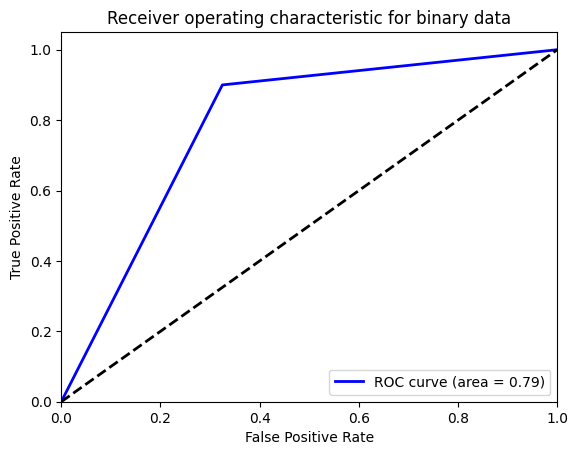


ROC AUC for Validation


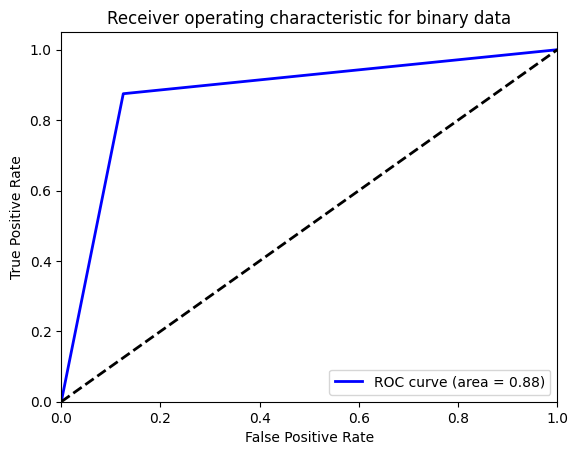


Printing how this model fairs for class PNEUMONIA for test


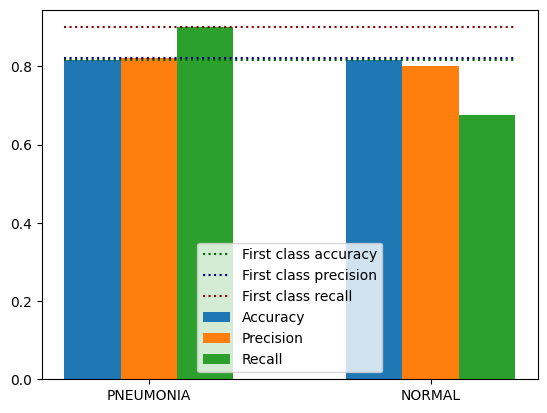


Printing how this model fairs for class PNEUMONIA for validation


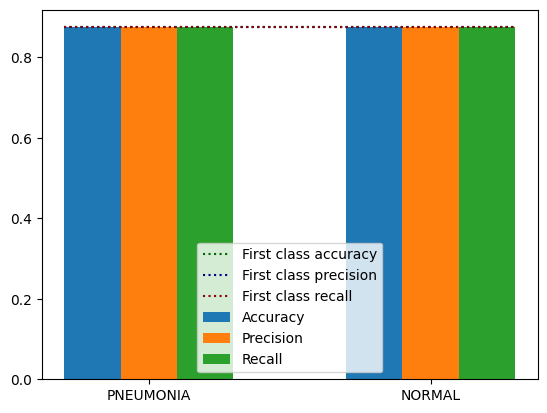


Confusion Matrix for Test


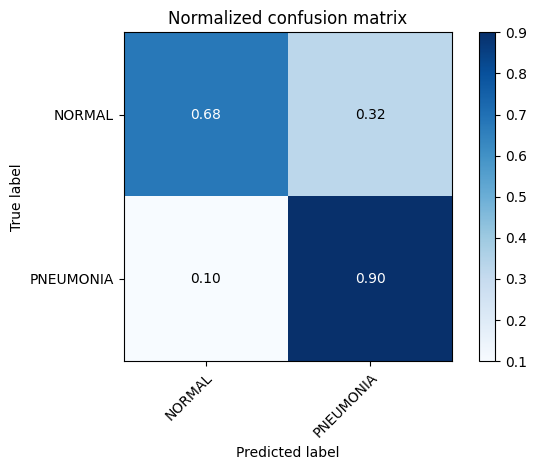


Confusion Matrix for Validation


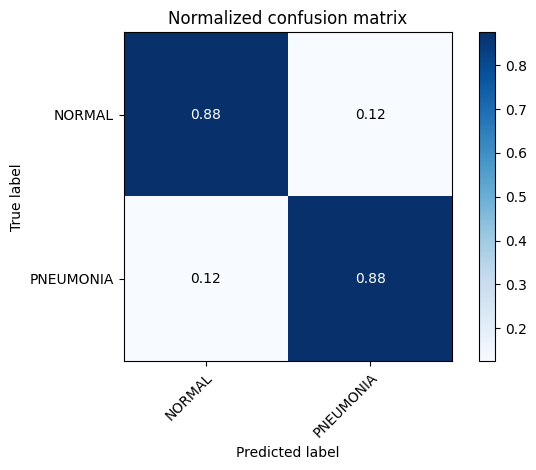


Memory Usage:
Current memory usage is 106767.730213MB; Peak was 203213.1559MB
The model may be overfitting because the difference between the training accuracy (0.94) and validation accuracy (0.82) is 0.13, which is greater than the threshold of 0.05.

All completed! Cumulative Time taken in seconds 4279.149178266525



In [4]:
main_folder_path = './chest_xray'
parent_folder = './'
# objective_trial set to False must mean gridsrch set to True
# Complex Combo feature being used - C-Hist + LBP + HOG + Contour + Edges
PCAbasedanalysis(1000, parent_folder, 150, 'four', 'SGD', 
                 screeapp = True, gridsrch = False, Strat = False, 
                 en_y = False, objective_trial = True)

#### SGD Optimization Modeling

In this section we use GridSearchCV to find the nest params for SGD Optimization algorithm class on the PCA dataset and try to reduce the overfitting we observed earlier.


Loading features from ./features500


Feature set sizes:
Training: (1000, 4018294)
Test: (624, 4018294)
Validation: (16, 4018294)

Features loaded. Cumulative Time taken in seconds 220.11403226852417

Co-variance matrix calculation. Cumulative Time taken in seconds 223.65370345115662

SVD processing . Cumulative Time taken in seconds 623.9292032718658

Top 150 components. Cumulative Time taken in seconds 623.9292032718658

Now running SVC fit. Cumulative Time taken in seconds 631.8049941062927

Fitting 3 folds for each of 24300 candidates, totalling 72900 fits
Grid search Cumulative Time taken in seconds 940.8744316101074

Now selecting the chosen params based on metrics and retraining the model on those


Top 5 Valid Params
                                                  params  mean_test_score
6392   {'alpha': 0.1, 'eta0': 0.001, 'l1_ratio': 0.25...         0.925992
6486   {'alpha': 0.1, 'eta0': 0.001, 'l1_ratio': 0.5,...         0.923996
7272   {'alpha': 0.1, 'eta0': 0.001, 'l1_ra

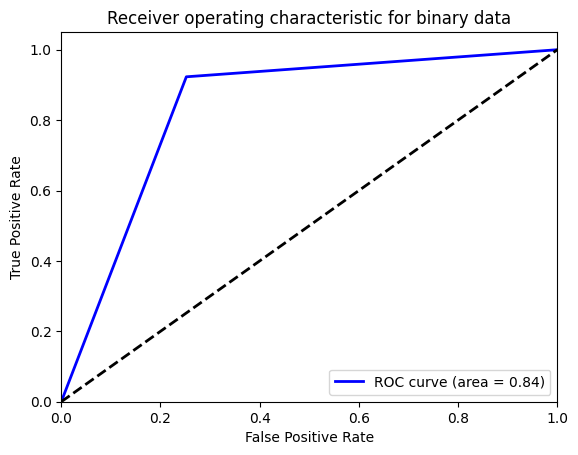


ROC AUC for Validation


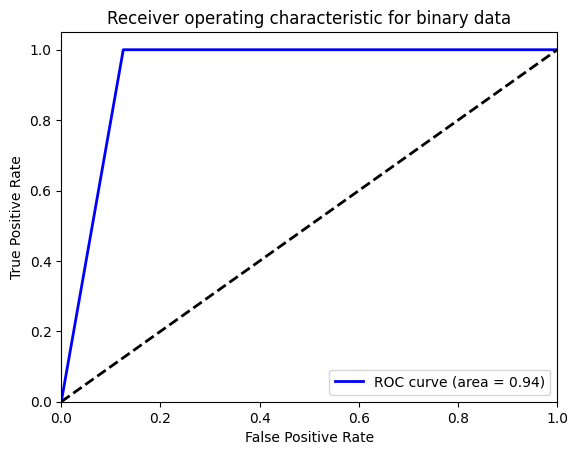


Printing how this model fairs for class PNEUMONIA for test


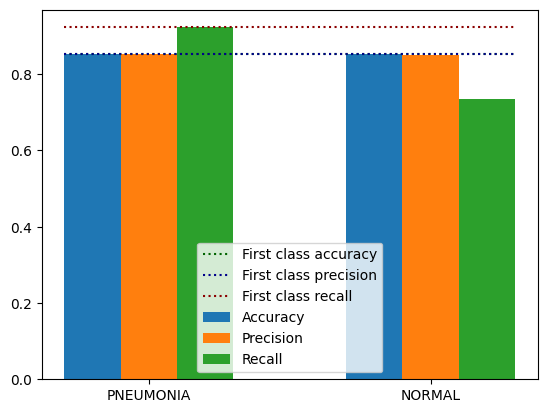


Printing how this model fairs for class PNEUMONIA for validation


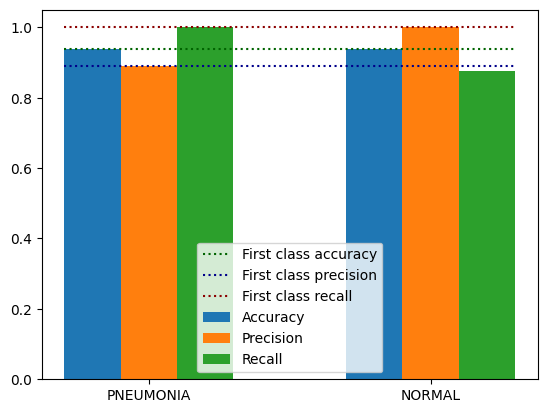


Confusion Matrix for Test


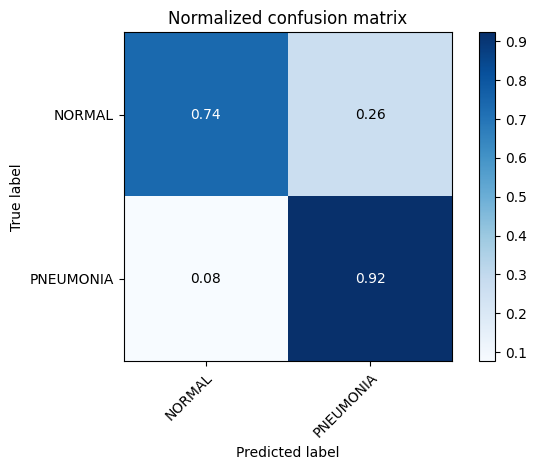


Confusion Matrix for Validation


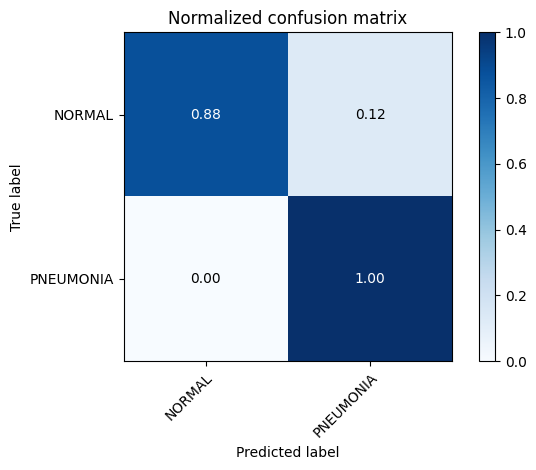


Memory Usage:
Current memory usage is 58551.269692MB; Peak was 106750.045303MB
Loading features from ./features500


Feature set sizes:
Training: (1000, 4018294)
Test: (624, 4018294)
Validation: (16, 4018294)

Features loaded. Cumulative Time taken in seconds 22.882405996322632

Co-variance matrix calculation. Cumulative Time taken in seconds 26.58222484588623



In [12]:
main_folder_path = './chest_xray'
parent_folder = './'

PCAbasedanalysis(500, parent_folder, 150, 'four', 'SGD', 
                 screeapp = False, gridsrch = True, Strat = False)

Loading features from ./features500


Feature set sizes:
Training: (1000, 4018294)
Test: (624, 4018294)
Validation: (16, 4018294)

Features loaded. Cumulative Time taken in seconds 23.56836247444153

Co-variance matrix calculation. Cumulative Time taken in seconds 27.29624032974243

SVD processing . Cumulative Time taken in seconds 448.53566431999207

Top 150 components. Cumulative Time taken in seconds 448.53566431999207

Now running SVC fit. Cumulative Time taken in seconds 456.64457392692566

Calling fit transform to encode the labels. Cumulative Time taken in seconds 456.64457392692566

Fitting 3 folds for each of 19440 candidates, totalling 58320 fits
Grid search Cumulative Time taken in seconds 868.5767576694489

Now selecting the chosen params based on metrics and retraining the model on those


Top 5 Valid Params
                                                  params  mean_test_score
3655   {'alpha': 0.01, 'eta0': 0.1, 'l1_ratio': 0.5, ...         0.923996
11470  {'alpha': 1,

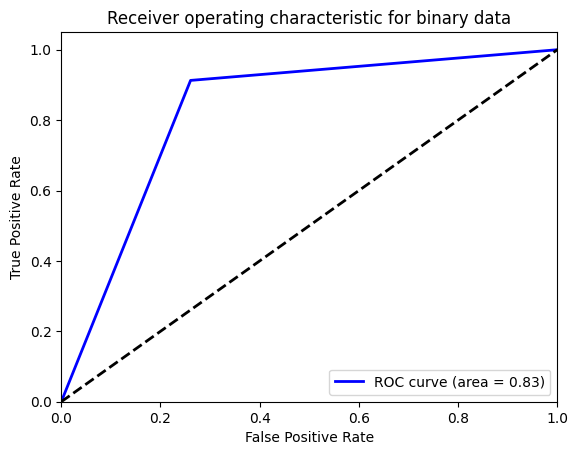


ROC AUC for Validation


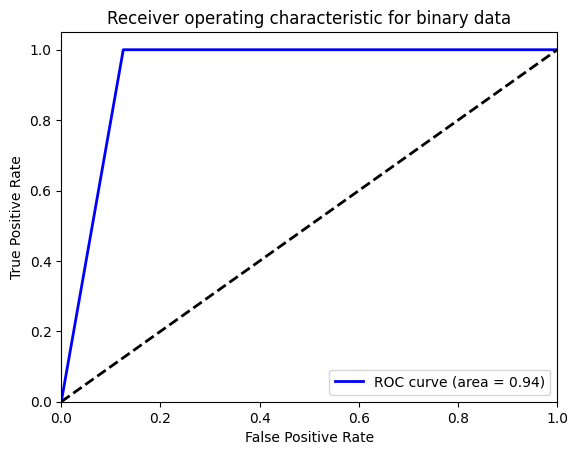


Printing how this model fairs for class PNEUMONIA for validation


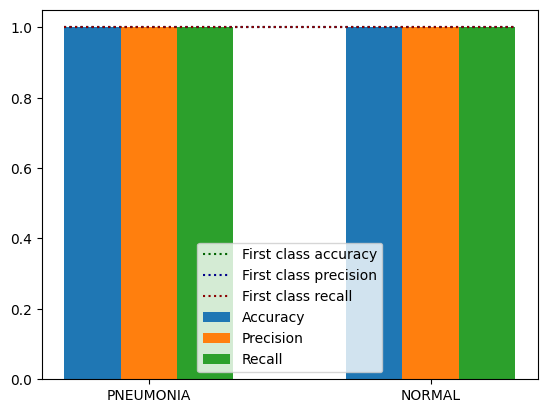


Printing how this model fairs for class PNEUMONIA for test


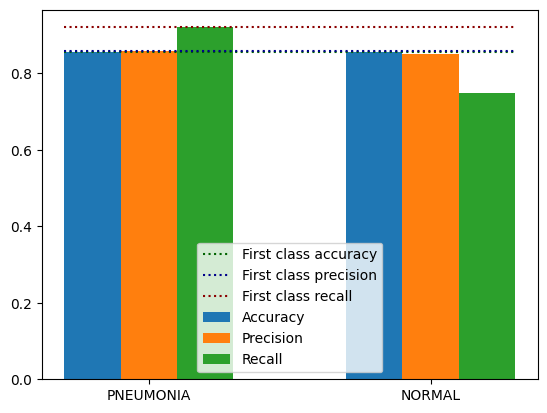


Confusion Matrix for Test


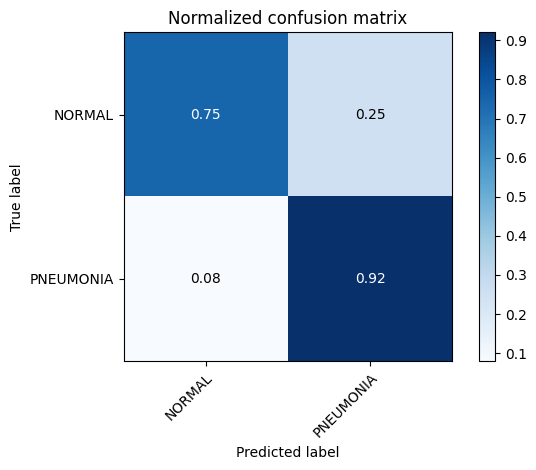


Confusion Matrix for Validation


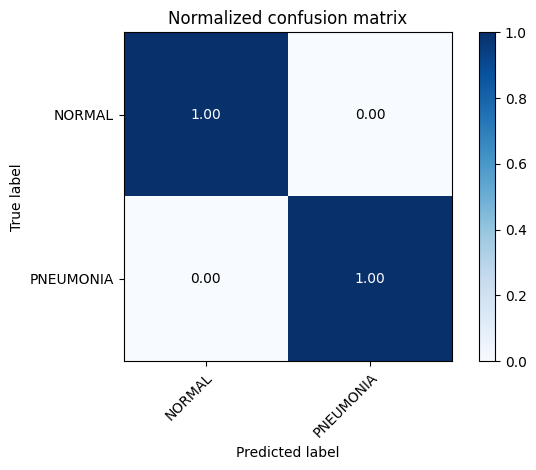


Memory Usage:
Current memory usage is 58546.935763MB; Peak was 106750.045695MB
Loading features from ./features1000



In [11]:
main_folder_path = './chest_xray'
parent_folder = './'

PCAbasedanalysis(500, parent_folder, 150, 'four', 'SGD', 
                 screeapp = False, gridsrch = True, Strat = False)

Loading features from ./features1000


Feature set sizes:
Training: (2000, 4018294)
Test: (624, 4018294)
Validation: (16, 4018294)

Features loaded. Cumulative Time taken in seconds 341.7417221069336

Co-variance matrix calculation. Cumulative Time taken in seconds 349.3867928981781

SVD processing . Cumulative Time taken in seconds 1443.7333126068115

Top 150 components. Cumulative Time taken in seconds 1443.7333126068115

Now running SVC fit. Cumulative Time taken in seconds 1454.7821698188782

Fitting 3 folds for each of 19440 candidates, totalling 58320 fits
Grid search Cumulative Time taken in seconds 2167.222937822342

Now selecting the chosen params based on metrics and retraining the model on those


Top 5 Valid Params
                                                  params  mean_test_score
7264   {'alpha': 0.1, 'eta0': 0.1, 'l1_ratio': 0.0, '...             0.93
6149   {'alpha': 0.1, 'eta0': 0.001, 'l1_ratio': 0.25...             0.93
10270  {'alpha': 1, 'eta0': 0.001, 'l1_ra

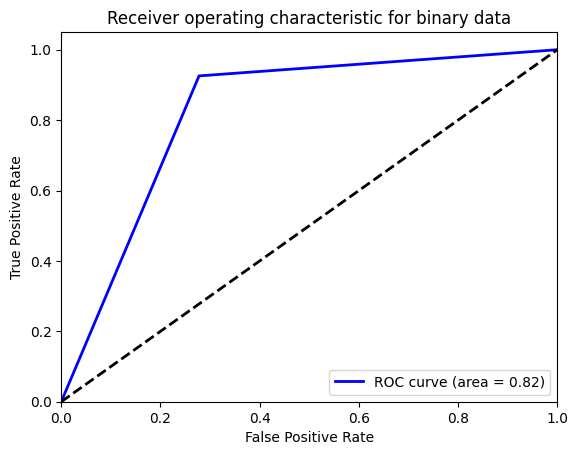


ROC AUC for Validation


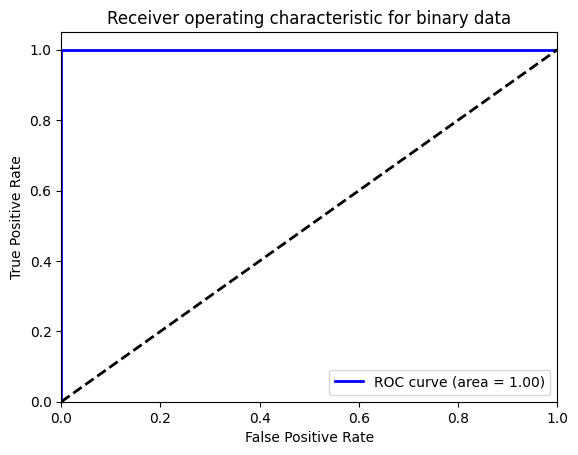


Printing how this model fairs for class PNEUMONIA for test


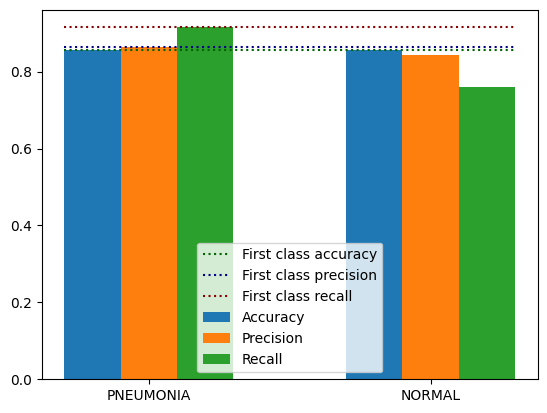


Printing how this model fairs for class PNEUMONIA for validation


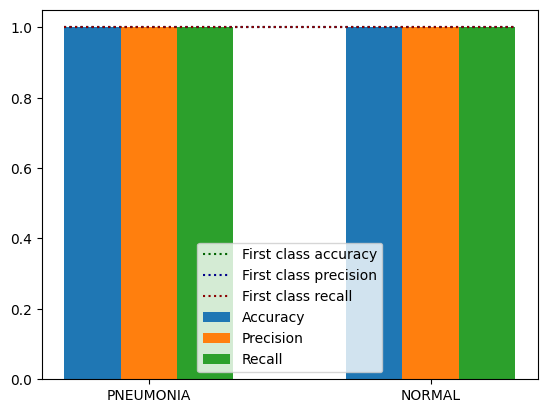


Confusion Matrix for Test


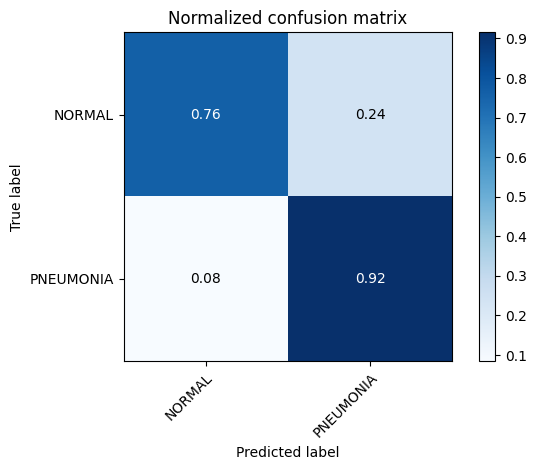


Confusion Matrix for Validation


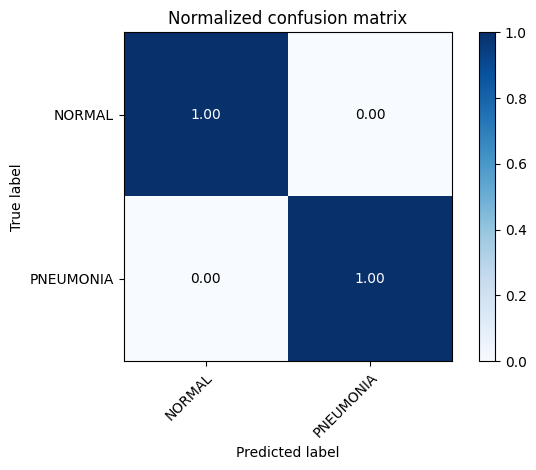


Memory Usage:
Current memory usage is 106778.16739MB; Peak was 203213.146007MB


In [11]:
main_folder_path = './chest_xray'
parent_folder = './'

PCAbasedanalysis(1000, parent_folder, 150, 'four', 'SGD', 
                 screeapp = False, gridsrch = True, Strat = False)

#### SVM/SVC Optimization Modeling
In this section we use GridSearchCV to find the nest params for SVM Optimization algorithm class on the PCA dataset and try to reduce the overfitting we observed earlier.
I have observed that simplified models with simplified HYper Parameter Grid is more likely to build a `Generalizable` model here.


Loading features from ./features1000


Feature set sizes:
Training: (2000, 4018294)
Test: (624, 4018294)
Validation: (16, 4018294)

Features loaded. Cumulative Time taken in seconds 349.8340091705322

Co-variance matrix calculation. Cumulative Time taken in seconds 357.46832275390625

SVD processing . Cumulative Time taken in seconds 1452.4162735939026



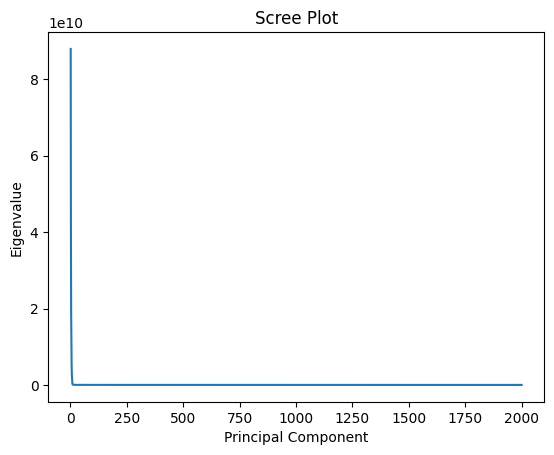


Ideal number of PCs: 465

Top 465 components. Cumulative Time taken in seconds 1452.9662125110626

Now running SVC fit. Cumulative Time taken in seconds 1466.7768449783325

Fitting 3 folds for each of 23760 candidates, totalling 71280 fits
Grid search Cumulative Time taken in seconds 10279.715799808502

Now selecting the chosen params based on metrics and retraining the model on those


Top 5 Valid Params
                                               params  mean_test_score
0   {'C': 1, 'class_weight': 'balanced', 'coef0': ...         0.884994
83  {'C': 1, 'class_weight': 'balanced', 'coef0': ...         0.884994
97  {'C': 1, 'class_weight': 'balanced', 'coef0': ...         0.884994
96  {'C': 1, 'class_weight': 'balanced', 'coef0': ...         0.884994
95  {'C': 1, 'class_weight': 'balanced', 'coef0': ...         0.884994


Best parameters: {'C': 1, 'class_weight': 'balanced', 'coef0': -1.0, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True, 'shrinking': True, 'tol'

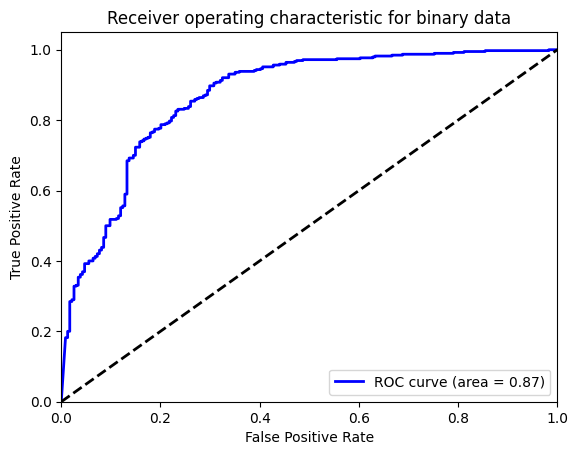


ROC AUC for Validation


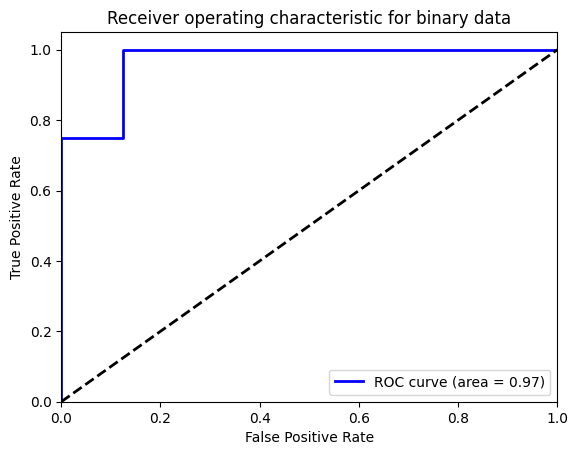


Printing how this model fairs for class PNEUMONIA for test


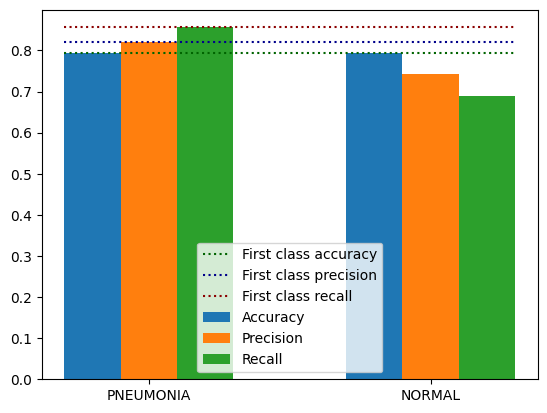


Printing how this model fairs for class PNEUMONIA for validation


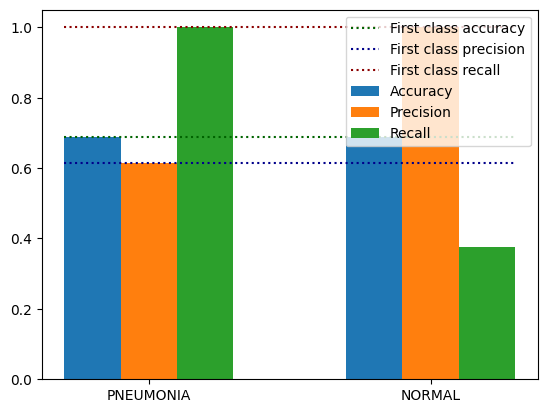


Confusion Matrix for Test


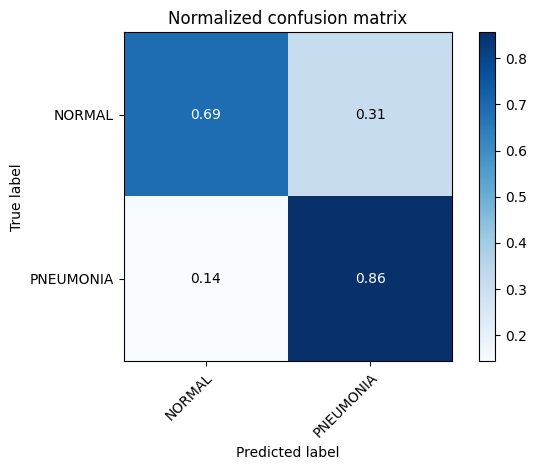


Confusion Matrix for Validation


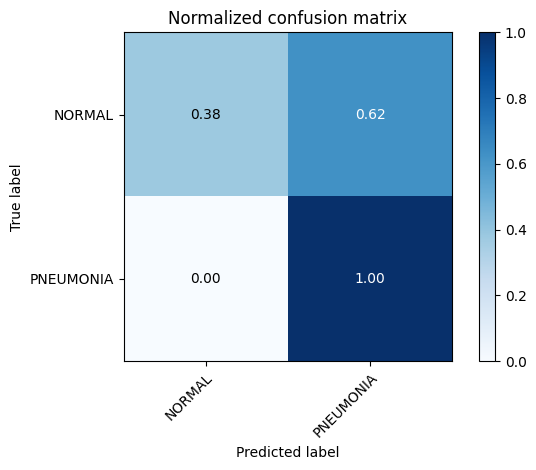


Memory Usage:
Current memory usage is 106786.958054MB; Peak was 203213.146062MB
The model may be overfitting because the difference between the training accuracy (0.92) and validation accuracy (0.79) is 0.12, which is greater than the threshold of 0.05.


In [4]:
main_folder_path = './chest_xray'
parent_folder = './'

PCAbasedanalysis(1000, parent_folder, 150, 'four', 'SVM', 
                 screeapp = True, gridsrch = True, Strat = False)

Loading features from ./features500


Feature set sizes:
Training: (1000, 4018294)
Test: (624, 4018294)
Validation: (16, 4018294)

Features loaded. Cumulative Time taken in seconds 23.28279447555542

Co-variance matrix calculation. Cumulative Time taken in seconds 27.05053424835205

SVD processing . Cumulative Time taken in seconds 450.7149889469147

Top 150 components. Cumulative Time taken in seconds 450.7149889469147

Now running SVC fit. Cumulative Time taken in seconds 458.69847202301025

Fitting 3 folds for each of 23760 candidates, totalling 71280 fits
Grid search Cumulative Time taken in seconds 838.5881102085114

Now selecting the chosen params based on metrics and retraining the model on those


Top 5 Valid Params
                                               params  mean_test_score
0   {'C': 1, 'class_weight': 'balanced', 'coef0': ...         0.856983
83  {'C': 1, 'class_weight': 'balanced', 'coef0': ...         0.856983
97  {'C': 1, 'class_weight': 'balanced', 'coef0': ...

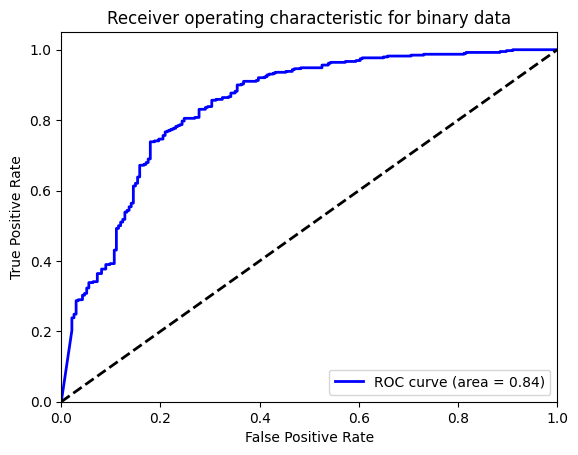


ROC AUC for Validation


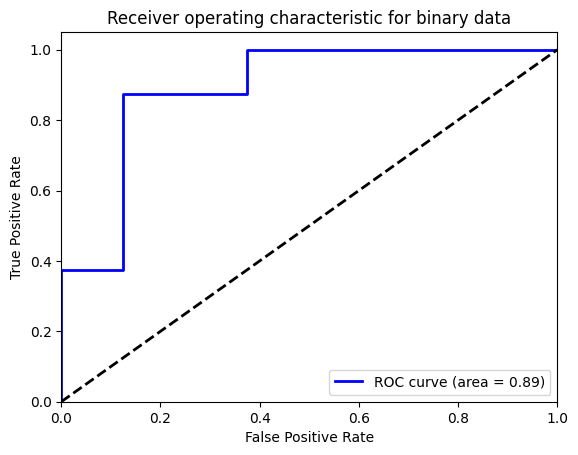


Printing how this model fairs for class PNEUMONIA for test


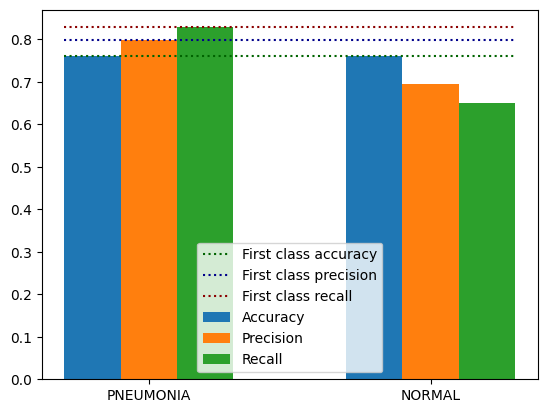


Printing how this model fairs for class PNEUMONIA for validation


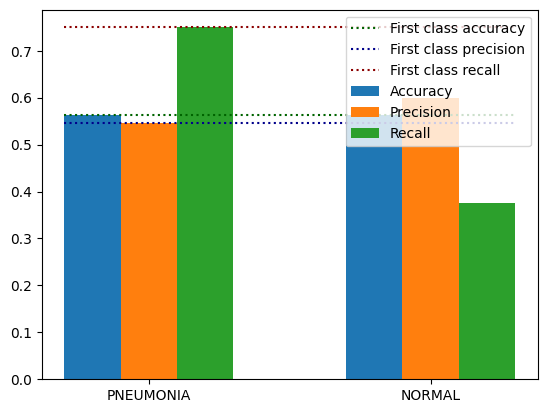


Confusion Matrix for Test


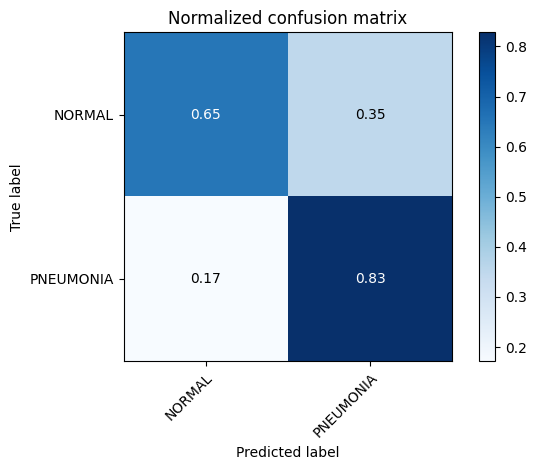


Confusion Matrix for Validation


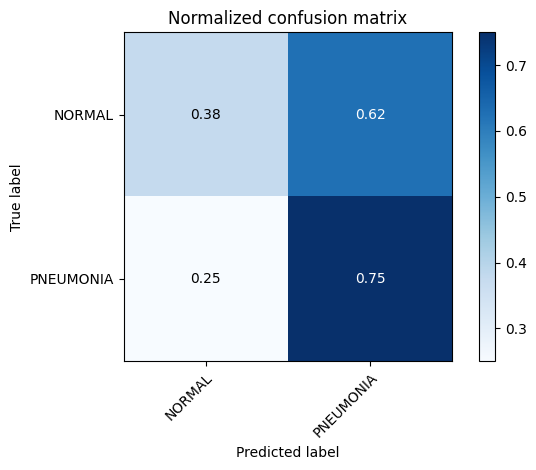


Memory Usage:
Current memory usage is 58546.233125MB; Peak was 106750.045413MB
Loading features from ./features1000



In [7]:
main_folder_path = './chest_xray'
parent_folder = './'

PCAbasedanalysis(500, parent_folder, 150, 'four', 'SVM', 
                 screeapp = False, gridsrch = True, Strat = False)

Loading features from ./features500


Feature set sizes:
Training: (1000, 4018294)
Test: (624, 4018294)
Validation: (16, 4018294)
Features loaded. Cumulative Time taken in seconds 22.756098985671997

Co-variance matrix calculation. Cumulative Time taken in seconds 26.337512254714966

SVD processing . Cumulative Time taken in seconds 436.21798825263977

Top 150 components. Cumulative Time taken in seconds 436.21798825263977

Now running SVC fit. Cumulative Time taken in seconds 444.3569781780243


Singlular SVC fit Cumulative Time taken in seconds 444.7033770084381

Training accuracy: 0.91
Training recall: 0.84
Training precision: 0.97
Training AUC-ROC: 0.96
Test accuracy: 0.76
Test recall: 0.83
Test precision: 0.80
Test AUC-ROC: 0.82
Validation accuracy: 0.56
Validation recall: 0.75
Validation precision: 0.55
Validation AUC-ROC: 0.48
Accuracy calculation. Cumulative Time taken in seconds 444.7662434577942


Visualizing the results


ROC AUC for Test


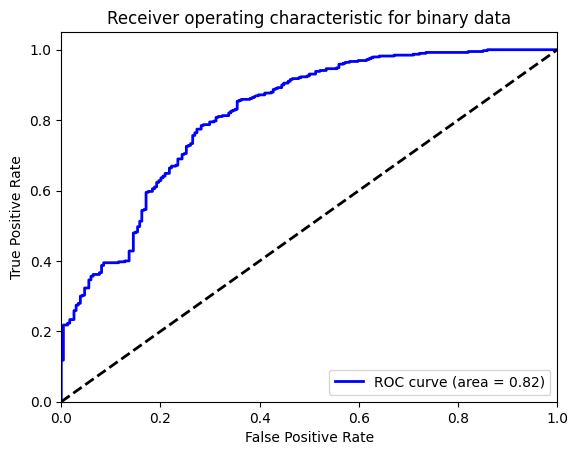


ROC AUC for Validation


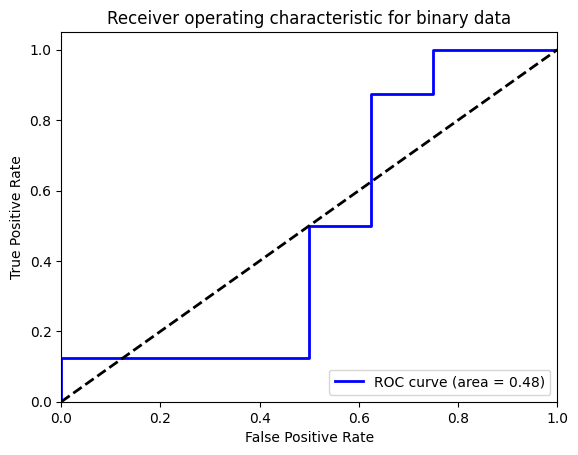


Printing how this model fairs for class PNEUMONIA for validation


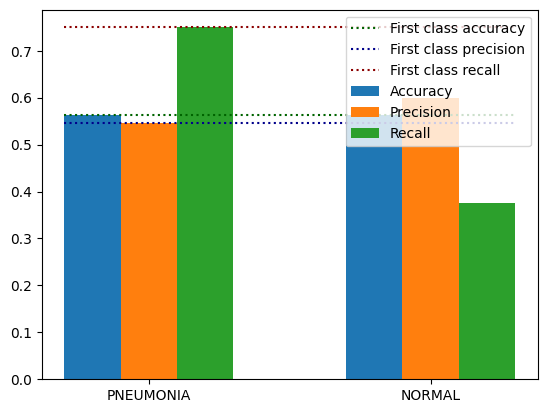


Printing how this model fairs for class PNEUMONIA for test


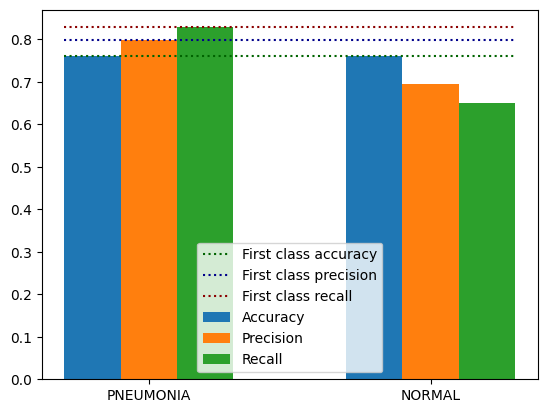


Confusion Matrix for Test


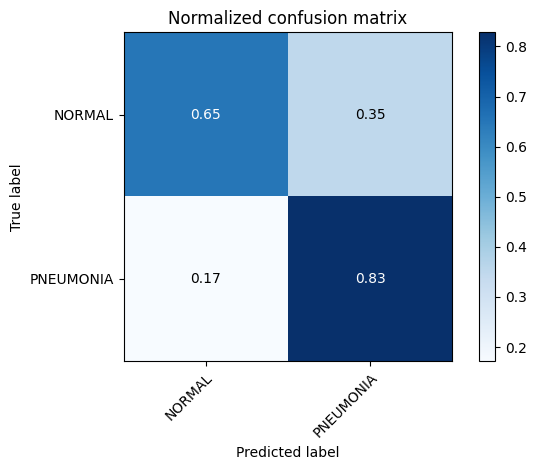


Confusion Matrix for Validation


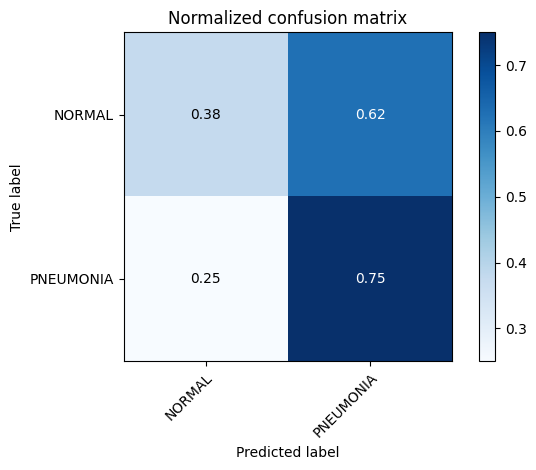


Memory Usage:
Current memory usage is 218072.929353MB; Peak was 266291.56718MB


In [35]:
main_folder_path = './chest_xray'
parent_folder = './'

PCAbasedanalysis(500, parent_folder, 150, 'four', 'SVM', False)

Loading features from ./features1000


Feature set sizes:
Training: (2000, 4018294)
Test: (624, 4018294)
Validation: (16, 4018294)
Features loaded. Cumulative Time taken in seconds 361.2734169960022

Co-variance matrix calculation. Cumulative Time taken in seconds 369.0726191997528

SVD processing . Cumulative Time taken in seconds 1492.7481708526611

Top 300 components. Cumulative Time taken in seconds 1492.7481708526611

Now running SVC fit. Cumulative Time taken in seconds 1504.5222973823547

Fitting 5 folds for each of 1056 candidates, totalling 5280 fits
Grid search Cumulative Time taken in seconds 1839.1669540405273

Best parameters found during grid search:  {'C': 100, 'class_weight': 'balanced', 'coef0': -1.0, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True, 'shrinking': True, 'tol': 1e-06}

Training accuracy: 1.00
Training recall: 1.00
Training precision: 1.00
Training AUC-ROC: 1.00
Test accuracy: 0.75
Test recall: 0.98
Test precision: 0.72
Test AUC-ROC: 0.87
Validation

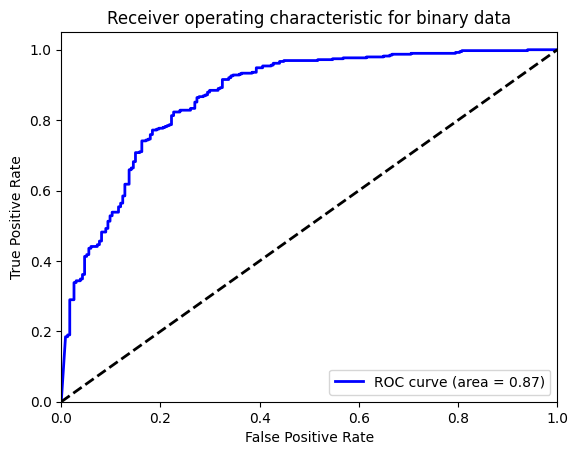


ROC AUC for Validation


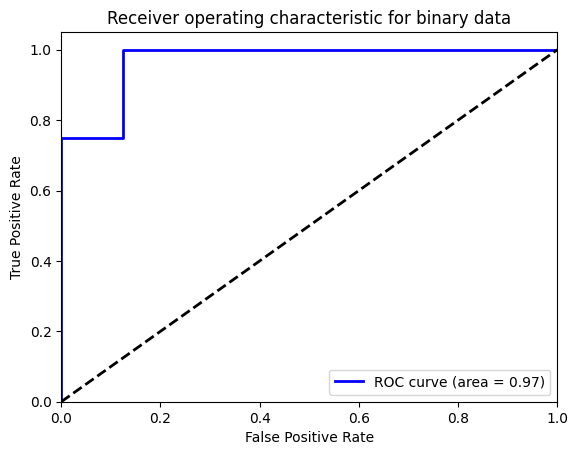


Printing how this model fairs for class PNEUMONIA for validation


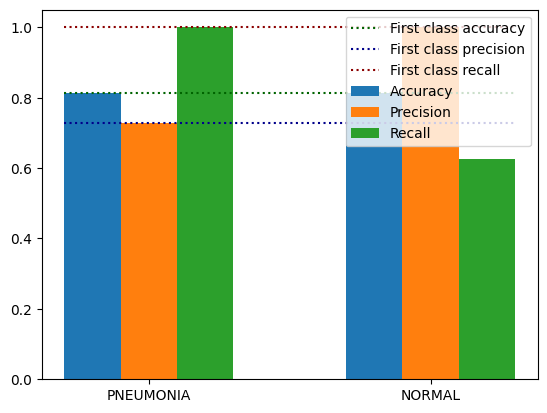


Printing how this model fairs for class PNEUMONIA for test


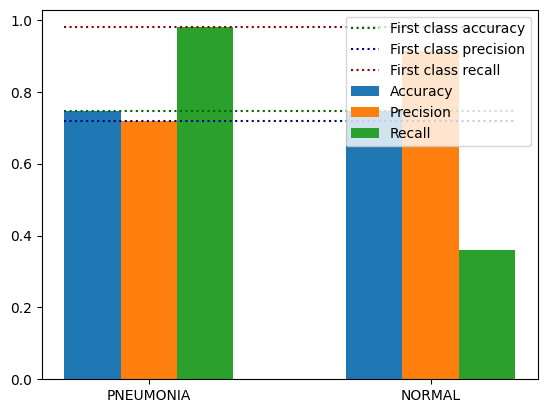


Confusion Matrix for Test


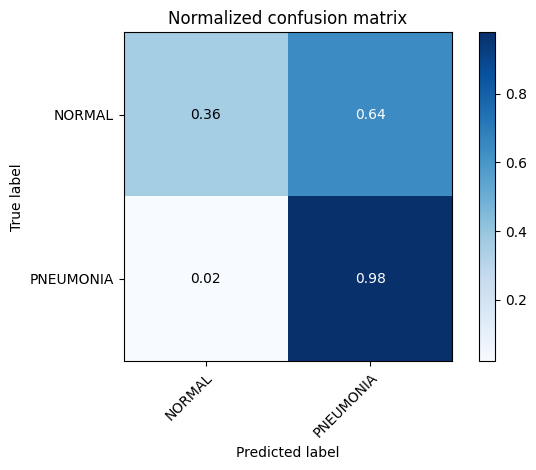


Confusion Matrix for Validation


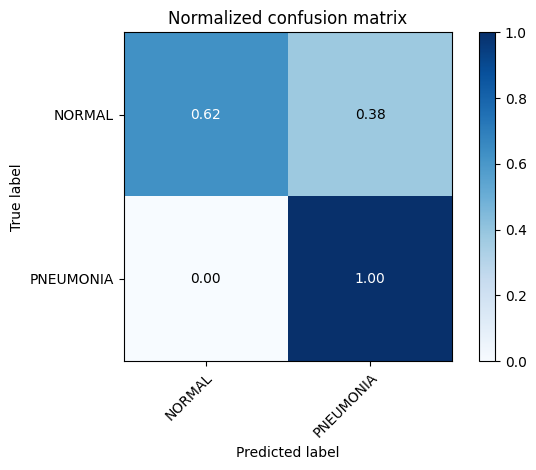


Memory Usage:
Current memory usage is 106765.609442MB; Peak was 203213.144855MB


In [12]:
main_folder_path = './chest_xray'
parent_folder = './'

PCAbasedanalysis(1000, parent_folder, 300, 'four', True)

Loading features from ./features1000


Feature set sizes:
Training: (2000, 100352)
Test: (624, 100352)
Validation: (16, 100352)
Features loaded. Cumulative Time taken in seconds 0.6029186248779297

Co-variance matrix calculation. Cumulative Time taken in seconds 0.8162574768066406

SVD processing . Cumulative Time taken in seconds 51.02188682556152

Top 400 components. Cumulative Time taken in seconds 51.02188682556152

Now running SVC fit. Cumulative Time taken in seconds 51.34607553482056

Fitting 5 folds for each of 1056 candidates, totalling 5280 fits
Grid search Cumulative Time taken in seconds 626.0390961170197

Best parameters found during grid search:  {'C': 10, 'class_weight': 'balanced', 'coef0': -0.8, 'gamma': 'scale', 'kernel': 'sigmoid', 'probability': True, 'shrinking': True, 'tol': 1e-06}

Training accuracy: 1.00
Training recall: 1.00
Training precision: 1.00
Training AUC-ROC: 1.00
Test accuracy: 0.81
Test recall: 0.99
Test precision: 0.77
Test AUC-ROC: 0.96
Validation a

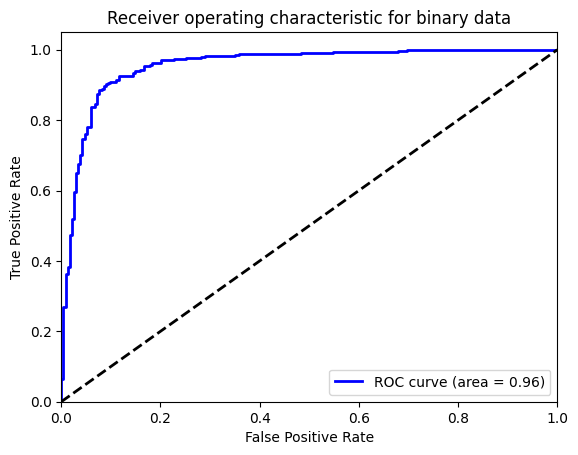


ROC AUC for Validation


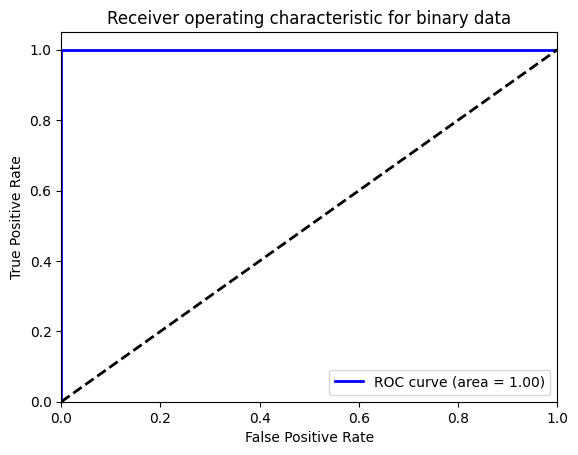


Printing how this model fairs for class PNEUMONIA for validation


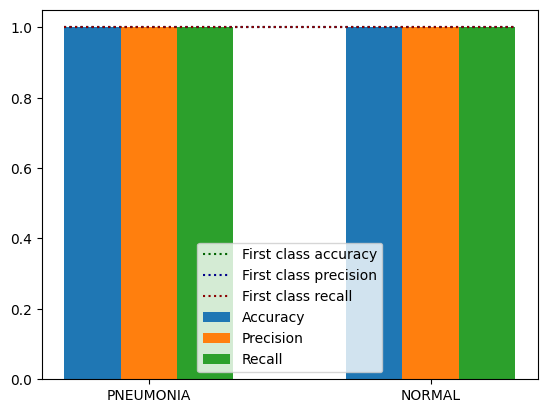


Printing how this model fairs for class PNEUMONIA for test


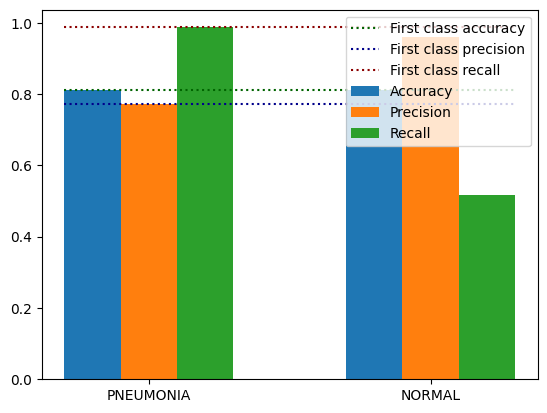


Confusion Matrix for Test


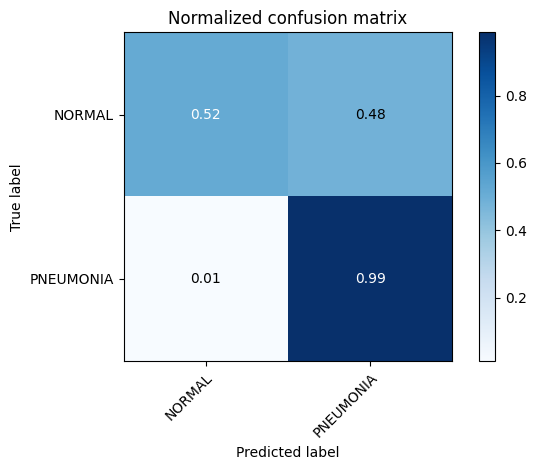


Confusion Matrix for Validation


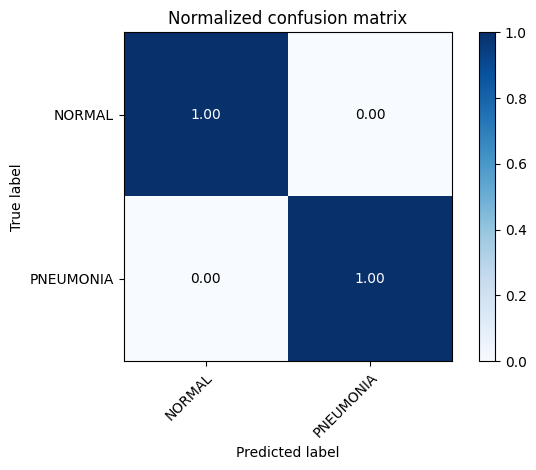


Memory Usage:
Current memory usage is 2691.79439MB; Peak was 5106.325096MB


In [11]:
main_folder_path = './chest_xray'
parent_folder = './'

PCAbasedanalysis(1000, parent_folder, 400, 'one', True)

Loading features from ./features1000


Feature set sizes:
Training: (2000, 100352)
Test: (624, 100352)
Validation: (16, 100352)
Features loaded. Cumulative Time taken in seconds 0.5954890251159668

Co-variance matrix calculation. Cumulative Time taken in seconds 0.801537275314331

SVD 50.3572793006897

Top 400 components. Cumulative Time taken in seconds 50.3572793006897

Now running SVC fit. Cumulative Time taken in seconds 50.65144324302673

Accuracy calculation. Cumulative Time taken in seconds 52.11882495880127

Training accuracy: 1.00
Training recall: 1.00
Training precision: 1.00
Training AUC-ROC: 1.00
Test accuracy: 0.83
Test recall: 0.99
Test precision: 0.80
Test AUC-ROC: 0.96
Validation accuracy: 0.94
Validation recall: 1.00
Validation precision: 0.89
Validation AUC-ROC: 1.00

Visualizing the results


ROC AUC for Test


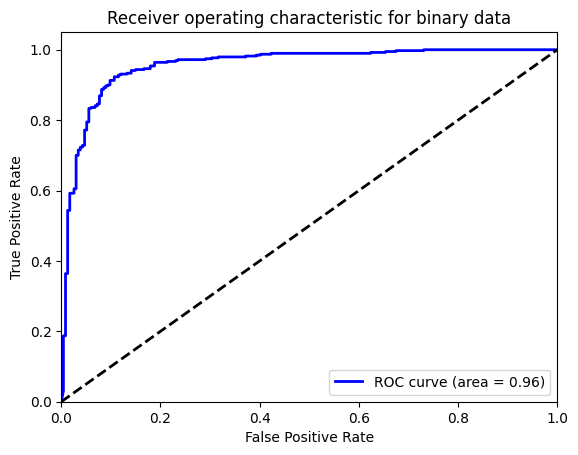


ROC AUC for Validation


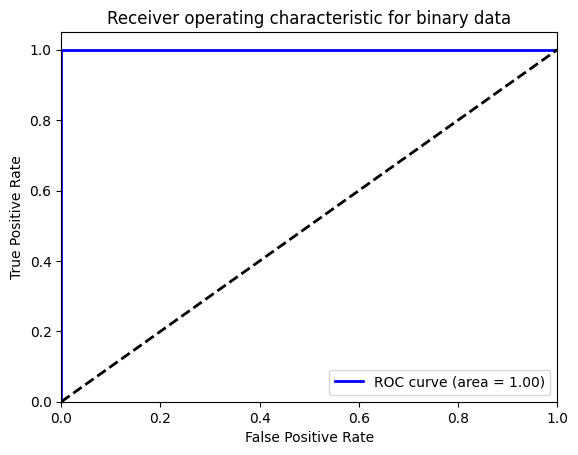


Printing how this model fairs for class PNEUMONIA for validation


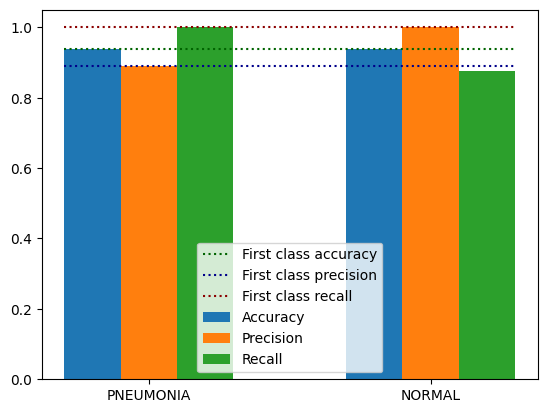


Printing how this model fairs for class PNEUMONIA for test


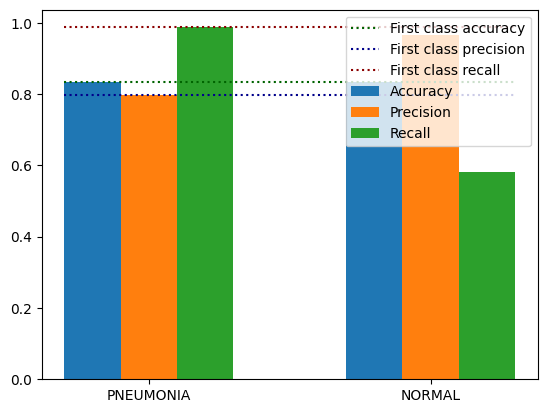


Confusion Matrix for Test


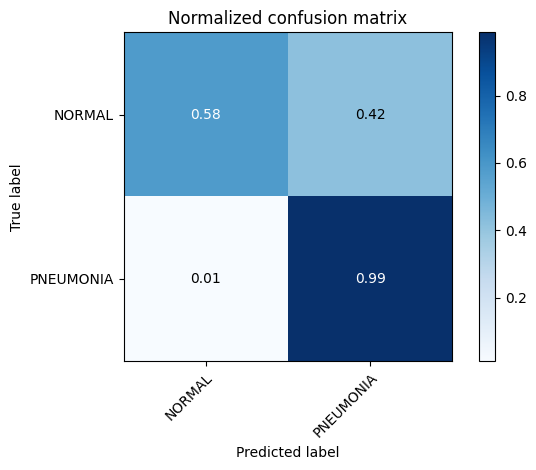


Confusion Matrix for Validation


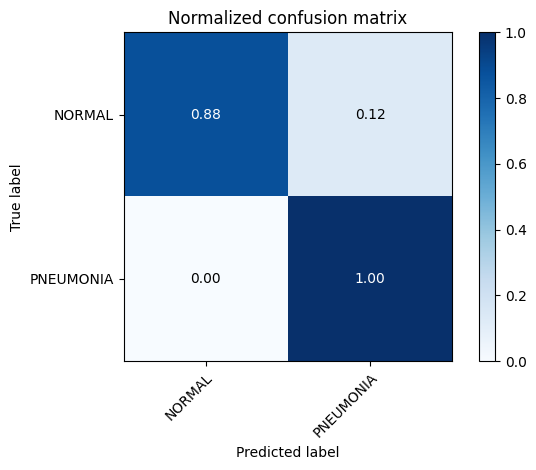

In [20]:
main_folder_path = './chest_xray'
parent_folder = './'

PCAbasedanalysis(1000, parent_folder, 400, 'one')

Loading features from ./features1000


Feature set sizes:
Training: (2000, 100352)
Test: (624, 100352)
Validation: (16, 100352)
Features loaded. Cumulative Time taken in seconds 4.171685695648193

Co-variance matrix calculation. Cumulative Time taken in seconds 4.381356716156006

SVD 54.02369427680969

Top 400 components. Cumulative Time taken in seconds 54.02369427680969

Now running SVC fit. Cumulative Time taken in seconds 54.32897210121155

Accuracy calculation. Cumulative Time taken in seconds 55.62001657485962

Training accuracy: 1.00
Training recall: 1.00
Training precision: 1.00
Training AUC-ROC: 1.00
Test accuracy: 0.84
Test recall: 0.98
Test precision: 0.81
Test AUC-ROC: 0.96
Validation accuracy: 0.88
Validation recall: 1.00
Validation precision: 0.80
Validation AUC-ROC: 1.00

Visualizing the results


ROC AUC for Test


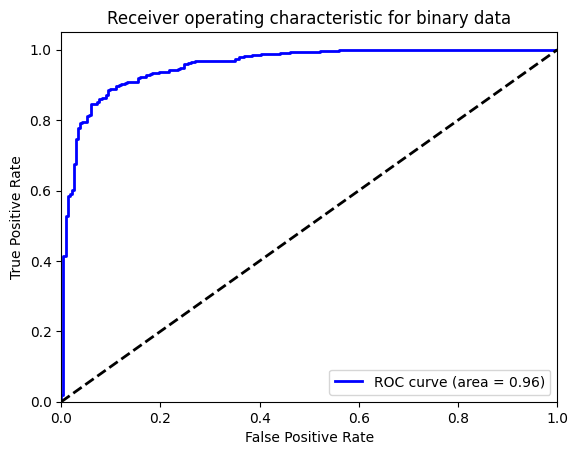


ROC AUC for Validation


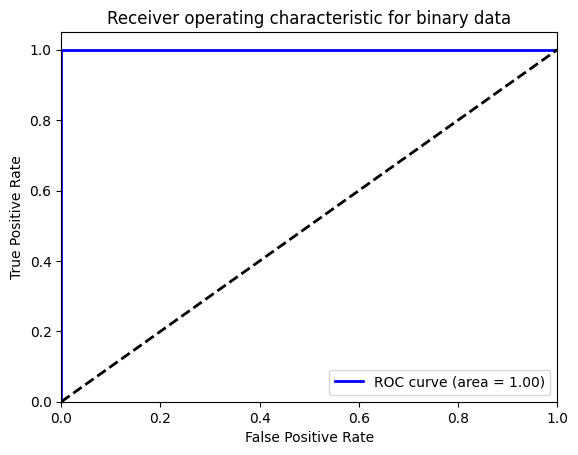


Printing how this model fairs for class PNEUMONIA for validation


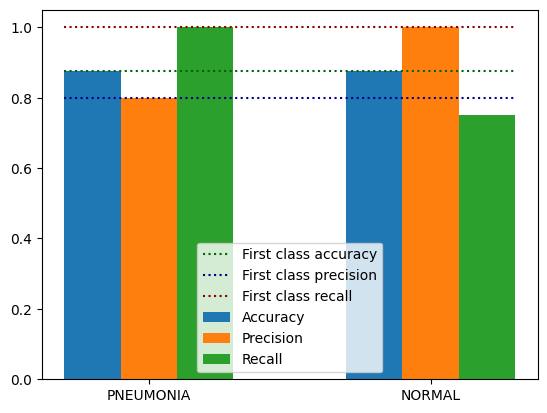


Printing how this model fairs for class PNEUMONIA for test


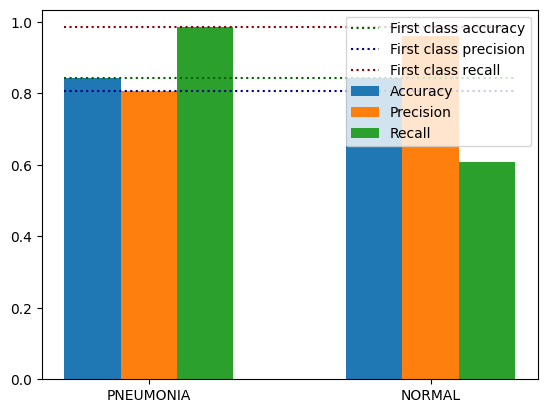


Confusion Matrix for Test


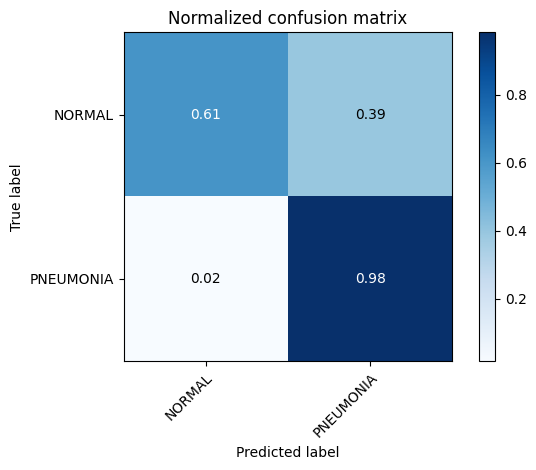


Confusion Matrix for Validation


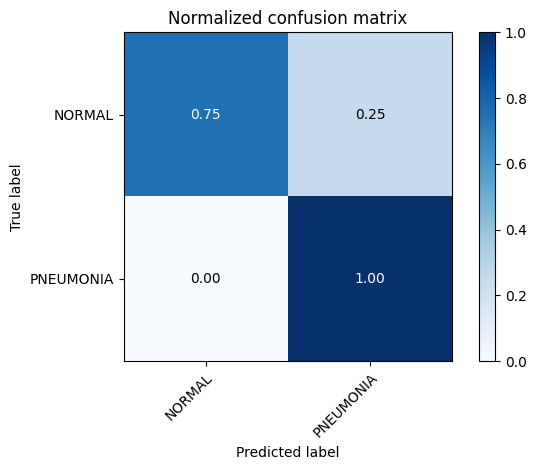

In [15]:
main_folder_path = './chest_xray'
parent_folder = './'

PCAbasedanalysis(1000, parent_folder, 400, 'two')

#### Modeling on K-Best Features (non-PCA method)

NON-PCA method for feature selection & the models created with this method mostly `overfit` for this dataset
as of `9/1/23`

For  Training
Number of files per class in the main folder: {'NORMAL': 1344, 'PNEUMONIA': 3874}.              We will pick a few out of these for training, test & validation
For  Test
Number of files per class in the main folder: {'NORMAL': 234, 'PNEUMONIA': 390}.              We will pick a few out of these for training, test & validation
For  Validation
Number of files per class in the main folder: {'NORMAL': 8, 'PNEUMONIA': 8}.              We will pick a few out of these for training, test & validation

Loading saved features
Train & Evaluate section with a choice of 6 optimizers & 4 features ==>


Doing feature selection using Variance & K Best
Original feature count 100352

Cumulative Time taken: 4.422534227371216
X_train selected shape: (1000, 90316)
X_test selected shape: (624, 90316)
X_val selected shape: (16, 90316)


Training with Random Forest..
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters:  {'max_depth': None, 'max_features': 'sqrt', 'min

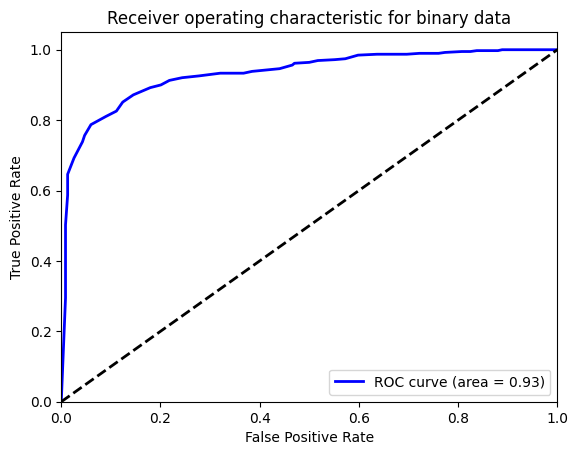

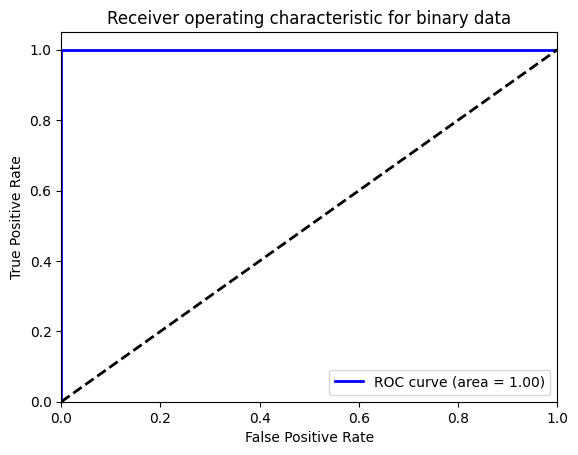

Precision test: 0.813767459528958
Recall test: 0.7980769230769231
Precision val: 0.9
Recall val: 0.875

Printing how this model fairs for class PNEUMONIA


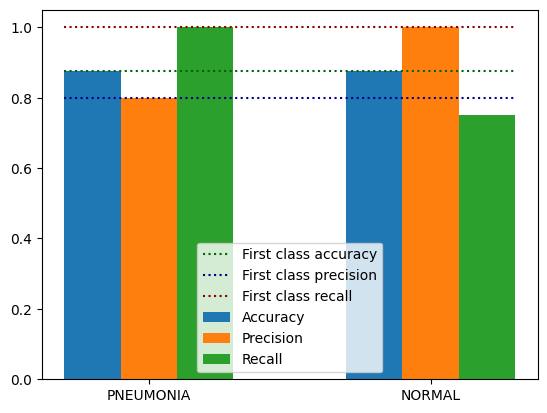

Plot the gridsearch results for Random Forest



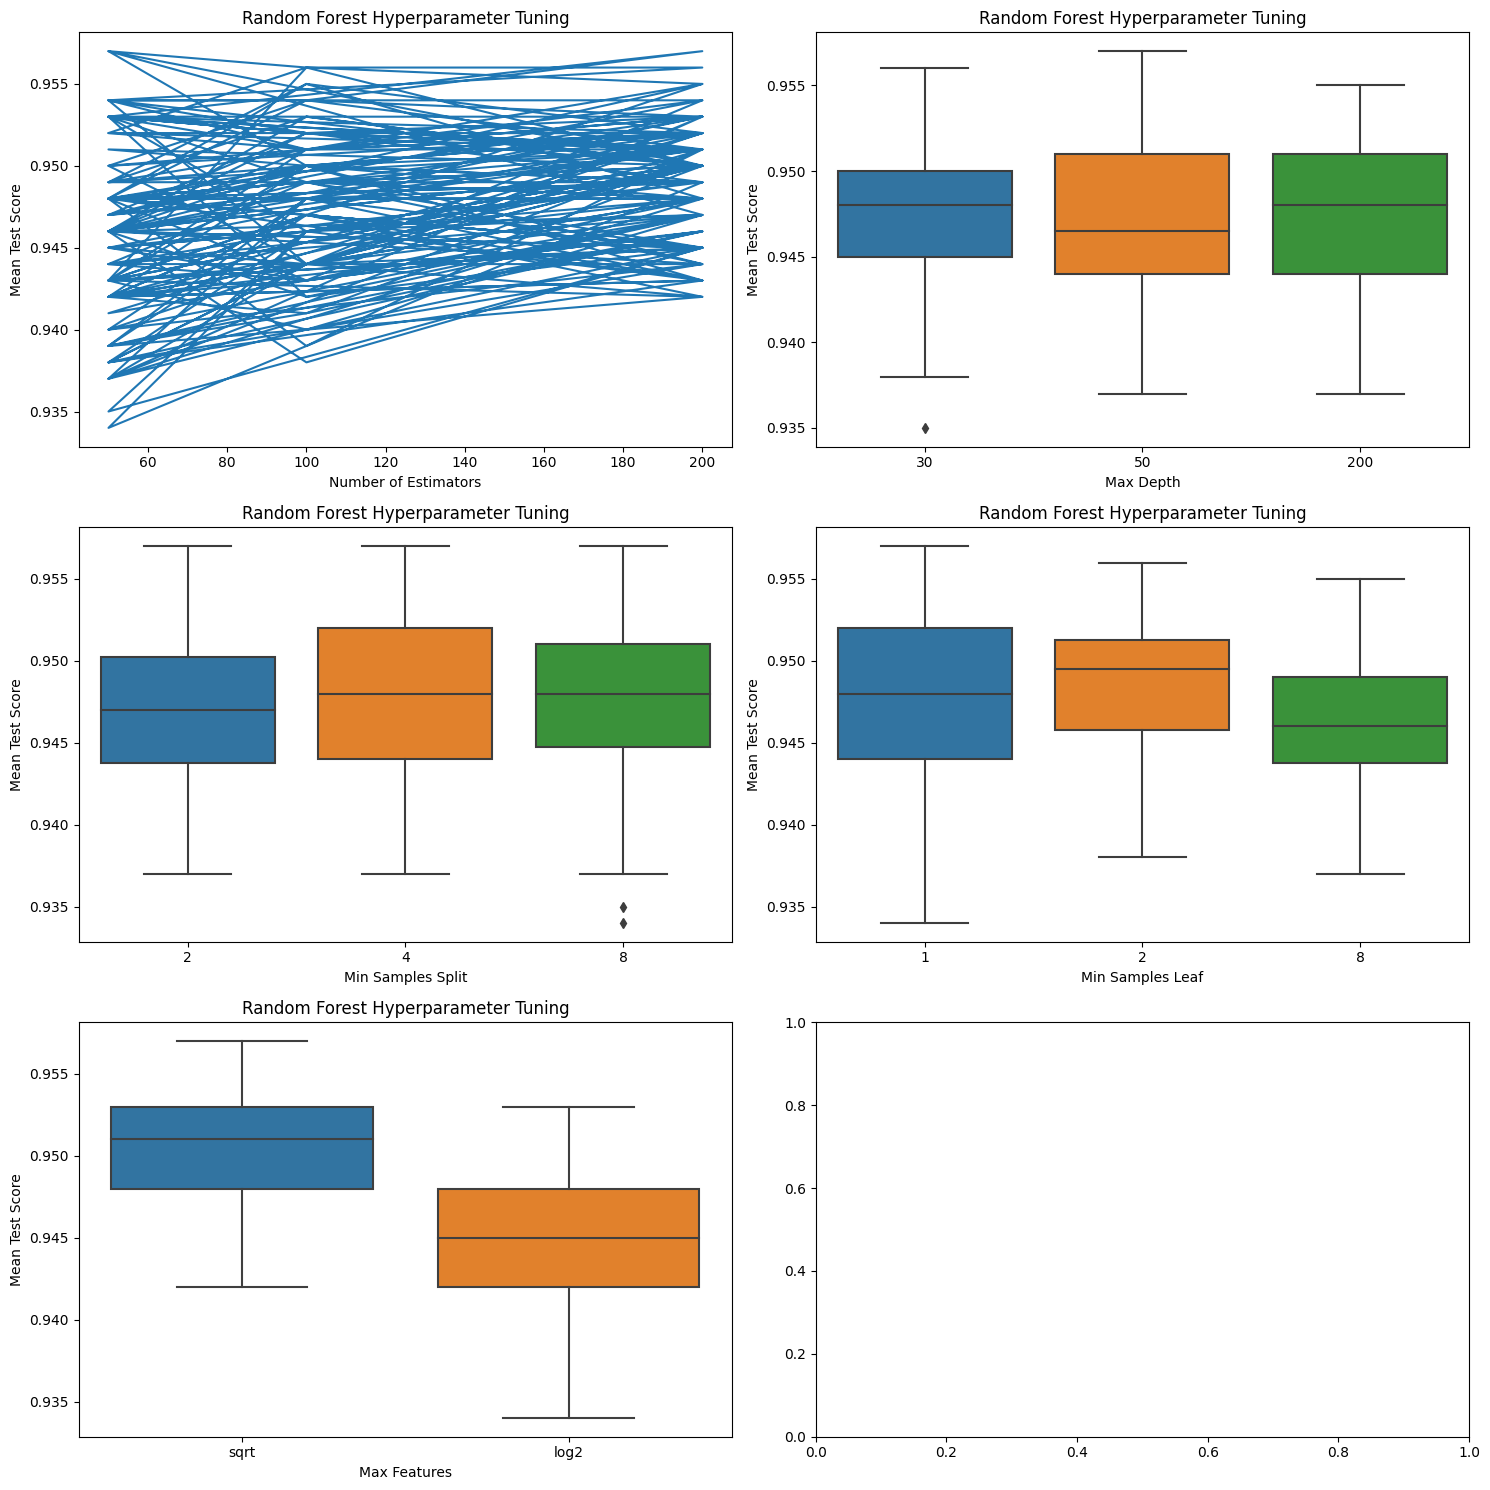


Cumulative Time taken in seconds was 206.93473887443542

Cumulative Time taken: 212.6422460079193

Cumulative Time taken so far (seconds): 212.6422460079193

All Done!!


In [15]:
howmanyimages() ## To proce we are using originals for Test and Validation
# Using the complex feature combination here - C-HIST, LBP, HOG, CONTOUR, EDGE
main_folder_path = './chest_xray'
parent_folder = './'
mlfeaturizationandtraining(500, main_folder_path, parent_folder, gridsrch = True, load = True, 
                           tne = True, whichftr = 'two',  optslist = 'RF',
                          simplifyfeatures = True, pct = 0.90)

For  Training
Number of files per class in the main folder: {'NORMAL': 1344, 'PNEUMONIA': 3874}.              We will pick a few out of these for training, test & validation
For  Test
Number of files per class in the main folder: {'NORMAL': 234, 'PNEUMONIA': 390}.              We will pick a few out of these for training, test & validation
For  Validation
Number of files per class in the main folder: {'NORMAL': 8, 'PNEUMONIA': 8}.              We will pick a few out of these for training, test & validation

Loading saved features
Train & Evaluate section with a choice of 6 optimizers & 4 features ==>



Doing feature selection using Variance & K Best
Original feature count 4018294
X_train selected shape: (1000, 2009147)
X_test selected shape: (624, 2009147)
X_val selected shape: (16, 2009147)
Color histogram/lbp/hog/contour/edge features with test/val dataset with                     500 samples


Training with Random Forest..
Fitting 5 folds for each of 216 candidates, totalling 1080 

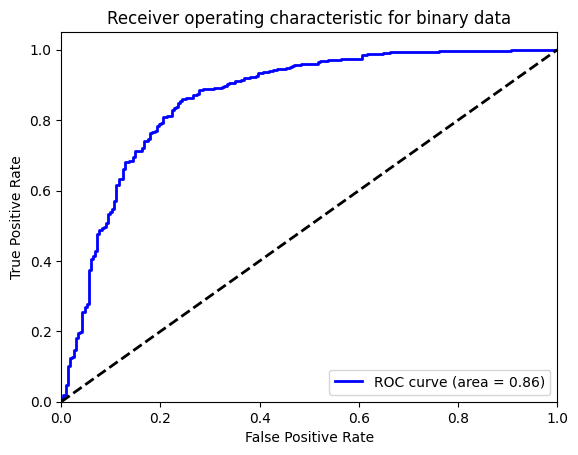

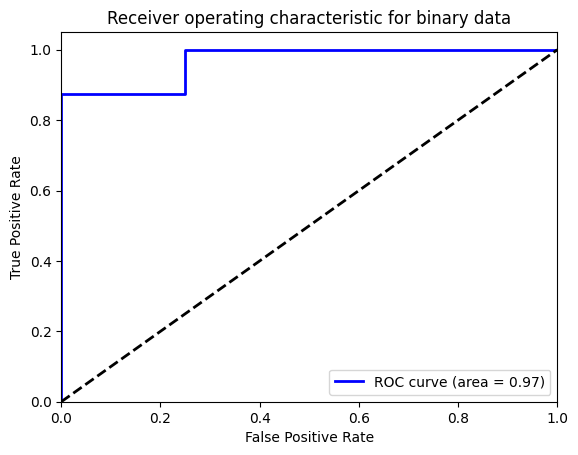

Precision test: 0.8081747839485497
Recall test: 0.7788461538461539
Precision val: 0.8636363636363636
Recall val: 0.8125

Printing how this model fairs for class PNEUMONIA


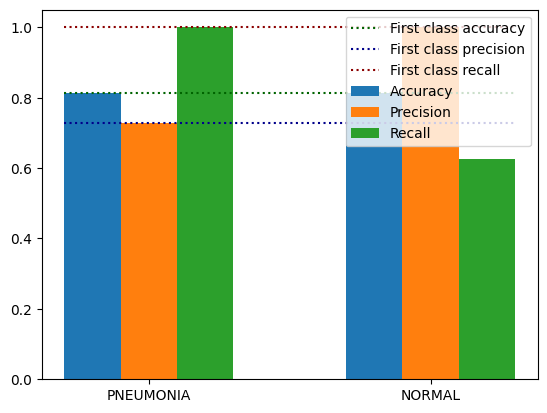

Plot the gridsearch results for Random Forest



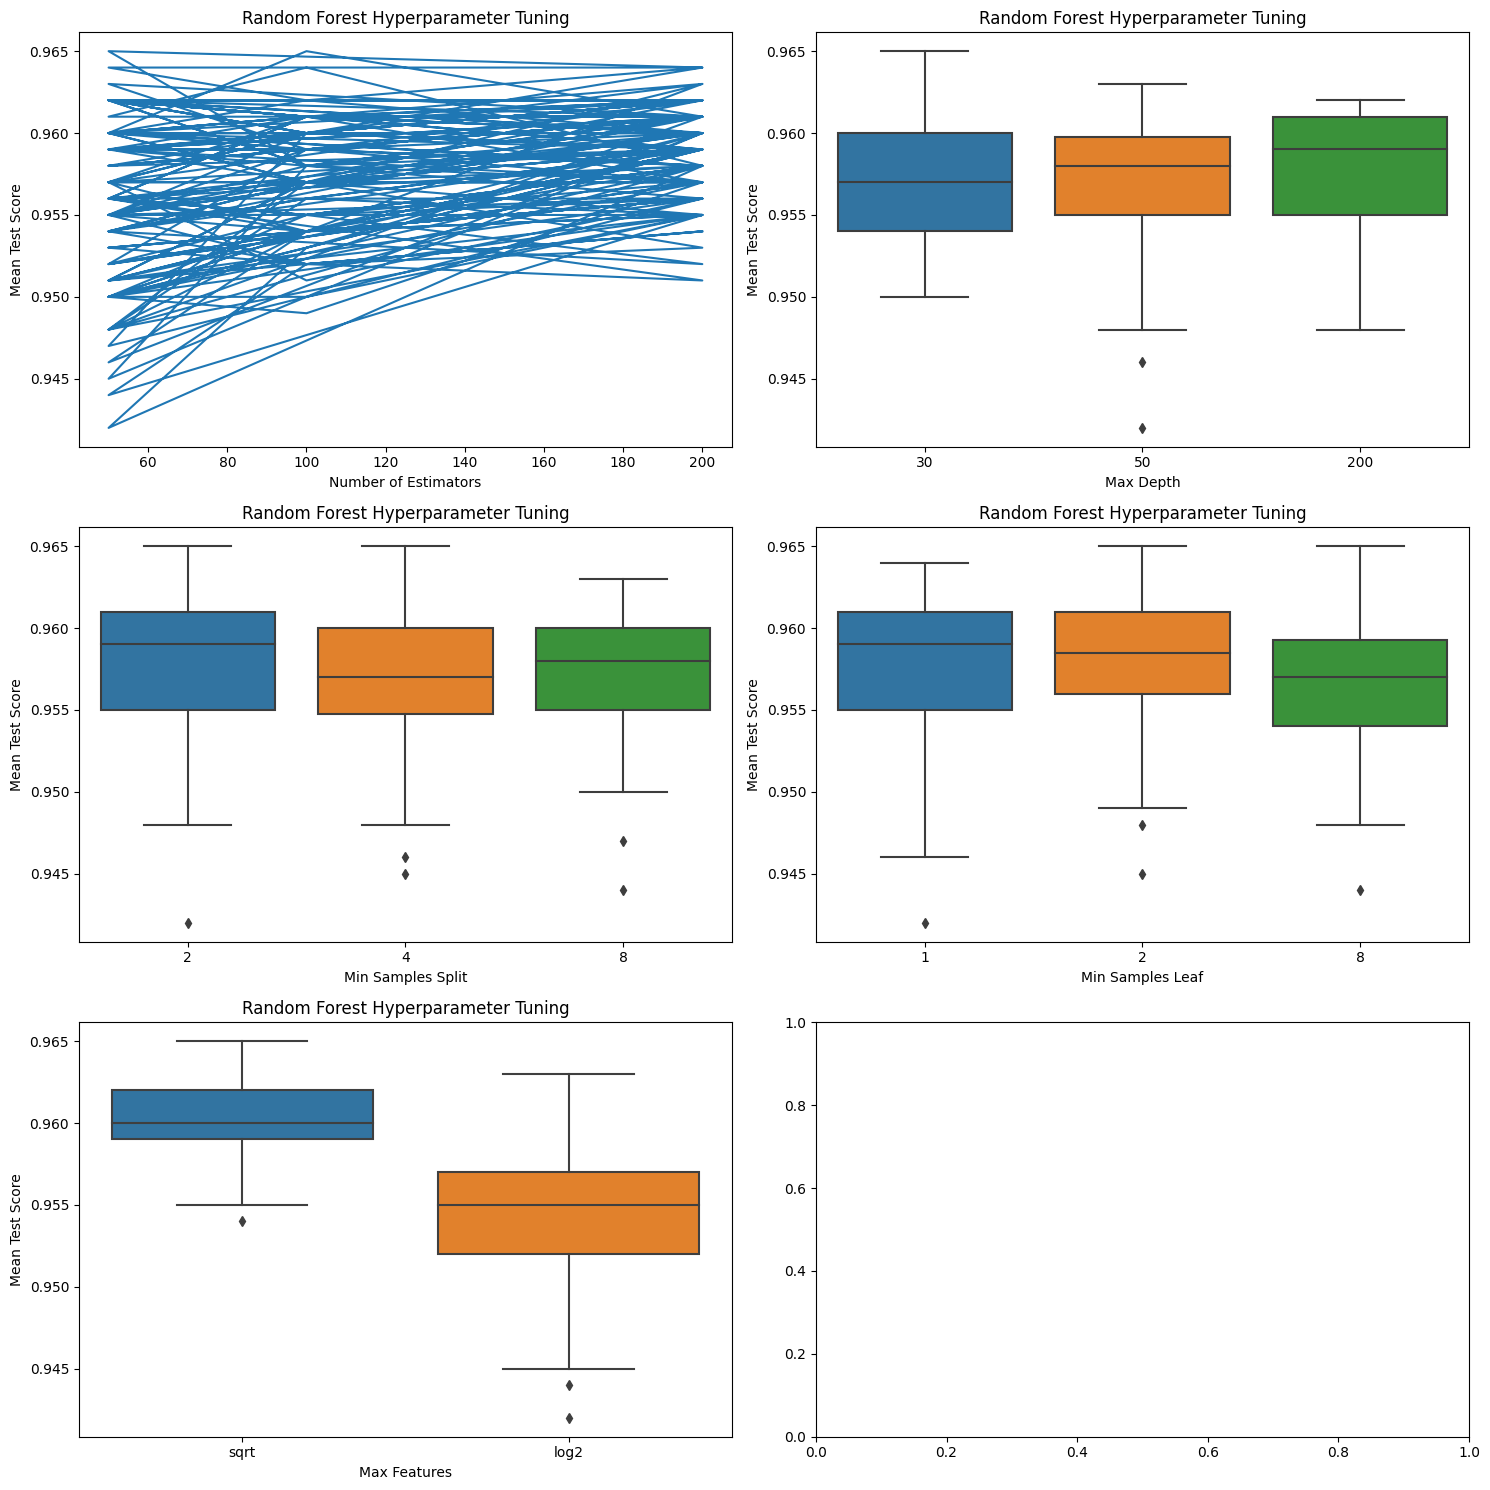


Cumulative Time taken in seconds was 4330.342844486237

Cumulative Time taken so far (seconds): 4697.096110582352

All Done!!


In [14]:
howmanyimages() ## To proce we are using originals for Test and Validation
# Using the complex feature combination here - C-HIST, LBP, HOG, CONTOUR, EDGE
main_folder_path = './chest_xray'
parent_folder = './'
mlfeaturizationandtraining(500, main_folder_path, parent_folder, gridsrch = True, load = True, 
                           tne = True, whichftr = 'four',  optslist = 'RF',
                          simplifyfeatures = True, pct = 0.50)

For  Training
Number of files per class in the main folder: {'NORMAL': 1344, 'PNEUMONIA': 3874}.              We will pick a few out of these for training, test & validation
For  Test
Number of files per class in the main folder: {'NORMAL': 234, 'PNEUMONIA': 390}.              We will pick a few out of these for training, test & validation
For  Validation
Number of files per class in the main folder: {'NORMAL': 8, 'PNEUMONIA': 8}.              We will pick a few out of these for training, test & validation

Loading saved features
Train & Evaluate section with a choice of 6 optimizers & 4 features ==>



Doing feature selection using Variance & K Best
Original feature count 4018294
X_train selected shape: (1000, 1607317)
X_test selected shape: (624, 1607317)
X_val selected shape: (16, 1607317)
Color histogram/lbp/hog/contour/edge features with test/val dataset with                     500 samples


Training with KNN..
Fitting 5 folds for each of 2 candidates, totalling 10 fits

k-Neares

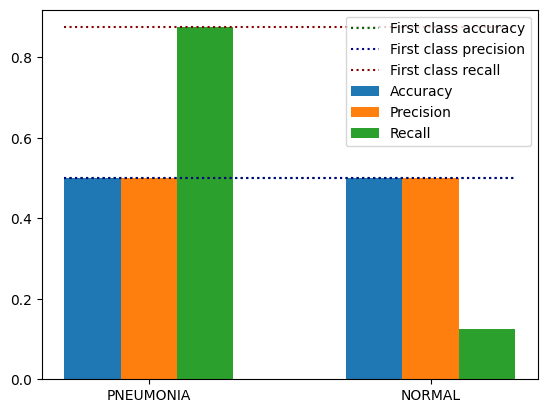

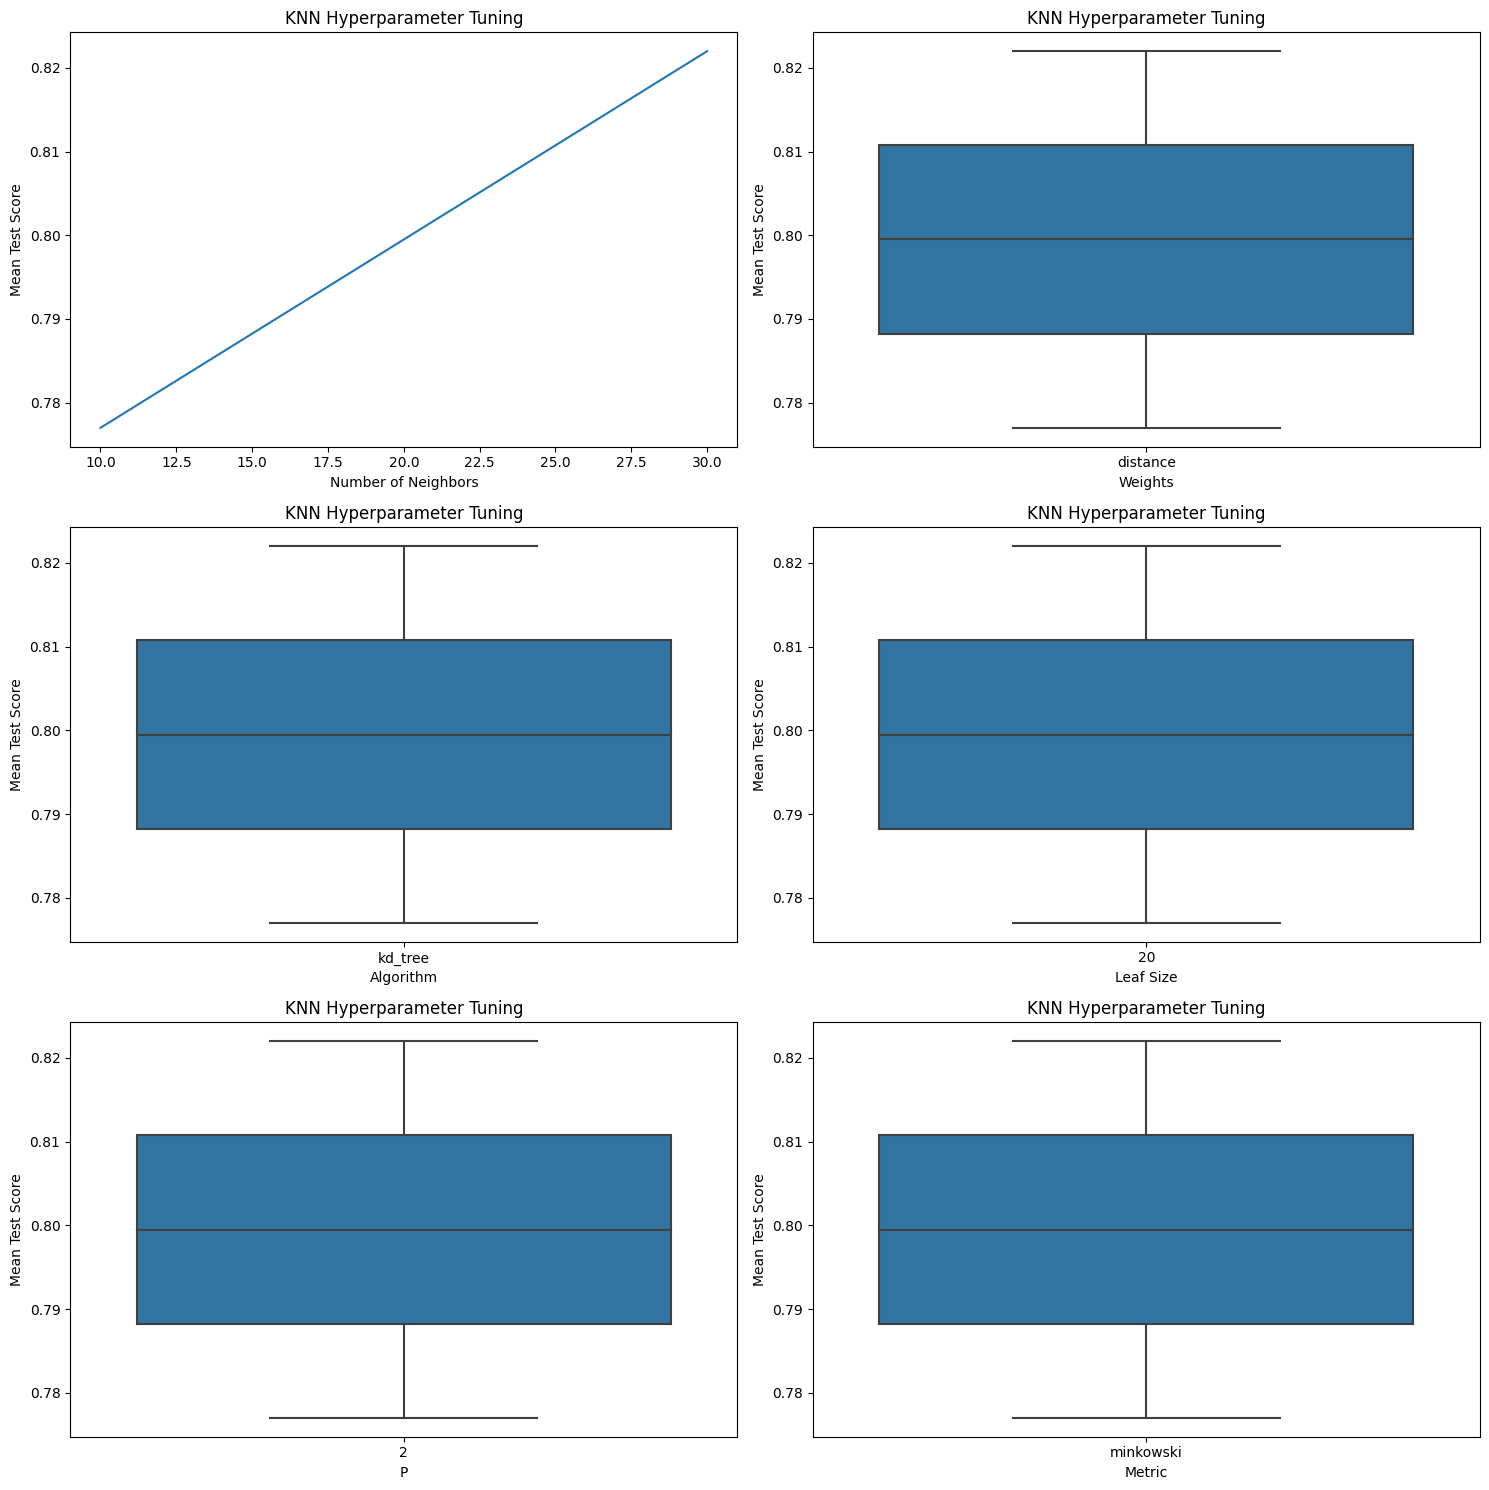


Cumulative Time taken was 5602.360122919083


Cumulative Time taken so far (seconds): 5954.966990232468

All Done!!


In [13]:
howmanyimages() ## To proce we are using originals for Test and Validation
# Using the complex feature combination here - C-HIST, LBP, HOG, CONTOUR, EDGE
main_folder_path = './chest_xray'
parent_folder = './'
mlfeaturizationandtraining(500, main_folder_path, parent_folder, gridsrch = True, load = True, 
                           tne = True, whichftr = 'four',  optslist = 'KNN',
                          simplifyfeatures = True, pct = 0.40)

For  Training
Number of files per class in the main folder: {'NORMAL': 1344, 'PNEUMONIA': 3874}.              We will pick a few out of these for training, test & validation
For  Test
Number of files per class in the main folder: {'NORMAL': 234, 'PNEUMONIA': 390}.              We will pick a few out of these for training, test & validation
For  Validation
Number of files per class in the main folder: {'NORMAL': 8, 'PNEUMONIA': 8}.              We will pick a few out of these for training, test & validation


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1998.72it/s]

Sizes of Train, Test & Validation arrays 1000 624 16


Loading saved features


Train & Evaluate section with a choice of 6 optimizers & 4 features ==>



Doing feature selection using Variance & K Best
Original feature count 4018294
X_train selected shape: (1000, 2210061)
X_test selected shape: (624, 2210061)
X_val selected shape: (16, 2210061)
Color histogram/lbp/hog/contour/edge features with test/val dataset with                     500 samples


Training with SVM/SVC..


Support Vector Machines:
Accuracy train: 1.0
Accuracy test: 0.7836538461538461
Accuracy val: 0.75
AUC ROC test: 0.8254766600920446
AUC ROC val: 1.0


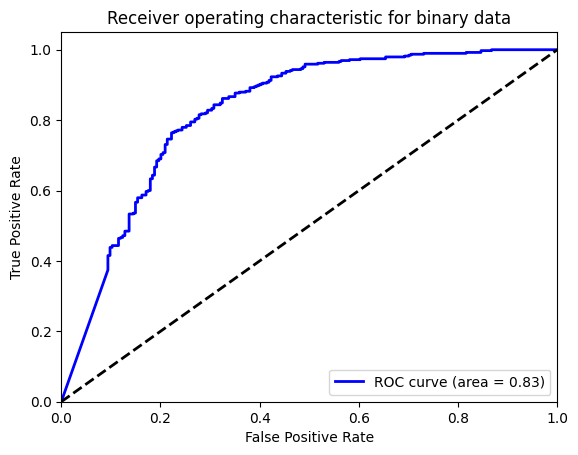

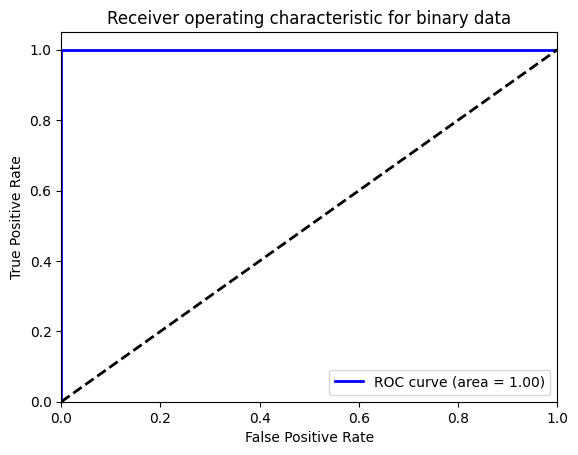

Precision test: 0.8033364043169254
Recall test: 0.7836538461538461
Precision val: 0.8333333333333333
Recall val: 0.75

Printing how this model fairs for class PNEUMONIA


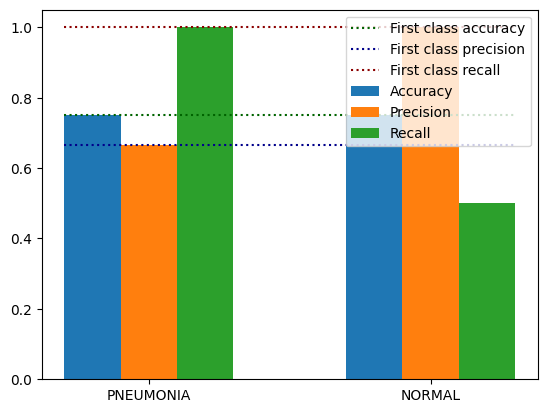

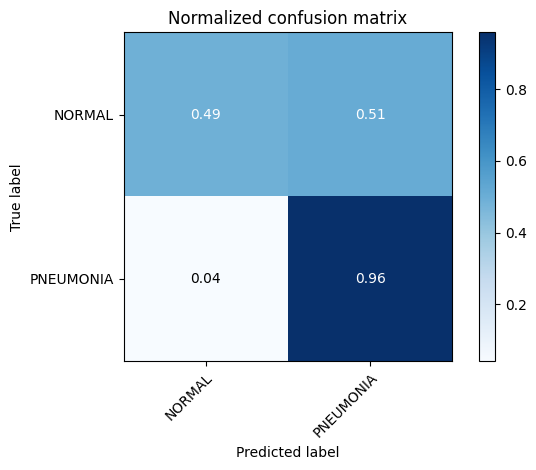


Cumulative Time taken in seconds was 3436.881238222122

Training with Random Forest..

Random Forest:
Accuracy test: 0.7740384615384616
Accuracy val: 0.8125
AUC ROC test: 0.8802432610124917
AUC ROC val: 0.9453125


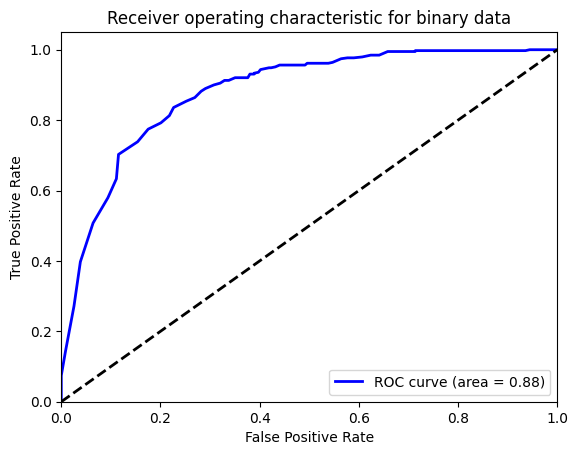

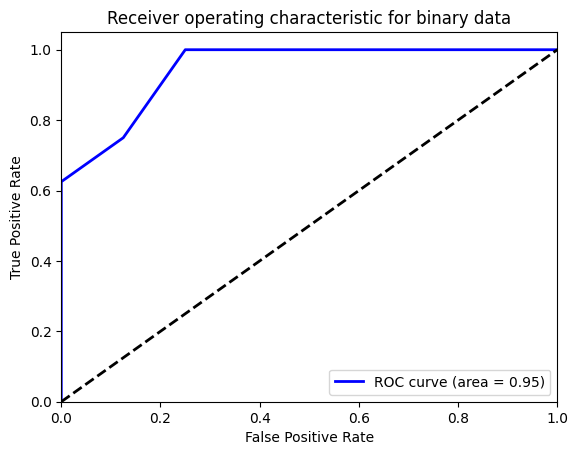

Precision test: 0.7970826639404118
Recall test: 0.7740384615384616
Precision val: 0.8636363636363636
Recall val: 0.8125

Printing how this model fairs for class PNEUMONIA


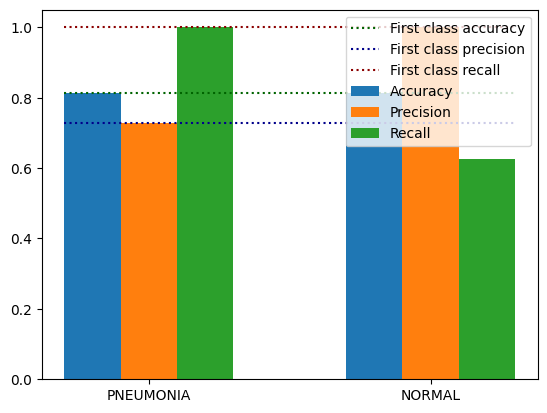


Cumulative Time taken in seconds was 3575.6503541469574

Cumulative Time taken so far (seconds): 3937.752229452133

All Done!!


In [14]:
howmanyimages() ## To proce we are using originals for Test and Validation
# Using the complex feature combination here - C-HIST, LBP, HOG, CONTOUR, EDGE
main_folder_path = './chest_xray'
parent_folder = './'
mlfeaturizationandtraining(500, main_folder_path, parent_folder, gridsrch = False, load = True, 
                           tne = True, whichftr = 'four',  optslist = 'SVM,RF',
                          simplifyfeatures = True, pct = 0.55)

For  Training
Number of files per class in the main folder: {'NORMAL': 1344, 'PNEUMONIA': 3874}.              We will pick a few out of these for training, test & validation
For  Test
Number of files per class in the main folder: {'NORMAL': 234, 'PNEUMONIA': 390}.              We will pick a few out of these for training, test & validation
For  Validation
Number of files per class in the main folder: {'NORMAL': 8, 'PNEUMONIA': 8}.              We will pick a few out of these for training, test & validation


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1989.71it/s]

Sizes of Train, Test & Validation arrays 200 200 16


Loading saved features


Train & Evaluate section with a choice of 6 optimizers & 4 features ==>



Doing feature selection using Variance & K Best
Original feature count 4018294
X_train selected shape: (200, 3415549)
X_test selected shape: (200, 3415549)
X_val selected shape: (16, 3415549)
Color histogram/lbp/hog/contour/edge features with test/val dataset with                     100 samples


Logistic Regression training:
Accuracy test: 0.71
Accuracy val: 0.75
AUC ROC tests: 0.7781
AUC ROC val: 0.6953125


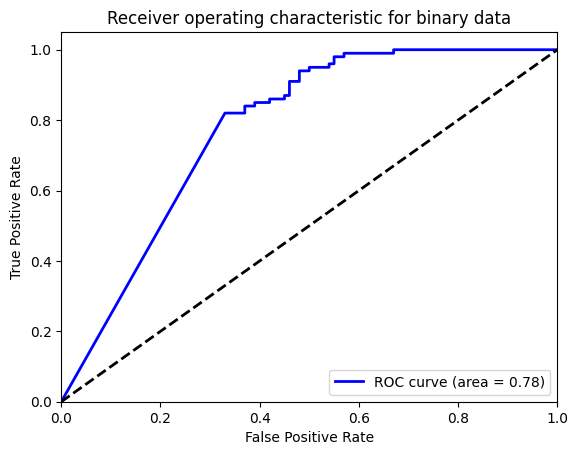

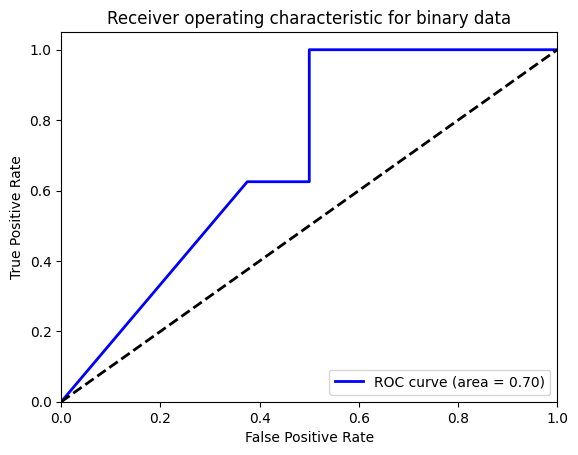

Precision test: 0.7878289473684211
Recall test: 0.71
Precision val: 0.8333333333333333
Recall val: 0.75

Printing how this model fairs for class PNEUMONIA


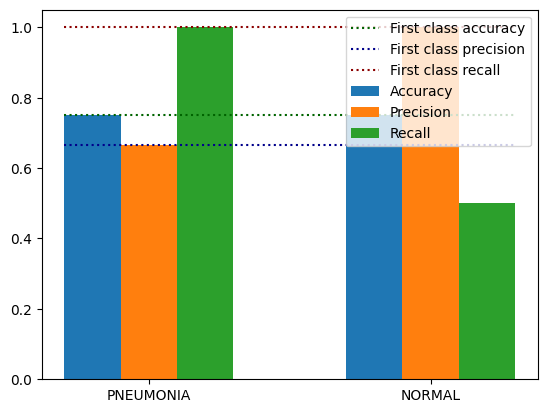

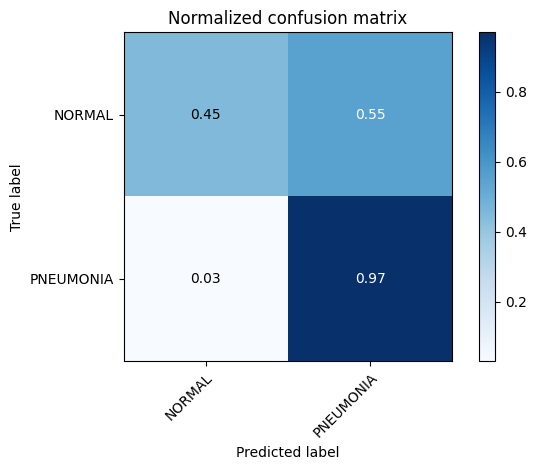


Cumulative Time taken in seconds was 41.98141622543335

Training with SVM/SVC..

Support Vector Machines:
Accuracy test: 0.785
Accuracy val: 0.75
AUC ROC test: 0.82765
AUC ROC val: 0.890625


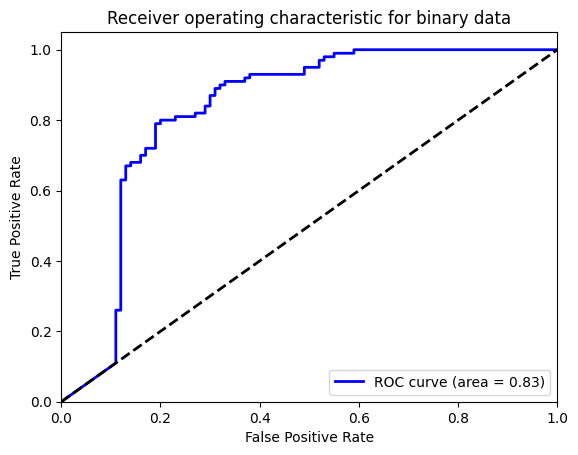

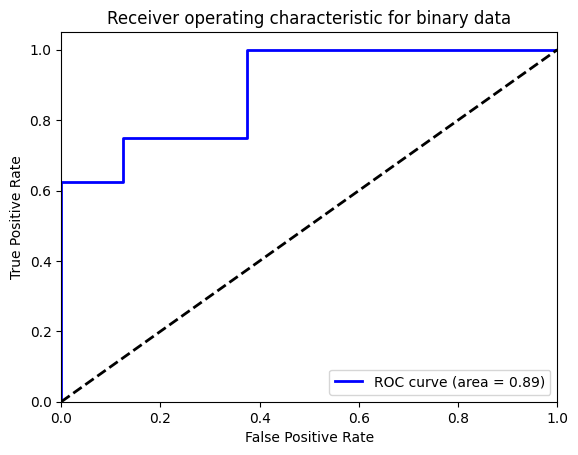

Precision test: 0.804
Recall test: 0.785
Precision val: 0.8333333333333333
Recall val: 0.75

Printing how this model fairs for class PNEUMONIA


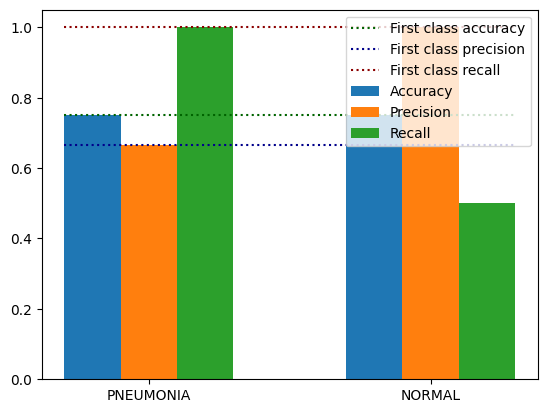

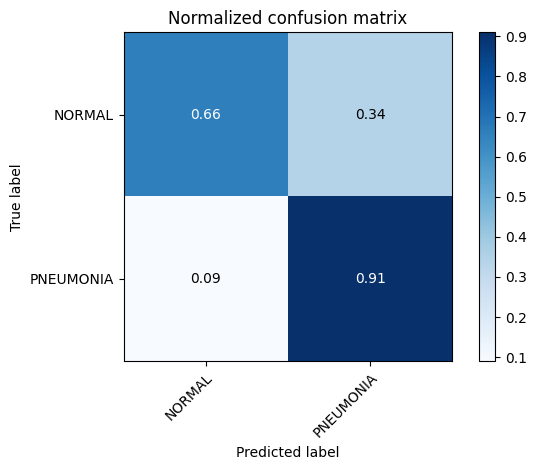


Cumulative Time taken in seconds was 287.0135793685913

Training with Random Forest..

Random Forest:
Accuracy test: 0.775
Accuracy val: 0.875
AUC ROC test: 0.9107
AUC ROC val: 0.9609375


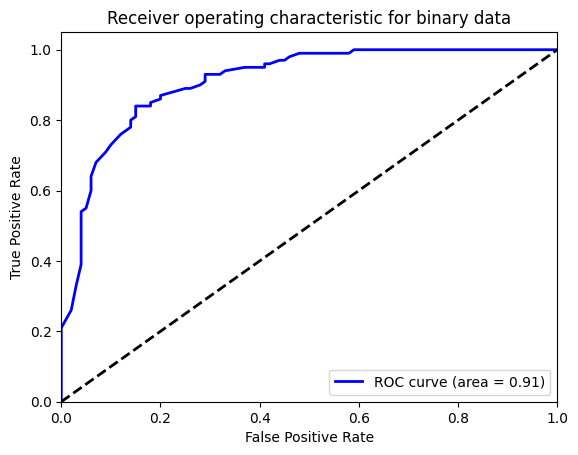

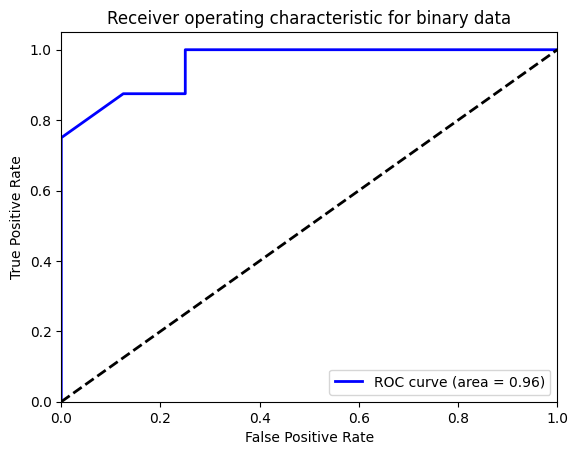

Precision test: 0.8186189317576179
Recall test: 0.775
Precision val: 0.9
Recall val: 0.875

Printing how this model fairs for class PNEUMONIA


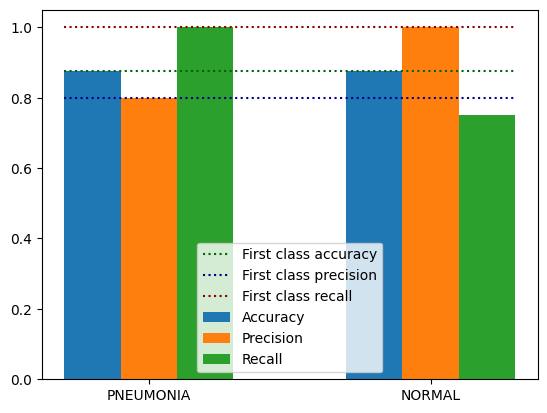


Cumulative Time taken in seconds was 309.3881187438965


Cumulative Time taken so far (seconds): 360.23172068595886

All Done!!


In [10]:
howmanyimages() ## To proce we are using originals for Test and Validation
# Using the complex feature combination here - C-HIST, LBP, HOG, CONTOUR, EDGE
main_folder_path = './chest_xray'
parent_folder = './'
mlfeaturizationandtraining(100, main_folder_path, parent_folder, gridsrch = False, load = True, 
                           tne = True, whichftr = 'four',  optslist = 'LR,SVM,KNN,RF',
                          simplifyfeatures = True, pct = 0.85, color_space_clhce = 'BGR')

For  Training
Number of files per class in the main folder: {'NORMAL': 1344, 'PNEUMONIA': 3874}.              We will pick a few out of these for training, test & validation
For  Test
Number of files per class in the main folder: {'NORMAL': 234, 'PNEUMONIA': 390}.              We will pick a few out of these for training, test & validation
For  Validation
Number of files per class in the main folder: {'NORMAL': 8, 'PNEUMONIA': 8}.              We will pick a few out of these for training, test & validation


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 2002.05it/s]

Sizes of Train, Test & Validation arrays 200 200 16


Loading saved features


Train & Evaluate section with a choice of 6 optimizers & 4 features ==>



Doing feature selection using Variance & K Best
Original feature count 4018294
X_train selected shape: (200, 2611891)
X_test selected shape: (200, 2611891)
X_val selected shape: (16, 2611891)
Color histogram/lbp/hog/contour/edge features with test/val dataset with                     100 samples


Logistic Regression training:
Accuracy test: 0.695
Accuracy val: 0.6875
AUC ROC tests: 0.74665
AUC ROC val: 0.65625


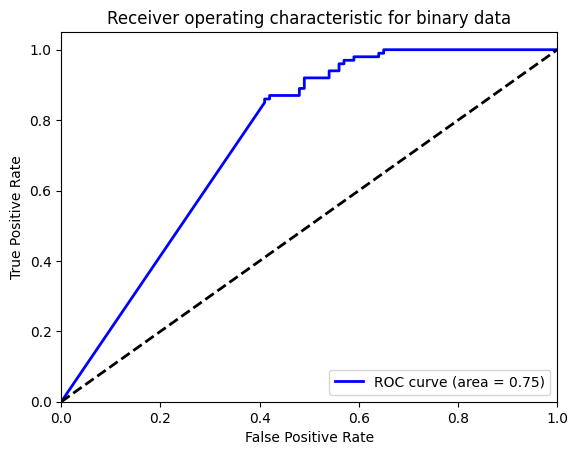

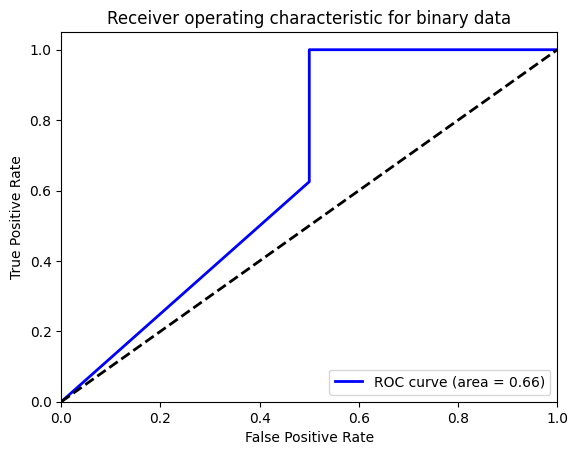

Precision test: 0.7635491282605759
Recall test: 0.695
Precision val: 0.8076923076923077
Recall val: 0.6875

Printing how this model fairs for class PNEUMONIA


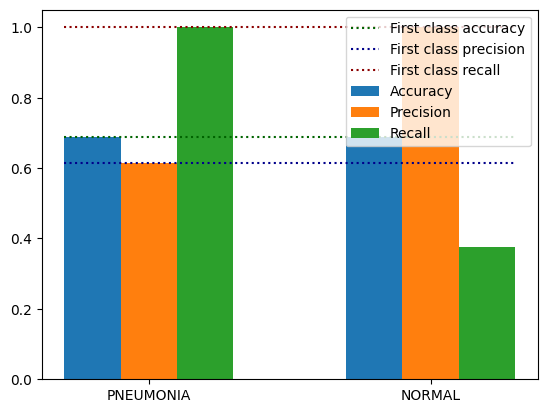

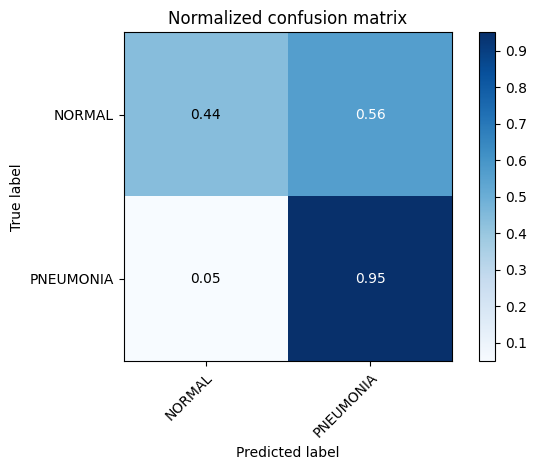


Cumulative Time taken in seconds was 29.049189805984497

Training with SVM/SVC..

Support Vector Machines:
Accuracy test: 0.765
Accuracy val: 0.75
AUC ROC test: 0.8282
AUC ROC val: 0.921875


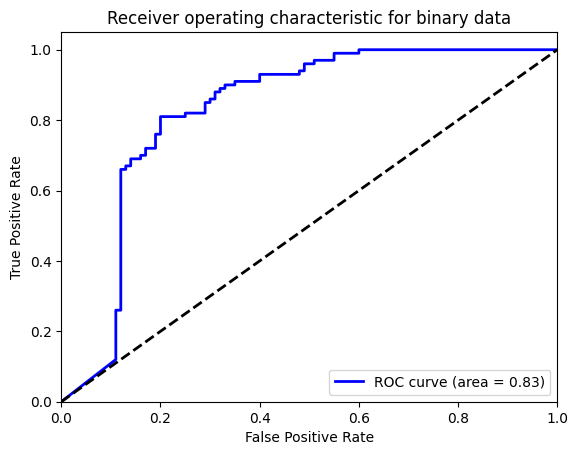

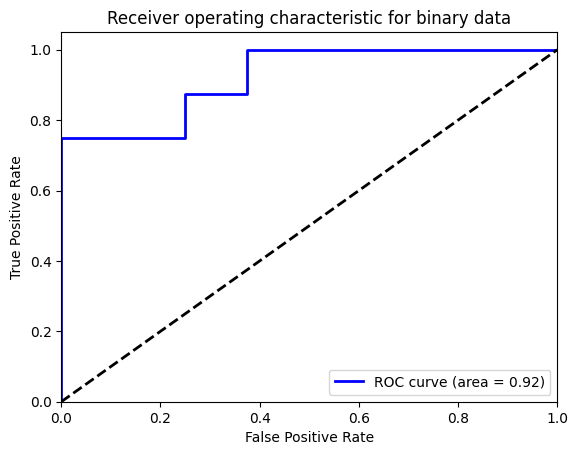

Precision test: 0.7893328966044328
Recall test: 0.765
Precision val: 0.8333333333333333
Recall val: 0.75

Printing how this model fairs for class PNEUMONIA


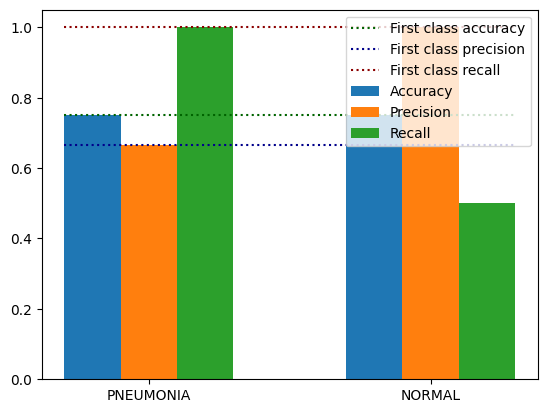

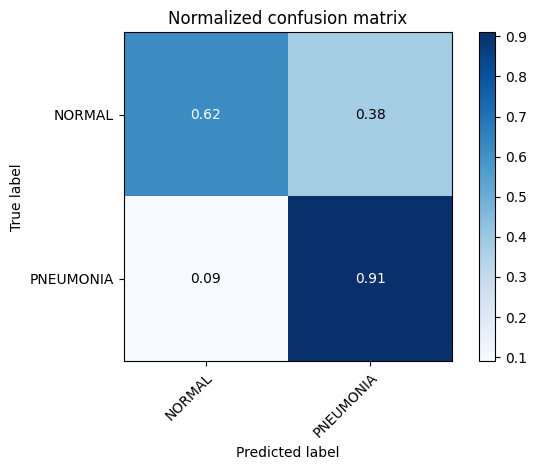


Cumulative Time taken in seconds was 228.7582495212555


Cumulative Time taken so far (seconds): 276.4923017024994

All Done!!


In [11]:
howmanyimages() ## To proce we are using originals for Test and Validation
# Using the complex feature combination here - C-HIST, LBP, HOG, CONTOUR, EDGE
main_folder_path = './chest_xray'
parent_folder = './'
mlfeaturizationandtraining(100, main_folder_path, parent_folder, gridsrch = False, load = True, 
                           tne = True, whichftr = 'four',  optslist = 'LR,SVM,KNN',
                          simplifyfeatures = True, pct = 0.65, color_space_clhce = 'BGR')


------
## APPENDIX
Only used for generation of data samples

## Data Augmentation

This section needs to be run only one time to generate the augmented dataset and then save it to the file system and gdrive.

#### Code to augment dataset

In [2]:
import os

main_folder = './skin_cancer_dataset_nohair_more_data'
class_names = ['akiec', 'bcc', 'bkl', 'df', 'PNEUMONIA', 'nv', 'vasc']
files_per_subfolder = {}

for class_name in class_names:
    subfolder_path = os.path.join(main_folder, class_name)
    if os.path.isdir(subfolder_path):
        files_per_subfolder[class_name] = len([name for name in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, name))])

print(f'Number of files per subfolder: {files_per_subfolder}')


Number of files per subfolder: {'akiec': 327, 'bcc': 514, 'bkl': 1099, 'df': 115, 'mel': 1113, 'nv': 3000, 'vasc': 142}


In [9]:
import os
import glob
import imageio
import cv2
from scipy import ndimage
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import numpy as np


def is_duplicate(image, images):
    """Check if an image is a duplicate of another image in a list of images."""
    for im in images:
        if np.array_equal(image, im):
            return True
    return False

def flip_images(images, flip_code, class_name, set_name):
    """Flip the images and save them to disk in batches."""
    flipped_images = []
    unique_images = []
    batch_size = 500 #len(images)
    
    try:
        for j in range(0, len(images), batch_size):
            batch = images[j:j+batch_size]
            flipped_batch = [cv2.flip(im, flip_code) for im in tqdm(batch)]
            flipped_images.extend(flipped_batch)
            # Save the augmented images to disk after every batch
            if flip_code == -1:
                flip_code = 2
            os.makedirs(f'{target_folder}/{class_name}/{set_name}/augmented/flipped_{flip_code}', exist_ok=True)
            k = 0
            for im in flipped_batch:
                # Convert the pixel values to integers and clip them to the range [0, 255]
                im = np.clip(im, 0, 255).astype(np.uint8)
                if not is_duplicate(im, unique_images):
                    imageio.imwrite( \
                        f'{target_folder}/{class_name}/{set_name}/augmented/flipped_{flip_code}/{k}.jpg', im)
                    unique_images.append(im)
                    k += 1
            # Discard the memory usage after each batch
            del flipped_batch
    except Exception as e:
        print(str(e))
def crop_image(image):
    """Crop an image to remove black borders."""
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Create a binary mask where pixels with a value greater than 0 are set to 255
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)
    # Find the contours in the binary mask
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Find the bounding rectangle for the largest contour
    x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
    # Crop the image using the bounding rectangle
    cropped = image[y:y+h, x:x+w]
    return cropped


def rotate_and_crop_image(image, angle):
    """Rotate and crop an image to remove black borders."""
    # Compute the size of the border needed to contain all the image data after rotation
    h, w = image.shape[:2]
    diagonal = int(np.ceil(np.sqrt(h**2 + w**2)))
    pad_h = (diagonal - h) // 2
    pad_w = (diagonal - w) // 2
    # Pad the image with a border of a constant value
    padded = cv2.copyMakeBorder(image, pad_h, pad_h, pad_w, pad_w, cv2.BORDER_CONSTANT, value=0)
    # Rotate the padded image
    rotated = ndimage.rotate(padded, angle)
    # Crop the rotated image to remove black borders
    cropped = crop_image(rotated)
    return cropped


def rotate_images(images, class_name, set_name):
    """Rotate and crop images and save them to disk in batches."""
    rotated_images = []
    unique_images = []
    batch_size = 500 #len(images)
    print("Rotating & cropping")
    for j in range(0, len(images), batch_size):
        batch = images[j:j+batch_size]
        
        if class_name in ['akiec', 'bcc','df', 'vasc']:
            rotated_batch = [rotate_and_crop_image(im, angle) for im in tqdm(batch) 
                             for angle in range(0, 360, 180)]
        else:
            rotated_batch = [rotate_and_crop_image(im, angle) for im in tqdm(batch) 
                             for angle in range(0, 360, 360)]

        rotated_images.extend(rotated_batch)
        # Save the augmented images to disk after every batch
        os.makedirs(f'{target_folder}/{class_name}/{set_name}/augmented/rotated', exist_ok=True)
        k = 0
        for im in rotated_batch:
            # Convert the pixel values to integers and clip them to the range [0, 255]
            im = np.clip(im, 0, 255).astype(np.uint8)
            if not is_duplicate(im, unique_images):
                imageio.imwrite(f'{target_folder}/{class_name}/{set_name}/augmented/rotated/{k}.jpg', im)
                unique_images.append(im)
                k += 1
        # Discard the memory usage after each batch
        del rotated_batch

def add_noise_to_images(images, class_name, set_name):
    """Add Gaussian noise to the images and save them to disk in batches."""
    noisy_images = []
    unique_images = []
    batch_size = 500 #len(images)
    for j in range(0, len(images), batch_size):
        batch = images[j:j+batch_size]
        if class_name in ['bkl','PNEUMONIA']:
            noisy_batch = [im + np.random.normal(0,std ,im.shape) 
                           for im in tqdm(batch) for std in range(10 ,20 ,10)]
        elif class_name in ['akiec', 'bcc']:
            noisy_batch = [im + np.random.normal(0,std ,im.shape) 
                           for im in tqdm(batch) for std in range(10 ,100 ,10)]
        elif class_name in ['df', 'vasc']:
            noisy_batch = [im + np.random.normal(0,std ,im.shape) 
                           for im in tqdm(batch) for std in range(10 ,90 ,5)]
            print("Adding rotation to noisy images for some classes")
            #noisy_and_rotated_batch = [rotate_and_crop_image(im, angle) for im in tqdm(noisy_batch) 
            #                 for angle in range(0, 360, 180)]
            xl = int(len(noisy_batch)/2)
            #print(len(noisy_batch)/2, type(noisy_batch))
            noisy_flipped_batch_1 = [cv2.flip(im, 1) for im in tqdm(noisy_batch[:xl])]
            noisy_flipped_batch_11 = [cv2.flip(im, -1) for im in tqdm(noisy_batch[xl:-1])]
        else:
            return
        
        
        if class_name in ['df', 'vasc']:
            noisy_images.extend(noisy_flipped_batch_1)
            noisy_images.extend(noisy_flipped_batch_11)
            noisy_images.extend(noisy_batch)
        else:
            noisy_images.extend(noisy_batch)
            
        # Save the augmented images to disk after every batch
        os.makedirs(f'{target_folder}/{class_name}/{set_name}/augmented/noisy', exist_ok=True)
        k = 0
        for im in noisy_images:
            # Convert the pixel values to integers and clip them to the range [0, 255]
            im = np.clip(im, 0, 255).astype(np.uint8)
            if not is_duplicate(im, unique_images):
                imageio.imwrite(f'{target_folder}/{class_name}/{set_name}/augmented/noisy/{k}.jpg', im)
                unique_images.append(im)
                k += 1
        # Discard the memory usage after each batch
        del noisy_batch
        del noisy_images


def augmentation()
    """
    This function augments the data images so that we can create a class balance
    the data from Kaggle is very imbalanced across classes
    We can augment using Flipping, Rotating & ading Guassian noise
    Typically we would run this on a dataset where we have removed all hair
    Hair is visible in most images since this is a skin cancer dataset
    """
    ## ---->> Low On resources, so splitting the work in to parts & going sequentially

    #class_names = ['akiec', 'bcc']
    #class_names = ['nv']
    #class_names = ['PNEUMONIA','bkl']
    #class_names = ['df', 'vasc']
    class_names = []

    main_folder = './skin_cancer_dataset_nohair_more_data'
    target_folder = './skin_cancer_ML_dataset_nohair_more_data'
    batch_size = 200

    X_train = []
    y_train = []
    X_test = []
    y_test = []
    X_val = []
    y_val = []
    for i, class_name in enumerate(class_names):
        print(f'Processing class {class_name}...')
        images = []
        #image_names = []
        for filename in glob.glob(f'{main_folder}/{class_name}/*.jpg'):
            im = imageio.imread(filename)
            images.append((im , filename.split('/')[-1]))
            #image_names.append()
        print(f'Splitting data into train, test, and validation sets...')



        # Split the data into train, test, and validation sets with a 60-20-20 split per class
        X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(images, 
                                                                                    [i] * len(images), 
                                                                                    test_size=0.2, random_state=0)
        X_train_class, X_val_class, y_train_class, y_val_class = train_test_split(X_train_class, y_train_class,
                                                                                  test_size=0.25, random_state=0)

        # Save the images to disk after the first stage of train-test-validation split
        os.makedirs(f'{target_folder}/{class_name}/train/original', exist_ok=True)
        os.makedirs(f'{target_folder}/{class_name}/test/original', exist_ok=True)
        os.makedirs(f'{target_folder}/{class_name}/val/original', exist_ok=True)


        for im, im_n in X_train_class:
            imageio.imwrite(f'{target_folder}/{class_name}/train/original/{im_n}.jpg', np.array(im))
        for im, im_n in X_test_class:
            imageio.imwrite(f'{target_folder}/{class_name}/test/original/{im_n}.jpg', np.array(im))
        for im, im_n in X_val_class:
            imageio.imwrite(f'{target_folder}/{class_name}/val/original/{im_n}.jpg', np.array(im))

        print(f'Augmenting data using image flipping and rotation with different angles and adding Gaussian noise \
              with different levels of intensity...')

        # Load the images from the saved location to perform the 5 steps of image augmentations on them
        X_train_class = [imageio.imread(filename) for filename in 
                         glob.glob(f'{target_folder}/{class_name}/train/original/*.jpg')]

        X_test_class = [imageio.imread(filename) for filename in 
                        glob.glob(f'{target_folder}/{class_name}/test/original/*.jpg')]
        X_val_class = [imageio.imread(filename) for filename in 
                       glob.glob(f'{target_folder}/{class_name}/val/original/*.jpg')]

        # Augment the data in each set using image flipping and rotation with different angles and adding Gaussian 
        # noise with different levels of intensity

        # Save the images to disk after every block of operations on X_train
        X_train.extend(X_train_class)

        flip_images(X_train_class, 0, class_name, 'train')
        if class_name != "nv":
            flip_images(X_train_class, 1, class_name, 'train')
            flip_images(X_train_class, -1, class_name, 'train')
            add_noise_to_images(X_train_class, class_name, 'train')
        #rotate_images(X_train_class, class_name, 'train')

        # Save the images to disk after every block of operations on X_test
        X_test.extend(X_test_class)


        flip_images(X_test_class, 0, class_name, 'test')

        if class_name != "nv":
            flip_images(X_test_class, 1, class_name, 'test')
            flip_images(X_test_class, -1, class_name, 'test')
            #rotate_images(X_test_class, class_name, 'test')
            add_noise_to_images(X_test_class, class_name, 'test')


        # Save the images to disk after every block of operations on X_val
        X_val.extend(X_val_class)

        flip_images(X_val_class, 0, class_name, 'val')
        if class_name != "nv":
            flip_images(X_val_class, 1, class_name, 'val')

            flip_images(X_val_class, -1, class_name, 'val')
            #rotate_images(X_val_class, class_name, 'val')
            add_noise_to_images(X_val_class, class_name, 'val')


    print("Done All!")

    
    
## call the main function
augmentation()

Processing class df...


/var/folders/dy/y7y5gds57930wyf5hns2qcjw0000gn/T/ipykernel_17141/1758442644.py:177: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(filename)


Splitting data into train, test, and validation sets...
Augmenting data using image flipping and rotation with different angles and adding Gaussian noise           with different levels of intensity...


/var/folders/dy/y7y5gds57930wyf5hns2qcjw0000gn/T/ipykernel_17141/1758442644.py:208: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  X_train_class = [imageio.imread(filename) for filename in
/var/folders/dy/y7y5gds57930wyf5hns2qcjw0000gn/T/ipykernel_17141/1758442644.py:211: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  X_test_class = [imageio.imread(filename) for filename in
/var/folders/dy/y7y5gds57930wyf5hns2qcjw0000gn/T/ipykernel_17141/1758442644.py:213: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the curren

Adding rotation to noisy images for some classes


100%|███████████████████████████████████████████| 23/23 [00:08<00:00,  2.76it/s]


Adding rotation to noisy images for some classes


100%|███████████████████████████████████████████| 23/23 [00:07<00:00,  2.93it/s]


Adding rotation to noisy images for some classes


100%|████████████████████████████████████████| 183/183 [00:00<00:00, 286.38it/s]


Processing class vasc...
Splitting data into train, test, and validation sets...
Augmenting data using image flipping and rotation with different angles and adding Gaussian noise           with different levels of intensity...


100%|███████████████████████████████████████████| 84/84 [00:31<00:00,  2.70it/s]


Adding rotation to noisy images for some classes


100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.10it/s]


Adding rotation to noisy images for some classes


100%|███████████████████████████████████████████| 29/29 [00:08<00:00,  3.40it/s]


Adding rotation to noisy images for some classes


100%|████████████████████████████████████████| 231/231 [00:00<00:00, 334.31it/s]


Done All!


In [10]:
## CURRENT CODE
# Define the base path
base_path = './skin_cancer_ML_dataset_nohair_more_data'

# Define the folder names
folder_names = ['akiec', 'bcc', 'bkl', 'df', 'PNEUMONIA', 'nv', 'vasc']
subfolder_names = ['train', 'test', 'val']
subfolder_map = {'train': 'Training', 'test': 'Test', 'val': 'Validation'}
augmented_subfolders = ['flipped_0', 'flipped_1', 'flipped_2', 'noisy']

# Initialize the counters
original_counter = 0
copy_counter = 0

# Iterate over the folder names
for folder_name in folder_names:
    for subfolder_name in subfolder_names:
        # Define the source and destination paths for the original subfolder
        src_path = os.path.join(base_path, folder_name, subfolder_name, 'original')
        dst_path = os.path.join(base_path, subfolder_map[subfolder_name], folder_name)
        
        # Create the destination directory if it doesn't exist
        os.makedirs(dst_path, exist_ok=True)
        
        # Count the number of files in the source directory
        original_counter += len(os.listdir(src_path))
        
        # Copy and rename the files from the source to the destination
        for file_name in os.listdir(src_path):
            new_file_name = subfolder_name + '_original_' + file_name
            shutil.copy2(os.path.join(src_path, file_name), os.path.join(dst_path, new_file_name))
            copy_counter += 1
        
        # Iterate over the augmented subfolders
        for augmented_subfolder in augmented_subfolders:
            # Define the source and destination paths for the augmented subfolders
            src_path = os.path.join(base_path, folder_name, subfolder_name, 'augmented', augmented_subfolder)
            dst_path = os.path.join(base_path, subfolder_map[subfolder_name], folder_name)
            
            # Create the destination directory if it doesn't exist
            os.makedirs(dst_path, exist_ok=True)
            
            # Count the number of files in the source directory
            original_counter += len(os.listdir(src_path))
            
            # Copy and rename the files from the source to the destination
            for file_name in os.listdir(src_path):
                new_file_name = subfolder_name + '_augmented_' + augmented_subfolder + '_' + file_name
                shutil.copy2(os.path.join(src_path, file_name), os.path.join(dst_path, new_file_name))
                copy_counter += 1

# Print the number of files copied and check if it matches the original number of files
print(f'Copied {copy_counter} files.')
if copy_counter == original_counter:
    print('All files were successfully copied.')
else:
    print('Warning: The number of files copied does not match the original number of files.')


Copied 34435 files.
All files were successfully copied.


In [14]:
import os
import shutil

# Define the base path
base_path = './skin_cancer_ML_dataset'

# Define the folder names
folder_names = ['akiec', 'bcc', 'bkl', 'df', 'PNEUMONIA', 'nv', 'vasc']
subfolder_names = ['Training', 'Test', 'Validation']
augmented_subfolders = ['flipped_0', 'flipped_1', 'flipped_2', 'noisy']

# Initialize the counters
original_counter = 0
copy_counter = 0

# Iterate over the subfolder names
for subfolder_name in subfolder_names:
    # Iterate over the folder names
    for folder_name in folder_names:
        # Define the source and destination paths for the original subfolder
        src_path = os.path.join(base_path, subfolder_name, folder_name, 'original')
        dst_path = os.path.join(base_path, subfolder_name, folder_name)
        
        # Create the destination directory if it doesn't exist
        os.makedirs(dst_path, exist_ok=True)
        
        # Count the number of files in the source directory
        original_counter += len(os.listdir(src_path))
        
        # Copy and rename the files from the source to the destination
        for file_name in os.listdir(src_path):
            new_file_name = folder_name + '_original_' + file_name
            shutil.copy2(os.path.join(src_path, file_name), os.path.join(dst_path, new_file_name))
            copy_counter += 1
        
        # Iterate over the augmented subfolders
        for augmented_subfolder in augmented_subfolders:
            # Define the source and destination paths for the augmented subfolders
            src_path = os.path.join(base_path, subfolder_name, folder_name, 'augmented', augmented_subfolder)
            dst_path = os.path.join(base_path, subfolder_name, folder_name)
            
            # Create the destination directory if it doesn't exist
            os.makedirs(dst_path, exist_ok=True)
            
            # Count the number of files in the source directory
            original_counter += len(os.listdir(src_path))
            
            # Copy and rename the files from the source to the destination
            for file_name in os.listdir(src_path):
                new_file_name = folder_name + '_augmented_' + augmented_subfolder + '_' + file_name
                shutil.copy2(os.path.join(src_path, file_name), os.path.join(dst_path, new_file_name))
                copy_counter += 1

# Print the number of files copied and check if it matches the original number of files
print(f'Copied {copy_counter} files.')
if copy_counter == original_counter:
    print('All files were successfully copied.')
else:
    print('Warning: The number of files copied does not match the original number of files.')


Copied 26752 files.
All files were successfully copied.


In [ ]:
import os

def print_folder_structure(start_path='./skin_cancer_ML_dataset'):
    for root, dirs, files in os.walk(start_path):
        level = root.replace(start_path, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f'{indent}{os.path.basename(root)}/')

print_folder_structure()
